In [139]:
#!/usr/bin/python

import simulate_visibilities.Bulm as Bulm
import simulate_visibilities.simulate_visibilities as sv
import numpy as np
import numpy.linalg as la
import scipy.linalg as sla
import time, ephem, sys, os, resource, datetime, warnings
import aipy as ap
import os
#os.environ['QT_QPA_PLATFORM']='offscreen'
import sys
import matplotlib.pyplot as plt
import healpy as hp
import healpy.rotator as hpr
import healpy.pixelfunc as hpf
import healpy.visufunc as hpv
import scipy.interpolate as si
import glob
import astropy
from astropy.io import fits

from pyuvdata import UVData, UVCal, UVFITS
import hera_cal as hc
from hera_cal.data import DATA_PATH
from collections import OrderedDict as odict
from pyuvdata import utils as uvutils
import copy
import uvtools as uvt
import linsolve
from hera_cal.datacontainer import DataContainer
from astropy.time import Time
import omnical
import omnical.calibration_omni as omni
from memory_profiler import memory_usage as memuse
from collections import OrderedDict as odict
import pandas
import aipy.miriad as apm
import re
import copy


PI = np.pi
TPI = PI * 2


def pixelize(sky, nside_distribution, nside_standard, nside_start, thresh, final_index, thetas, phis, sizes):
	# thetas = []
	# phis = []
	for inest in range(12 * nside_start ** 2):
		pixelize_helper(sky, nside_distribution, nside_standard, nside_start, inest, thresh, final_index, thetas, phis,
						sizes)
		# newt, newp = pixelize_helper(sky, nside_distribution, nside_standard, nside_start, inest, thresh, final_index, thetas, phis)
		# thetas += newt.tolist()
		# phis += newp.tolist()
		# return np.array(thetas), np.array(phis)


def pixelize_helper(sky, nside_distribution, nside_standard, nside, inest, thresh, final_index, thetas, phis, sizes):
	# print "visiting ", nside, inest
	starti, endi = inest * nside_standard ** 2 / nside ** 2, (inest + 1) * nside_standard ** 2 / nside ** 2
	##local mean###if nside == nside_standard or np.std(sky[starti:endi])/np.mean(sky[starti:endi]) < thresh:
	if nside == nside_standard or np.std(sky[starti:endi]) < thresh:
		nside_distribution[starti:endi] = nside
		final_index[starti:endi] = len(thetas)  # range(len(thetas), len(thetas) + endi -starti)
		# return hp.pix2ang(nside, [inest], nest=True)
		newt, newp = hp.pix2ang(nside, [inest], nest=True)
		thetas += newt.tolist()
		phis += newp.tolist()
		sizes += (np.ones_like(newt) * nside_standard ** 2 / nside ** 2).tolist()
		# sizes += (np.ones_like(newt) / nside**2).tolist()

	else:
		# thetas = []
		# phis = []
		for jnest in range(inest * 4, (inest + 1) * 4):
			pixelize_helper(sky, nside_distribution, nside_standard, nside * 2, jnest, thresh, final_index, thetas,
							phis, sizes)
			# newt, newp = pixelize_helper(sky, nside_distribution, nside_standard, nside * 2, jnest, thresh)
			# thetas += newt.tolist()
			# phis += newp.tolist()
			# return np.array(thetas), np.array(phis)


def dot(A, B, C, nchunk=10):
	if A.ndim != 2 or B.ndim != 2 or C.ndim != 2:
		raise ValueError("A B C not all have 2 dims: %i %i %i" % (str(A.ndim), str(B.ndim), str(C.ndim)))

	chunk = len(C) / nchunk
	for i in range(nchunk):
		C[i * chunk:(i + 1) * chunk] = A[i * chunk:(i + 1) * chunk].dot(B)
	if chunk * nchunk < len(C):
		C[chunk * nchunk:] = A[chunk * nchunk:].dot(B)


def ATNIA(A, Ni, C, nchunk=20):  # C=AtNiA
	if A.ndim != 2 or C.ndim != 2 or Ni.ndim != 1:
		raise ValueError("A, AtNiA and Ni not all have correct dims: %i %i %i"%(A.ndim, C.ndim, Ni.ndim))

	expected_time = 1.3e-11 * (A.shape[0]) * (A.shape[1])**2
	print "Estimated time for A %i by %i"%(A.shape[0], A.shape[1]), expected_time, "minutes",
	sys.stdout.flush()

	chunk = len(C) / nchunk
	for i in range(nchunk):
		ltm = time.time()
		C[i * chunk:(i + 1) * chunk] = np.einsum('ji,jk->ik', A[:, i * chunk:(i + 1) * chunk] * Ni[:, None], A)
		if expected_time >= 1.:
			print "%i/%i: %.1fmins"%(i, nchunk, (time.time() - ltm)/60.),
			sys.stdout.flush()
	if chunk * nchunk < len(C):
		C[chunk * nchunk:] = np.einsum('ji,jk->ik', A[:, chunk * nchunk:] * Ni[:, None], A)


def solve_phase_degen(data_xx, data_yy, model_xx, model_yy, ubls, plot=False):#data should be time by ubl at single freq. data * phasegensolution = model
	if data_xx.shape != data_yy.shape or data_xx.shape != model_xx.shape or data_xx.shape != model_yy.shape or data_xx.shape[1] != ubls.shape[0]:
		raise ValueError("Shapes mismatch: %s %s %s %s, ubl shape %s"%(data_xx.shape, data_yy.shape, model_xx.shape, model_yy.shape, ubls.shape))
	A = np.zeros((len(ubls) * 2, 2))
	b = np.zeros(len(ubls) * 2)

	nrow = 0
	for p, (data, model) in enumerate(zip([data_xx, data_yy], [model_xx, model_yy])):
		for u, ubl in enumerate(ubls):
			amp_mask = (np.abs(data[:, u]) > (np.median(np.abs(data[:, u])) / 2.))
			A[nrow] = ubl[:2]
			b[nrow] = omni.medianAngle(np.angle(model[:, u] / data[:, u])[amp_mask])
			nrow += 1
	phase_cal = omni.solve_slope(np.array(A), np.array(b), 1)
	if plot:
		plt.hist((np.array(A).dot(phase_cal)-b + PI)%TPI-PI)
		plt.title('phase fitting error')
		plt.show()

	#sooolve
	return phase_cal

class LastUpdatedOrderedDict(odict):
	'Store items in the order the keys were last added'

	def __setitem__(self, key, value):
		if key in self:
			del self[key]
		odict.__setitem__(self, key, value)

def S_casa_v_t(v, t = 2015.5):		
	S_0 = 2190.294 #S_casA_1GHz
	alpha =  0.725
	belta = 0.0148
	tau = 6.162*1.e-5

	a = -0.00633 #+-0.00024 year-1 
	b = 0.00039 #+-0.00008 year -1
	c = 1.509*1.e-7 #+-0.162*1.e-7 year-1
	
	v *= 1.e-3
	
	#print(v) # from MHz to GHz
	#print(t) # in decimal year
	
	S_casa_v = S_0 * v**(-alpha + belta * np.log(v)) * np.exp(-tau * v**(-2.1)) #S_0: 2015.5
	d_speed_log_v = a + b * np.log(v) + c * v**(-2.1) #a,b,c: 2005.0
	S_casa_v_t = np.exp((t - 2015.5) * d_speed_log_v + np.log(S_casa_v))
	
	#print(d_speed_log_v)
	
	return S_casa_v_t
	
def S_cyga_v(v, t = 2005):
	S_cyga_v = 3.835 * 1.e5 * v**(-0.718) * np.exp(-0.342 * (21.713/v)**2.1)
	
	return S_cyga_v



INSTRUMENT = ''

In [140]:
#####commandline inputs#####
if len(sys.argv) == 1:
	INSTRUMENT = 'hera47'
else:
	INSTRUMENT = sys.argv[1]#'miteor'#'mwa'#'hera-47''paper'

INSTRUMENT = 'hera47' #'hera47'; 'miteor'
print INSTRUMENT

tag = '-ampcal-' #'-ampcal-' #sys.argv[2]; if use real uncalibrated data, set tag = '-ampcal-' for amplitude calibration.

AtNiA_only = False
if len(sys.argv) > 3 and sys.argv[3][:5] == 'atnia':
	AtNiA_only = True
	pixel_scheme_number = int(sys.argv[3][5:])
	
simulation_opt = 1

plotcoord = 'CG'
baseline_safety_factor = 10.#max_ubl = 1.4*lambda/baseline_safety_factor
crosstalk_type = 'autocorr'
#pixel_directory = '/home/omniscope/data/GSM_data/absolute_calibrated_data/'

plot_pixelization = True and not AtNiA_only
plot_projection = True and not AtNiA_only
plot_data_error = True and not AtNiA_only

force_recompute = False
force_recompute_AtNiAi_eig = False
force_recompute_AtNiAi = False
force_recompute_S = False
force_recompute_SEi = False

C = 299.792458
kB = 1.3806488 * 1.e-23

try:
	__file__
except NameError:
	#script_dir = '/Users/JianshuLi/anaconda3/envs/Cosmology-Python27/lib/python2.7/site-packages/simulate_visibilities/scripts'
	script_dir = os.path.join(DATA_PATH, '../../../simulate_visibilities/scripts')
	pixel_directory = script_dir
	print 'Run IPython'
else:
	script_dir = os.path.dirname(os.path.realpath(__file__))
	pixel_directory = script_dir
	print 'Run Python'


hera47
Run IPython


In [141]:
len(sys.argv)

3

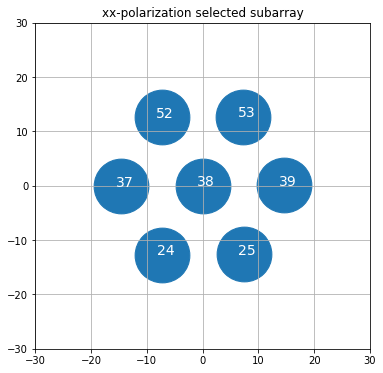

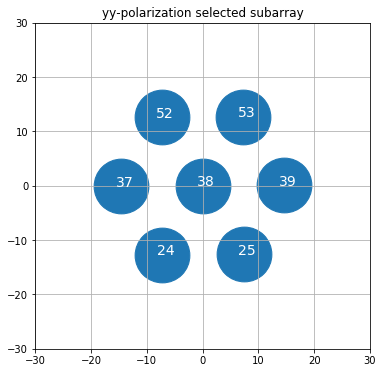

>>>>>>Used nUBL = 9, nt = 60.
Frequencies: 
[ 50.  51.  52.  53.  54.  55.  56.  57.  58.  59.  60.  61.  62.  63.
  64.  65.  66.  67.  68.  69.  70.  71.  72.  73.  74.  75.  76.  77.
  78.  79.  80.  81.  82.  83.  84.  85.  86.  87.  88.  89.  90.  91.
  92.  93.  94.  95.  96.  97.  98.  99. 100. 101. 102. 103. 104. 105.
 106. 107. 108. 109. 110. 111. 112. 113. 114. 115. 116. 117. 118. 119.
 120. 121. 122. 123. 124. 125. 126. 127. 128. 129. 130. 131. 132. 133.
 134. 135. 136. 137. 138. 139. 140. 141. 142. 143. 144. 145. 146. 147.
 148. 149. 150. 151. 152. 153. 154. 155. 156. 157. 158. 159. 160. 161.
 162. 163. 164. 165. 166. 167. 168. 169. 170. 171. 172. 173. 174. 175.
 176. 177. 178. 179. 180. 181. 182. 183. 184. 185. 186. 187. 188. 189.
 190. 191. 192. 193. 194. 195. 196. 197. 198. 199. 200. 201. 202. 203.
 204. 205. 206. 207. 208. 209. 210. 211. 212. 213. 214. 215. 216. 217.
 218. 219. 220. 221. 222. 223. 224. 225. 226. 227. 228. 229. 230. 231.
 232. 233. 234. 235. 236. 237. 23

In [142]:
####################################################
################data file and load beam##############
####################################################
if INSTRUMENT == 'miteor':
	Simulation = True
	Use_SimulatedData = False
	Use_Simulation_noise = False
	
	sys.stdout.flush()
	S_type = 'dyS_lowadduniform_lowI' #'dyS_lowadduniform_lowI'#'none'#'dyS_lowadduniform_Iuniform'  #'none'# dynamic S, addlimit:additive same level as max data; lowaddlimit: 10% of max data; lowadduniform: 10% of median max data; Iuniform median of all data

	seek_optimal_threshs = False and not AtNiA_only
	dynamic_precision = .2#.1#ratio of dynamic pixelization error vs data std, in units of data, so not power
	thresh = 2#.2#2.#.03125#
	valid_pix_thresh = 1.e-4
	nside_start = 32
	nside_standard = 32 # Determine the resolution of GSM of sky

	pre_calibrate = True
	pre_ampcal = ('qC' in tag)
	pre_phscal = True
	pre_addcal = True
	fit_for_additive = False
	nside_beamweight = 16 # Determin shape of A matrix
	
	Integration_Time = 144 # seconds
	Frequency_Bin = 0.75*1.e6 # Hz
	
	lat_degree = 45.2977
	lst_offset = 5.#lsts will be wrapped around [lst_offset, 24+lst_offset]
#	# tag = "q3AL_5_abscal"  #"q0AL_13_abscal"  #"q1AL_10_abscal"'q3_abscalibrated'#"q4AL_3_abscal"# L stands for lenient in flagging
	if 'ampcal' in tag:
		datatag = '_2016_01_20_avg'#'_seccasa.rad'#
		vartag = '_2016_01_20_avgx100'#''#
	else:
		datatag = '_2016_01_20_avg2_unpollock'#'_2016_01_20_avg_unpollock'#'_seccasa.rad'#
		vartag = '_2016_01_20_avg2_unpollock'#'_2016_01_20_avg_unpollockx100'#''#
#	datadir = '/home/omniscope/data/GSM_data/absolute_calibrated_data/'
	datadir = script_dir + '/../Output/'
	antpairs = None
	# deal with beam: create a callable function of the form y(freq) in MHz and returns 2 by npix
	
	
	############################################ Load Beam and Visibility Data ###########################################
	vis_freq_list = flist = np.array([126.83333,127.6667,128.5000,129.3333,130.1667,131.0000,131.8333,132.6667,133.5000,134.3333,135.1667,136.0000,136.8333,137.6667,139.3333,140.0000,141.83333,142.6667,143.5000,144.3333,145.0000,145.1667,146.0000,146.6667,147.5000,148.3333,150.8333,151.6667,152.5000,153.3333,154.1667,155.0000,155.8333,156.0000,156.6667,156.8333,159.3333,161.8333,164.3333,166.8333,167.8333,170.3333,172.8333])
	freq = vis_freq_selected = 150.8333 #MHz
	
	if tag == '-ampcal-':
		tag = '%s-%f'%(INSTRUMENT, freq) + tag
	else:
		tag = '%s-%f'%(INSTRUMENT, freq)
	
	bnside = 64 #Depend on beam pattern data
	freqs = range(110, 200, 10)
	local_beam_unpol = si.interp1d(freqs, np.array([la.norm(np.loadtxt(
		script_dir + '/../data/MITEoR/beam/%s.txt'%(p), skiprows=0).reshape(
		(len(freqs), 12 * bnside ** 2, 4)), axis=-1)**2 for p in ['x', 'y']]).transpose(1, 0, 2), axis=0)
	Plot_Beam = True
	if Plot_Beam:
		plt.figure(0)
		#ind = np.where(beam_freqs == freq)[0][0]
		hp.mollview(10.0 * np.log10(local_beam_unpol(freq)[0,:]), title='HERA-Dipole Beam-East (%sMHz, bnside=%s)'%(freq, bnside),
				unit='dBi')
	#     hp.mollview(10.0 * np.log10(beam_E[ind,:]), title='HERA-Dipole Beam-East (%sMHz, bnside=%s)'%(beam_freqs[ind], bnside),
	#             unit='dBi')
		plt.savefig(script_dir + '/../Output/%s-dipole-Beam-east-%.2f-bnside-%s.pdf'%(INSTRUMENT, freq, bnside))
		hp.mollview(10.0 * np.log10(local_beam_unpol(freq)[1,:]), title='HERA-Dipole Beam-North (%sMHz, bnside=%s)'%(freq, bnside),
				unit='dBi')
	#     hp.mollview(10.0 * np.log10(beam_N[ind,:]), title='HERA-Dipole Beam-North (%sMHz, bnside=%s)'%(beam_freqs[ind], bnside),
	#             unit='dBi')
		plt.savefig(script_dir + '/../Output/%s-dipole-Beam-north-%.2f-bnside-%s.pdf'%(INSTRUMENT, freq, bnside))
		plt.show(block=False)
		#plt.gcf().clear()
			#plt.clf()
			#plt.close()
			
	time_vis_data = np.array([np.loadtxt(script_dir + '/../data/MITEoR/visibilities/%sMHz_%s%s_A.txt'%(vis_freq_selected,p,p)) for p in ['x','y']])
	
	vis_data = (time_vis_data[:,1:,1::3] + time_vis_data[:,1:,2::3] * 1j).astype('complex128')
	var_data = time_vis_data[:,1:,3::3]
	
	tlist = time_vis_data[0,1:,0]
	tmasks = {}
	for p in ['x', 'y']:
		tmasks[p] = np.ones_like(tlist).astype(bool)

	tmask = tmasks['x']&tmasks['y']
	tlist = tlist[tmask]
	nt = nt_used = len(tlist)
	jansky2kelvin = 1.e-26 * (C / freq) ** 2 / 2 / kB / (4 * PI / (12 * nside_standard ** 2))
	nUBL = int(len(time_vis_data[0,0,:])/3)
	
	ubls = {}
	for p in range(2):
		ubls[['x','y'][p]] = time_vis_data[p,0,1:].reshape((nUBL,3))		
	common_ubls = np.array([u for u in ubls['x'] if (u in ubls['y'] or -u in ubls['y'])])
	#manually filter UBLs
	used_common_ubls = common_ubls[la.norm(common_ubls, axis=-1) / (C / freq) <= 1.4 * nside_standard / baseline_safety_factor]#[np.argsort(la.norm(common_ubls, axis=-1))[10:]]     #remove shorted 10
	nUBL_used = len(used_common_ubls)
	ubl_index = {}  # stored index in each pol's ubl for the common ubls
	for p in ['x', 'y']:
		ubl_index[p] = np.zeros(nUBL_used, dtype='int')
		for i, u in enumerate(used_common_ubls):
			if u in ubls[p]:
				ubl_index[p][i] = np.argmin(la.norm(ubls[p] - u, axis=-1)) + 1
			elif -u in ubls[p]:
				ubl_index[p][i] = - np.argmin(la.norm(ubls[p] + u, axis=-1)) - 1
			else:
				raise Exception('Logical Error')

	print '>>>>>>Used nUBL = %i, nt = %i.'%(nUBL_used, nt_used)
	sys.stdout.flush()	
	
	
elif INSTRUMENT == 'hera47':
	Simulation = True
	Use_SimulatedData = False
	Use_Simulation_noise = True
	From_File_Data = True
	Keep_Red = False
	Absolute_Calibration = False
	Absolute_Calibration_red = False
	Absolute_Calibration_mfreq = False
	Absolute_Calibration_dred = False
	Absolute_Calibration_dred_mfreq = True
	PointSource_AbsCal = True
	
	Use_AbsCal = True # Use Model calculated noise which is just fullsim autocorr calculated noise.
	Use_PsAbsCal = False # higher priority over Use_AbsCal and Use_Fullsim_Noise. if comply_ps2mod_autocorr then become just fullsim autocorr calculated noise.
	comply_ps2mod_autocorr = False
	Use_Fullsim_Noise = False # Use fullsim autocorr calculated noise.
	
	Replace_Data = True
	
	pre_calibrate = True
	tag = '-ampcal-' if pre_calibrate else '' #'-ampcal-' #sys.argv[2]; if use real uncalibrated data, set tag = '-ampcal-' for amplitude calibration.
	pre_ampcal = ('ampcal' in tag)
	pre_phscal = True
	pre_addcal = True
	fit_for_additive = True
	
	Add_S_diag = True
	Add_Rcond = False
	
	sys.stdout.flush()
	
	lat_degree = -30.72153 #lon='21:25:41.9' lat='-30:43:17.5'
	lst_offset = 1.43#lsts will be wrapped around [lst_offset, 24+lst_offset]

	Integration_Time = 11 # seconds
	Frequency_Bin = 1.625*1.e6 # Hz

	S_type = 'dyS_lowadduniform_maxI' if Add_S_diag else 'no_use' #'dyS_lowadduniform_minI', 'dyS_lowadduniform_I', 'dyS_lowadduniform_lowI', 'dyS_lowadduniform_lowI'#'none'#'dyS_lowadduniform_Iuniform'  #'none'# dynamic S, addlimit:additive same level as max data; lowaddlimit: 10% of max data; lowadduniform: 10% of median max data; Iuniform median of all data

	seek_optimal_threshs = False and not AtNiA_only
	dynamic_precision = .2#.1#ratio of dynamic pixelization error vs data std, in units of data, so not power
	thresh = 2#.2#2.#.03125#
	valid_pix_thresh = 1.e-4
	nside_start = 32
	nside_standard = 32 # resolution of sky
	nside_beamweight = 16 # A matrix shape
	bnside = 64 # beam pattern data resolution
	
	
#	# tag = "q3AL_5_abscal"  #"q0AL_13_abscal"  #"q1AL_10_abscal"'q3_abscalibrated'#"q4AL_3_abscal"# L stands for lenient in flagging
	if 'ampcal' in tag:
		datatag = '_2018_'#'_seccasa.rad'#
		vartag = '_2018_'#''#
	else:
		datatag = '_2018_ampcaled_'#'_2016_01_20_avg_unpollock'#'_seccasa.rad'#
		vartag = '_2018_ampcaled_'#'_2016_01_20_avg_unpollockx100'#''#
	datadir = script_dir + '/../Output/'
	antpairs = None
	
	#######################################################################################################
	##################################### Load Visibility Data ###########################################
	# specify model file and load into UVData, load into dictionary
	Small_ModelData = True
	Model_Calibration = False
	
	model_fname = {}
	model = {}
	mflags = {}
	mantpos = {}
	mant = {}
	model_freqs = {}
	model_times = {}
	model_lsts = {}
	model_pols = {}
	data_fname = {}
	data_fname_full = {}
	dflags = {}
	data = {}
	antpos = {}
	ants = {}
	data_freqs = {}
	data_times = {}
	data_lsts = {}
	data_pols = {}
	
	fulldflags = {}
	
	if Small_ModelData:
		if Model_Calibration:
			model_fname = {}
			model = mflags = mantpos = mant = model_freqs = model_times = model_lsts = model_pols = {}
			for i in range(2):
				model_fname[i] = os.path.join(DATA_PATH, "zen.2458042.12552.%s.HH.uvXA"%['xx','yy'][i]) #/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192115507/2458042/zen.2458042.13298.xx.HH.uv
				#model_fname[1] = os.path.join(DATA_PATH, "zen.2458042.12552.xx.HH.uvXA") #/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192114862/2458042/zen.2458042.12552.xx.HH.uv
				(model[i], mflags[i], mantpos[i], mants[i], model_freqs[i], model_times[i], model_lsts[i],
				 model_pols[i]) = hc.abscal.UVData2AbsCalDict(model_fname[i], return_meta=True)
			
#			data_fname_omni = os.path.join(DATA_PATH, "zen.2458043.12552.xx.HH.uvORA")
#			(data_omni, dflags_omni, antpos_omni, ants_omni, data_freqs_omni, data_times_omni, data_lsts_omni, 
#			 data_pols_omni) = hc.abscal.UVData2AbsCalDict(data_fname_omni, return_meta=True)
		
		# specify data file and load into UVData, load into dictionary
		for i in range(2):
			data_fname[i] = os.path.join(DATA_PATH, "zen.2458043.12552.%s.HH.uvORA"%['xx', 'yy'][i]) #zen.2457698.40355.xx.HH.uvcA
			if i == 1:
				try:
					#data_fname[1] = os.path.join(DATA_PATH, "zen.2458043.12552.yy.HH.uvORA") #zen.2457698.40355.yy.HH.uvcA
					if not os.path.isfile(data_fname[i]):
						data_fname[1] = os.path.join(DATA_PATH, "zen.2458043.12552.xx.HH.uvORA")
				except:
					pass
			data_fname_full[i] = os.path.join(DATA_PATH, 'Observation-1192287662/2458043/zen.2458043.12552.%s.HH.uvOR'%['xx', 'yy'][i])
			(data[i], dflags[i], antpos[i], ants[i], data_freqs[i], data_times[i], data_lsts[i], 
			 data_pols[i]) = hc.abscal.UVData2AbsCalDict(data_fname[i], return_meta=True)
			
#		try:
#			data_fname_yy = os.path.join(DATA_PATH, "zen.2458043.12552.yy.HH.uvORA") #zen.2457698.40355.yy.HH.uvcA
#			if not os.path.isfile(data_fname_yy):
#				data_fname_yy = os.path.join(DATA_PATH, "zen.2458043.12552.xx.HH.uvORA")
#		except:
#			pass
#		data_fname_yy_full = "/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192287662/2458043/zen.2458043.12552.yy.HH.uvOR"
#		(data_yy, dflags[1], antpos_yy, ants_yy, data_freqs_yy, data_times_yy, data_lsts_yy, 
#		 data_pols_yy) = hc.abscal.UVData2AbsCalDict(data_fname_yy, return_meta=True)
		
		
	else:
		if Model_Calibration:
#			model_fname1 = '/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192115507/2458042/zen.2458042.13298.xx.HH.uv'
#			model_fname2 = '/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192114862/2458042/zen.2458042.12552.xx.HH.uv'
#			model_fname1_yy = '/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192115507/2458042/zen.2458042.13298.yy.HH.uv'
#			model_fname2_yy = '/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192114862/2458042/zen.2458042.12552.yy.HH.uv'
#			(model, mflags, antpos, ants, model_freqs, model_times, model_lsts,
#			 model_pols) = hc.abscal.UVData2AbsCalDict(model_fname1, return_meta=True) # also can try model_fname2
#			(model_yy, mflags_yy, antpos_yy, ants_yy, model_freqs_yy, model_times_yy, model_lsts_yy,
#			 model_pols_yy) = hc.abscal.UVData2AbsCalDict(model_fname2, return_meta=True) # also can try model_fname2
			
			model_fname_dred = {}
			model_dred = mflags_dred = mantpos_dred = mant_dred = model_freqs_dred = model_times_dred = model_lsts_dred = model_pols_dred = {}
			for i in range(2):
				#model_fname[i] = "/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192115507/2458042/zen.2458042.12552.%s.HH.uv"%['xx','yy'][i]#/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192115507/2458042/zen.2458042.13298.xx.HH.uv
				model_fname[i] = os.path.join(DATA_PATH, 'Observation-1192115507/2458042/zen.2458042.12552.%s.HH.uv'%['xx','yy'][i])
				#model_fname[1] = os.path.join(DATA_PATH, "zen.2458042.12552.xx.HH.uvXA") #/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192114862/2458042/zen.2458042.12552.xx.HH.uv
#				(model_dred[i], mflags_dred[i], mantpos_dred[i], mants_dred[i], model_freqs_dred[i], model_times_dred[i], model_lsts_dred[i],
#				 model_pols_dred[i]) = hc.abscal.UVData2AbsCalDict(model_fname_dred[i], return_meta=True)
				(model[i], mflags[i], mantpos[i], mants[i], model_freqs[i], model_times[i], model_lsts[i],
				 model_pols[i]) = hc.abscal.UVData2AbsCalDict(model_fname[i], return_meta=True)
			
#			data_fname_omni = os.path.join(DATA_PATH, "zen.2458043.12552.xx.HH.uvORA")
#			(data_omni, dflags_omni, antpos_omni, ants_omni, data_freqs_omni, data_times_omni, data_lsts_omni, 
#			 data_pols_omni) = hc.abscal.UVData2AbsCalDict(data_fname_omni, return_meta=True)
		
		# specify data file and load into UVData, load into dictionary
		
		for i in range(2):
			data_fname[i] = os.path.join(DATA_PATH, 'Observation-1192287662/2458043/zen.2458043.12552.%s.HH.uvOR'%['xx', 'yy'][i])
			#data_fname[i] = '/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192287662/2458043/zen.2458043.12552.%s.HH.uvOR'%['xx', 'yy'][i]
			(data[i], dflags[i], antpos[i], ants[i], data_freqs[i], data_times[i], data_lsts[i], 
			 data_pols[i]) = hc.abscal.UVData2AbsCalDict(data_fname[i], return_meta=True)
		
#		data_fname_yy = '/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192287662/2458043/zen.2458043.12552.yy.HH.uvOR'
#		(data_yy, dflags_yy, antpos_yy, ants_yy, data_freqs_yy, data_times_yy, data_lsts_yy, 
#		 data_pols_yy) = hc.abscal.UVData2AbsCalDict(data_fname_yy, return_meta=True)
		
		
#	model, interp_flags = hc.abscal.interp2d_vis(model, model_lsts, model_freqs, data_lsts, data_freqs) #interpolate model onto time & freq axes of data
#	# instantiate class
#	AC = hc.abscal.AbsCal(model, data, antpos=antpos, wgts=wgts, freqs=data_freqs) #Instantiate AbsCal object
	
	################# Select Frequency ####################
	flist = {}
	index_freq = {}
	antloc = {}
	dflags_sf = {} #single frequency
	for i in range(2):
		flist[i] = np.array(data_freqs[i])/10**6
		try:
			index_freq[i] = np.where(flist[i]==150)[0][0]
	#		index_freq = 512
		except:
			index_freq[i] = len(flist[i])/2
	
	for i in range(2):
		dflags_sf[i] = LastUpdatedOrderedDict()
		for key in dflags[i].keys():
			dflags_sf[i][key] = dflags[i][key][:,index_freq[i]]
	
	# ant locations
	for i in range(2): 
		antloc[i] = np.array(map(lambda k: antpos[i][k], ants[i]))
#	antloc_yy = np.array(map(lambda k: antpos_yy[k], ants_yy))
	
	# plot sub-array HERA layout
	for j in range(2):
		plt.figure(100000+5*j, figsize=(6,6))
		plt.grid()
		plt.scatter(antloc[j][:, 0], antloc[j][:, 1], s=3000)
		_ = [plt.text(antloc[j][i, 0]-1, antloc[j][i, 1], str(ants[j][i]), fontsize=14, color='w') for i in range(len(antloc[j]))]
		plt.title('%s-polarization selected subarray'%['xx', 'yy'][j])
		plt.xlim(-30, 30)
		plt.ylim(-30, 30)
		plt.show(block=False)
		#plt.cla()

	############################## Autocorrelation #################################
	xxfile = data_fname[0] if not Small_ModelData else data_fname_full[0]
	yyfile = data_fname[1] if not Small_ModelData else data_fname_full[1]
	
	# Load data for autocorrelation calculating
	uvd_xx = UVData()
	uvd_xx.read_miriad(xxfile)
	uvd_xx.ants = np.unique(np.concatenate([uvd_xx.ant_1_array, uvd_xx.ant_2_array]))
	uvd_yy = UVData()
	uvd_yy.read_miriad(yyfile)
	uvd_yy.ants = np.unique(np.concatenate([uvd_yy.ant_1_array, uvd_yy.ant_2_array]))

	# Get metadata
	freqs = uvd_xx.freq_array.squeeze() / 1e6
	times = uvd_xx.time_array.reshape(uvd_xx.Ntimes, uvd_xx.Nbls)[:, 0]
	jd_start = np.floor(times.min())
	Nfreqs = len(freqs)
	Ntimes = len(times)

	# get redundant info
	aa = hc.utils.get_aa_from_uv(uvd_xx)
	info = hc.omni.aa_to_info(aa)
	red_bls = np.array(info.get_reds())
	ants = sorted(np.unique(np.concatenate(red_bls)))
	Nants = len(ants)
	Nside = int(np.ceil(np.sqrt(Nants)))
	Yside = int(np.ceil(float(Nants)/Nside))
	
	try:
		plot_data_autocorr = False
		if plot_data_autocorr: # at specific frequency
			### plot autos
			t_index = 0
			jd = times[t_index]
			utc = Time(jd, format='jd').datetime

			xlim = (-50, Nfreqs+50)
			ylim = (-10,30)

			fig, axes = plt.subplots(Yside, Nside, figsize=(14,14), dpi=75)
			fig.subplots_adjust(wspace=0.2, hspace=0.2)
			fig.suptitle("JD = {0}, time = {1} UTC".format(jd, utc), fontsize=14)
			fig.tight_layout(rect=(0, 0, 1, 0.95))

			k = 0
			for i in range(Yside):
				for j in range(Nside):
					ax = axes[i,j]
					ax.set_xlim(xlim)
					ax.set_ylim(ylim)
					if k < Nants:
						px, = ax.plot(10*np.log10(np.abs(uvd_xx.get_data((ants[k], ants[k]))[t_index])), color='steelblue', alpha=0.75, linewidth=3)
						py, = ax.plot(10*np.log10(np.abs(uvd_yy.get_data((ants[k], ants[k]))[t_index])), color='darkorange', alpha=0.75, linewidth=3)
						ax.grid(True, which='both')
						ax.set_title(str(ants[k]), fontsize=14)
						if k == 0:
							ax.legend([px, py], ['East', 'North'], fontsize=12)
					else:
						ax.axis('off')
					if j != 0:
						ax.set_yticklabels([])
					else:
						[t.set_fontsize(12) for t in ax.get_yticklabels()]
						ax.set_ylabel(r'$10\cdot\log_{10}$ amplitude', fontsize=14)
					if i != Yside-1:
						ax.set_xticklabels([])
					else:
						[t.set_fontsize(12) for t in ax.get_xticklabels()]
						ax.set_xlabel('freq channel', fontsize=14)

					k += 1
			plt.show(block=False)
		
	except:
		pass
		
	autocorr_data_mfreq = {} #np.zeros((2, Ntimes, Nfreqs))
	autocorr_data_mfreq[0] = np.mean(np.array([np.abs(uvd_xx.get_data((ants[k], ants[k]))) for k in range(Nants)]), axis=0)
	autocorr_data_mfreq[1] = np.mean(np.array([np.abs(uvd_yy.get_data((ants[k], ants[k]))) for k in range(Nants)]), axis=0)
	autocorr_data =  {}
	for i in range(2):
		autocorr_data[i] = autocorr_data_mfreq[i][:,index_freq[i]]
		
	if Replace_Data:	
		findex = np.where(freqs==150)
		findex_list = {}
		autocorr_data_mfreq_ff = {}
		for i in range(2):
			findex_list[i] = np.array([np.where(freqs==flist[i][j])[0][0] for j in range(len(flist[i]))])
			
		data_ff = {}
		dflags_ff = {}
		for i in range(2):
			data_ff[i] = LastUpdatedOrderedDict()
			dflags_ff[i] = LastUpdatedOrderedDict()
			for id_key, key in enumerate(dflags[i].keys()):
				#key[2] = 'xx' if i == 0 else 'yy'
				data_ff[i][key[0], key[1], 'xx' if i == 0 else 'yy'] = uvd_xx.get_data((key[0], key[1]))[:,findex_list[i]] if i == 0 else uvd_yy.get_data((key[0], key[1]))[:,findex_list[i]]
				autocorr_data_mfreq_ff[i] = autocorr_data_mfreq[i][:, findex_list[i]]
				dflags_ff[i][key[0], key[1], 'xx' if i == 0 else 'yy'] = dflags[i][key]
						#del data_ff[dflags[i].keys()[id_key]]
		
		data = copy.deepcopy(data_ff)
		dflags = copy.deepcopy(dflags_ff)
		autocorr_data_mfreq = copy.deepcopy(autocorr_data_mfreq_ff)	
		
		del(data_ff)
		del(dflags_ff)
		del(autocorr_data_mfreq_ff)
	#del(autocorr_data_mfreq)
		
	del(uvd_xx)
	del(uvd_yy)
	del(aa)
	del(info)
	
	
	
#	plt.figure(100005, figsize=(6,6))
#	plt.grid()
#	plt.scatter(antloc_yy[:, 0], antloc_yy[:, 1], s=3000)
#	_ = [plt.text(antloc_yy[i, 0]-1, antloc_yy[i, 1], str(ants_yy[i]), fontsize=14, color='w') for i in range(len(antloc_yy))]
#	plt.title('yy polarization selected subarray')
#	plt.xlim(-30, 30)
#	plt.ylim(-30, 30)
#	plt.show(block=False)
	
	
	#bls = odict([(x, antpos[x[0]] - antpos[x[1]]) for x in model.keys()])
	bls = [[],[]]
	for i in range(2):
		bls[i] = odict([(x, antpos[i][x[0]] - antpos[i][x[1]]) for x in data[i].keys()])
		#bls[1] = odict([(y, antpos_yy[y[0]] - antpos_yy[y[1]]) for y in data_yy.keys()])
		bls = np.array(bls)
	
	bsl_coord = [[],[]]
	bsl_coord_x = bsl_coord[0] = np.array([bls[0][index] for index in bls[0].keys()])
	bsl_coord_y = bsl_coord[1] = np.array([bls[1][index] for index in bls[1].keys()])
	#bsl_coord_x=bsl_coord_y=bsl_coord
	bsl_coord = np.array(bsl_coord)
	
	
	########################### Visibility ##############################
	vis_data_mfreq = {}
	#vis_data_Omni_mfreq = np.array([data_omni[bslkeys] for bslkeys in data_omni.keys()], dtype='complex128').transpose((2,1,0)) if Model_Calibration else None
	for i in range(2):
		vis_data_mfreq[i] = np.array([data[i][bslkeys] for bslkeys in data[i].keys()], dtype='complex128').transpose((2,1,0))
#	vis_data_mfreq = np.array([data_yy[bslkeys] for bslkeys in data_yy.keys()], dtype='complex128').transpose((2,1,0))
	
#	vis_data_mfreq = np.zeros((2,vis_data_xx_mfreq.shape[0], vis_data_xx_mfreq.shape[1], vis_data_xx_mfreq.shape[2]), dtype='complex128')
#	vis_data_mfreq[0] = vis_data_xx_mfreq
#	vis_data_mfreq[1] = vis_data_yy_mfreq

	vis_freq_selected = freq = flist[0][index_freq[0]] #MHz For Omni:  0:100, 16:125, 32:150, 48:175;;; For Model:  512:150MHz   Choose xx as reference
	#vis_data = np.zeros((2,vis_data_mfreq.shape[2], vis_data_xx_mfreq.shape[3]), dtype='complex128')
	vis_data = {}
	for i in range(2):
		vis_data[i] = vis_data_mfreq[i][index_freq[i], :, :] # [pol][ freq, time, bl] 

	#del(vis_data_mfreq)
		

	################################## Unique Base Lines and Remove Redundancy ########################################
	
#	np.array(omnical.arrayinfo.compute_reds(antloc)) # Alternate way to compute.
	Ubl_list_raw = [[],[]]
	Ubl_list = [[],[]]
	ant_pos = [[],[]]
	
	Nubl_raw = np.zeros(2, dtype=int)
	times_raw = np.zeros(2, dtype=int)
	times_raw_list = [[],[]]
	redundancy = [[],[]]
	bsl_coord_dred = [[],[]]
	vis_data_dred = [[],[]]
	vis_data_dred_mfreq = [[],[]]
	
	for i in range(2):
		Ubl_list_raw[i] = np.array(omnical.arrayinfo.compute_reds_total(antloc[i])) ## Note that a new function has been added into omnical.arrayinfo as "compute_reds_total" which include all ubls not only redundant ones.
	#Ubl_list_raw[1] = np.array(omnical.arrayinfo.compute_reds_total(antloc_yy)) ## Note that a new function has been added into omnical.arrayinfo as "compute_reds_total" which include all ubls not only redundant ones.
		ant_pos[i] = antpos[i]
	#ant_pos[1] = antpos_yy
	for i in range(2):
		for i_ubl in range(len(Ubl_list_raw[i])):
			list_bsl = []
			for i_ubl_pair in range(len(Ubl_list_raw[0][i_ubl])):
				try:
					list_bsl.append(bls[i].keys().index((ant_pos[i].keys()[Ubl_list_raw[i][i_ubl][i_ubl_pair][0]], ant_pos[i].keys()[Ubl_list_raw[i][i_ubl][i_ubl_pair][1]], '%s'%['xx','yy'][i])))
				except:
					list_bsl.append(bls[i].keys().index((ant_pos[i].keys()[Ubl_list_raw[i][i_ubl][i_ubl_pair][0]], ant_pos[i].keys()[Ubl_list_raw[i][i_ubl][i_ubl_pair][1]], '%s'%['xx','yy'][1-i])))
			Ubl_list[i].append(list_bsl)
	
	for i in range(2):		
		Nubl_raw[i] = len(Ubl_list[i])
		times_raw[i] = len(data_times[i])
		times_raw_list[i] = data_times[i]
		bsl_coord_dred[i] = np.zeros((Nubl_raw[i], 3))
		vis_data_dred[i] = np.zeros((times_raw[i], Nubl_raw[i]), dtype='complex128')
		vis_data_dred_mfreq[i] = np.zeros((len(flist[i]), times_raw[i], Nubl_raw[i]), dtype='complex128')
	
	try:
		var_data_dred = [[],[]]
		var_data_dred[0] = np.zeros((times_raw[0], Nubl_raw[0]), dtype='complex128')
		var_data_dred[1] = np.zeros((times_raw[1], Nubl_raw[1]), dtype='complex128')
	except:
		pass
		
	
	########################### Average on Redundant baselines #############################
	#data_dred = {}
	dflags_dred = {}
		
	for i in range(2):
		#data_dred[i] = {}
		#dflags_dred[i] = {}
		dflags_dred[i] = LastUpdatedOrderedDict()
		pol = ['xx', 'yy'][i]
		
		for i_ubl in range(Nubl_raw[0]):
			vis_data_dred[i][:, i_ubl] = np.mean(vis_data[i].transpose()[Ubl_list[i][i_ubl]].transpose(), axis=1)
			bsl_coord_dred[i][i_ubl] = np.mean(bsl_coord[i][Ubl_list[i][i_ubl]], axis=0)
			#if Absolute_Calibration_dred:
			dflags_dred[i][dflags_sf[i].keys()[Ubl_list[i][i_ubl][0]]] = dflags_sf[i][dflags_sf[i].keys()[Ubl_list[i][i_ubl][0]]]
#				if i == 0:
#					#data_dred[i][dflags.keys()[Ubl_list[i][i_ubl][0]]] = vis_data_dred[i][:, i_ubl]
#					dflags_dred[i][dflags.keys()[Ubl_list[i][i_ubl][0]]] = dflags[dflags.keys()[Ubl_list[i][i_ubl][0]]]
#				else:
#					#data_dred[i][dflags_yy.keys()[Ubl_list[i][i_ubl][0]]] = vis_data_dred[i][:, i_ubl]
#					dflags_dred[i][dflags_yy.keys()[Ubl_list[i][i_ubl][0]]] = dflags_yy[dflags_yy.keys()[Ubl_list[i][i_ubl][0]]]
			redundancy[i].append(len(Ubl_list[i][i_ubl]))
			try:
				var_data_dred[i][:, i_ubl] = np.mean(var_data[i].transpose()[Ubl_list[i][i_ubl]].transpose(), axis=1)
			except:
				pass
				
				
	#vis_data_dred_mfreq = [[],[]]
	dflags_dred_mfreq = {}
		
	for i in range(2):
		#data_dred_mfreq[i] = {}
		#dflags_dred_mfreq[i] = {}
		dflags_dred_mfreq[i] = LastUpdatedOrderedDict()
		pol = ['xx', 'yy'][i]
		
		for i_ubl in range(Nubl_raw[0]):
			vis_data_dred_mfreq[i][:, :, i_ubl] = np.mean(vis_data_mfreq[i][ :, :, Ubl_list[i][i_ubl]], axis=-1)
			#bsl_coord_dred[i][i_ubl] = np.mean(bsl_coord[i][Ubl_list[i][i_ubl]], axis=0)
			#if Absolute_Calibration_dred_mfreq:
			dflags_dred_mfreq[i][dflags[i].keys()[Ubl_list[i][i_ubl][0]]] = dflags[i][dflags[i].keys()[Ubl_list[i][i_ubl][0]]]
#				if i == 0:
#					#data_dred[i][dflags.keys()[Ubl_list[i][i_ubl][0]]] = vis_data_dred[i][:, i_ubl]
#					dflags_dred[i][dflags.keys()[Ubl_list[i][i_ubl][0]]] = dflags[dflags.keys()[Ubl_list[i][i_ubl][0]]]
#				else:
#					#data_dred[i][dflags_yy.keys()[Ubl_list[i][i_ubl][0]]] = vis_data_dred[i][:, i_ubl]
#					dflags_dred[i][dflags_yy.keys()[Ubl_list[i][i_ubl][0]]] = dflags_yy[dflags_yy.keys()[Ubl_list[i][i_ubl][0]]]
			#redundancy[i].append(len(Ubl_list[i][i_ubl]))
			try:
				var_data_dred[i][:, i_ubl] = np.mean(var_data[i][ :, :, Ubl_list[i][i_ubl]], axis=-1)
			except:
				pass
		

	#wgts_dred = copy.deepcopy(dflags_dred)
		
	
	Del = True
	if Del and not Small_ModelData:
		try:
			#del(red_bls)
			#del(autocorr_data_mfreq)
			#del(vis_data_mfreq)
			del(var_data_mfreq)
				
		except:
			pass
			
		try:
			if not Keep_Red:
				del(bsl_coord)
		except:
			pass
	
	sys.stdout.flush()
	
	
	############################### t and f ##########################
	# Using one of the two polarization, which should basically be same from choosing files
	tlist_JD = np.array(data_times[0])
	JD2SI_time = Time(data_times[0], format='jd').datetime
	tlist = np.zeros(len(data_times[0]))
	nt = len(tlist)
	nf = len(flist[0])
	for i in range(len(data_times[0])):
		tlist[i] = si_t = (JD2SI_time[i].hour*3600. + JD2SI_time[i].minute*60. + JD2SI_time[i].second)/3600.
	#	tlist[i] = '%.2f' %si_t
	
	if tag == '-ampcal-':
		tag = '%s-%f'%(INSTRUMENT, freq) + tag
	else:
		tag = '%s-%f'%(INSTRUMENT, freq)
	tmasks = {}
	for p in ['x', 'y']:
		tmasks[p] = np.ones_like(tlist).astype(bool)

	tmask = tmasks['x']&tmasks['y']
	tlist = tlist[tmask]
	lsts = data_lsts[0][tmask]
	nt_used = len(tlist)
	nf_used = len(flist[0])
	jansky2kelvin = 1.e-26 * (C / freq) ** 2 / 2 / kB / (4 * PI / (12 * nside_standard ** 2))
	jansky2kelvin_mfreq = {}
	for j in range(2):
		jansky2kelvin_mfreq[j] = np.array([1.e-26 * (C / flist[j][i]) ** 2 / 2 / kB / (4 * PI / (12 * nside_standard ** 2)) for i in range(len(flist[j]))])
	
	############################## Common UBL ###########################
	ubls = {}
	bls_red = {}
	#freq = 150
#	nside_standard = 32
	baseline_safety_factor = 3.
	
	nBL_red = len(bsl_coord_x)
	for p in ['x', 'y']:
		#ubl_filename = datadir + tag + '_%s%s_%i_%i.ubl' % (p, p, nUBL, 3)
		bls_red[p] = globals()['bsl_coord_' + p]
	common_bls_red = np.array([u for u in bls_red['x'] if (u in bls_red['y'] or -u in bls_red['y'])])
	
	used_common_bls_red = common_bls_red[la.norm(common_bls_red, axis=-1) / (C / freq) <= 1.4 * nside_standard / baseline_safety_factor]#[np.argsort(la.norm(common_ubls, axis=-1))[10:]]     #remove shorted 10
	nBL_red_used = len(used_common_bls_red)
	
	if Keep_Red:
		nUBL = len(bsl_coord_x)
		for p in ['x', 'y']:
			#ubl_filename = datadir + tag + '_%s%s_%i_%i.ubl' % (p, p, nUBL, 3)
			ubls[p] = globals()['bsl_coord_' + p]
		common_ubls = np.array([u for u in ubls['x'] if (u in ubls['y'] or -u in ubls['y'])])
		
	else:
		nUBL = len(bsl_coord_dred[0])
		nUBL_yy = len(bsl_coord_dred[1])
		for i in range(2):
			p = ['x', 'y'][i]
			ubls[p] = bsl_coord_dred[i]
		common_ubls = np.array([u for u in ubls['x'] if (u in ubls['y'] or -u in ubls['y'])])
		
	#common_ubls = np.array([u for u in ubls['x'] if (u in ubls['y'] or -u in ubls['y'])])
	#manually filter UBLs
	used_common_ubls = common_ubls[la.norm(common_ubls, axis=-1) / (C / freq) <= 1.4 * nside_standard / baseline_safety_factor]#[np.argsort(la.norm(common_ubls, axis=-1))[10:]]     #remove shorted 10
	nUBL_used = len(used_common_ubls)
	ubl_index = {}  # stored index in each pol's ubl for the common ubls
	for p in ['x', 'y']:
		ubl_index[p] = np.zeros(nUBL_used, dtype='int')
		for i, u in enumerate(used_common_ubls):
			if u in ubls[p]:
				ubl_index[p][i] = np.argmin(la.norm(ubls[p] - u, axis=-1)) + 1
			elif -u in ubls[p]:
				ubl_index[p][i] = - np.argmin(la.norm(ubls[p] + u, axis=-1)) - 1
			else:
				raise Exception('Logical Error')

	print '>>>>>>Used nUBL = %i, nt = %i.'%(nUBL_used, nt_used)
	sys.stdout.flush()
	
	######################### Beam Pattern #############################
	
	filename = script_dir + '/../data/HERA-47/Beam-Dipole/healpix_beam.fits'
	beam_E = fits.getdata(filename, extname='BEAM_E').T #E is east corresponding to X polarization
	beam_nside = hp.npix2nside(beam_E.shape[1])
	beam_freqs = fits.getdata(filename, extname='FREQS')

	print('Frequencies: ')
	print(beam_freqs)
	
	# select only 100-200 MHz data
#	freq_select = np.where((freqs >= 100) & (freqs <=200))[0]
#	beams = beams[:, freq_select]
#	freqs = freqs[freq_select]
#	Nfreqs = len(freqs)

	# take East pol and rotate to get North pol
	Nfreqs = len(beam_freqs)
	beam_theta, beam_phi = hp.pix2ang(64, np.arange(64**2 * 12))
	#R = hp.Rotator(rot=[0,0,-np.pi/2], deg=False)
	R = hp.Rotator(rot=[-np.pi/2,0,0], deg=False)
	beam_theta2, beam_phi2 = R(beam_theta, beam_phi)
	beam_N = np.array(map(lambda x: hp.get_interp_val(x, beam_theta2, beam_phi2), beam_E))
	beam_EN = np.array([beam_E, beam_N])
	beam_EN.resize(2, Nfreqs, 49152)
	
#	# normalize each frequency to max of 1
#	for i in range(beam_EN.shape[-2]):
#		beam_EN[:, i, :] /= beam_EN[:, i, :].max()
	
	local_beam_unpol = si.interp1d(beam_freqs, beam_EN.transpose(1, 0, 2), axis=0)
	

In [143]:
print INSTRUMENT
print tag
#tag = 'ampcal'
print Nants
print Small_ModelData
print data_fname
print len(antloc)

hera47
hera47-150.000000-ampcal-
47
True
{0: '/Users/JianshuLi/anaconda3/envs/Cosmology-Python27/lib/python2.7/site-packages/hera_cal-1.0-py2.7.egg/hera_cal/data/zen.2458043.12552.xx.HH.uvORA', 1: '/Users/JianshuLi/anaconda3/envs/Cosmology-Python27/lib/python2.7/site-packages/hera_cal-1.0-py2.7.egg/hera_cal/data/zen.2458043.12552.xx.HH.uvORA'}
2


In [144]:
print bsl_coord
print red_bls
print len(red_bls)

[[[ 7.35221779e+00 -1.26189069e+01  9.99681658e-02]
  [-2.18634287e+01 -1.27404881e+01  1.89519037e-01]
  [-1.46078417e+01 -5.57878836e-02  2.97754315e-02]
  [-7.25562415e+00 -1.26746948e+01  1.09726883e-01]
  [-2.92156839e+01 -1.11576036e-01  3.95508570e-02]
  [-7.25562404e+00 -1.26746948e+01  1.29743593e-01]
  [ 7.35225495e+00 -1.26289123e+01  1.49984888e-01]
  [-7.25558699e+00 -1.26847002e+01  1.59743605e-01]
  [ 9.66311028e-02 -2.53036069e+01  2.79711773e-01]
  [ 9.66307942e-02 -2.53036071e+01  2.59711771e-01]
  [ 7.35225515e+00 -1.26289121e+01  1.49968180e-01]
  [-2.18634661e+01 -1.27304829e+01  1.39519023e-01]
  [-1.46078419e+01 -5.57879046e-02  9.75871691e-03]
  [ 7.35221790e+00 -1.26189067e+01  9.99514526e-02]
  [-7.25558679e+00 -1.26847002e+01  1.79760320e-01]
  [ 1.47044728e+01 -2.52478190e+01  2.49936341e-01]
  [-1.45112109e+01 -2.53593950e+01  2.89487203e-01]
  [ 2.19600969e+01 -1.25731242e+01  1.20192748e-01]
  [-1.46078419e+01 -5.57881319e-02  2.97921401e-02]
  [ 2.196005

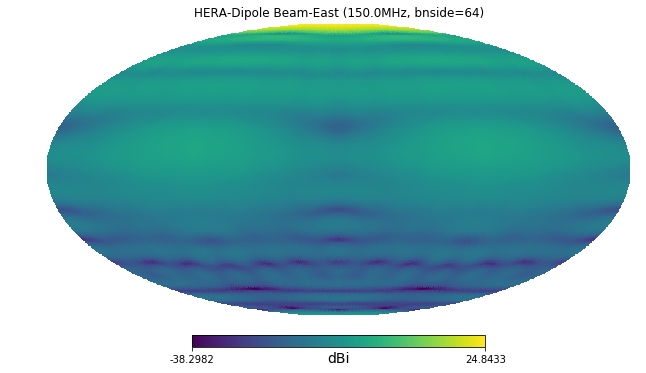

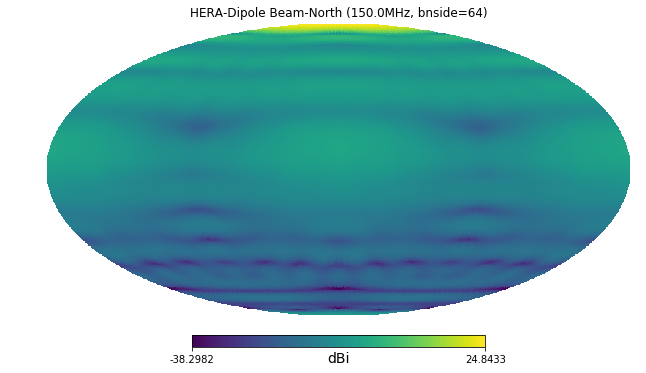

In [145]:

Plot_Beam = True
if Plot_Beam:
    plt.figure(0)
    #ind = np.where(beam_freqs == freq)[0][0]
    hp.mollview(10.0 * np.log10(local_beam_unpol(freq)[0,:]), title='HERA-Dipole Beam-East (%sMHz, bnside=%s)'%(freq, bnside),
            unit='dBi')
#     hp.mollview(10.0 * np.log10(beam_E[ind,:]), title='HERA-Dipole Beam-East (%sMHz, bnside=%s)'%(beam_freqs[ind], bnside),
#             unit='dBi')
    plt.savefig(script_dir + '/../Output/%s-dipole-Beam-east-%.2f-bnside-%s.pdf'%(INSTRUMENT, freq, bnside))
    hp.mollview(10.0 * np.log10(local_beam_unpol(freq)[1,:]), title='HERA-Dipole Beam-North (%sMHz, bnside=%s)'%(freq, bnside),
            unit='dBi')
#     hp.mollview(10.0 * np.log10(beam_N[ind,:]), title='HERA-Dipole Beam-North (%sMHz, bnside=%s)'%(beam_freqs[ind], bnside),
#             unit='dBi')
    plt.savefig(script_dir + '/../Output/%s-dipole-Beam-north-%.2f-bnside-%s.pdf'%(INSTRUMENT, freq, bnside))
    plt.show(block=False)
    #plt.gcf().clear()
        #plt.clf()
        #plt.close()



In [146]:
print local_beam_unpol(150)[0:]
print local_beam_unpol(150)[0:].sum()
print local_beam_unpol(150)[0:].min()
print local_beam_unpol(150)[0:].max()

[[317.35033648 317.36347034 317.36347034 ...   0.45564572   0.45564572
    0.4558748 ]
 [317.36347034 317.36347034 317.35033648 ...   0.45564572   0.4558748
    0.4558748 ]]
98426.09926039288
0.00014797059467877035
317.3634703353978


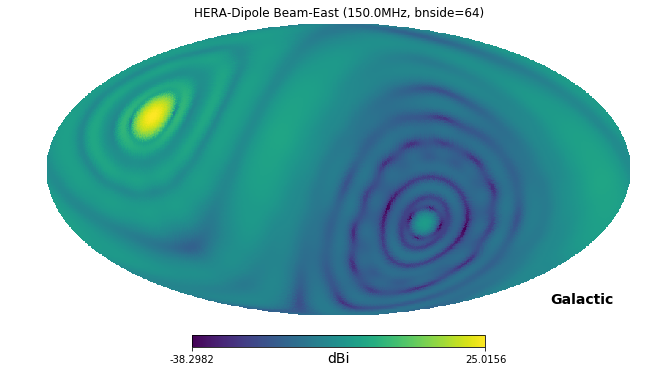

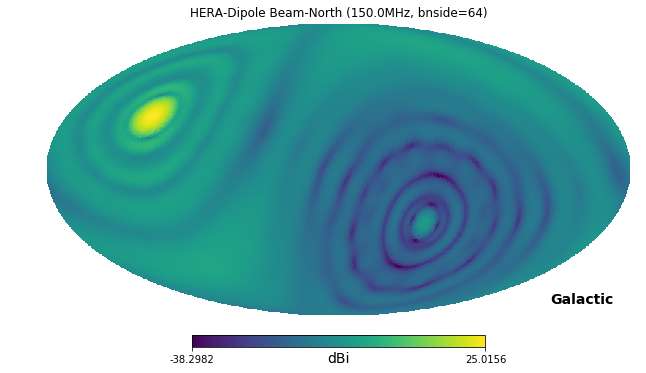

In [147]:
Plot_Beam = True
if Plot_Beam:
    plt.figure(0)
    #ind = np.where(beam_freqs == freq)[0][0]
    hp.mollview(10.0 * np.log10(local_beam_unpol(freq)[0,:]), coord='CG', title='HERA-Dipole Beam-East (%sMHz, bnside=%s)'%(freq, bnside),
            unit='dBi')
#     hp.mollview(10.0 * np.log10(beam_E[ind,:]), title='HERA-Dipole Beam-East (%sMHz, bnside=%s)'%(beam_freqs[ind], bnside),
#             unit='dBi')
    plt.savefig(script_dir + '/../Output/%s-dipole-Beam-east-%.2f-bnside-%s.pdf'%(INSTRUMENT, freq, bnside))
    hp.mollview(10.0 * np.log10(local_beam_unpol(freq)[1,:]), coord='CG', title='HERA-Dipole Beam-North (%sMHz, bnside=%s)'%(freq, bnside),
            unit='dBi')
#     hp.mollview(10.0 * np.log10(beam_N[ind,:]), title='HERA-Dipole Beam-North (%sMHz, bnside=%s)'%(beam_freqs[ind], bnside),
#             unit='dBi')
    plt.savefig(script_dir + '/../Output/%s-dipole-Beam-north-%.2f-bnside-%s.pdf'%(INSTRUMENT, freq, bnside))
    plt.show(block=False)
    #plt.gcf().clear()
        #plt.clf()
        #plt.close()


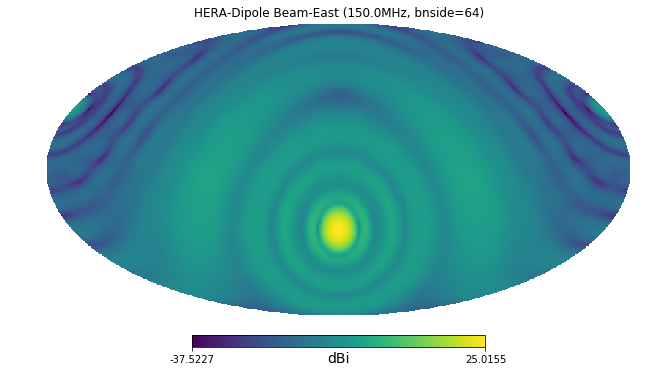

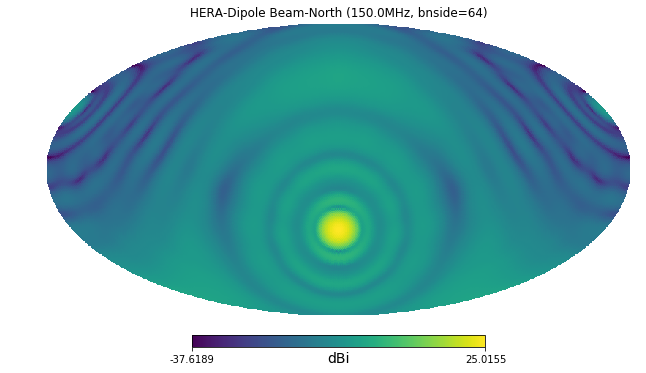

In [148]:
#################
####set up vs and beam
################
vs = sv.Visibility_Simulator()
vs.initial_zenith = np.array([0, lat_degree * PI / 180])  # self.zenithequ
beam_heal_hor_x = local_beam_unpol(freq)[0]
beam_heal_hor_y = local_beam_unpol(freq)[1]
beam_heal_equ_x = sv.rotate_healpixmap(beam_heal_hor_x, 0, PI / 2 - vs.initial_zenith[1], vs.initial_zenith[0])
beam_heal_equ_y = sv.rotate_healpixmap(beam_heal_hor_y, 0, PI / 2 - vs.initial_zenith[1], vs.initial_zenith[0])

if Absolute_Calibration_dred_mfreq:
	beam_heal_hor_x_mfreq = np.array([local_beam_unpol(flist[0][i])[0] for i in range(nf_used)])
	beam_heal_hor_y_mfreq = np.array([local_beam_unpol(flist[1][i])[1] for i in range(nf_used)])
	beam_heal_equ_x_mfreq = np.array([sv.rotate_healpixmap(beam_heal_hor_x_mfreq[i], 0, PI / 2 - vs.initial_zenith[1], vs.initial_zenith[0]) for i in range(nf_used)])
	beam_heal_equ_y_mfreq = np.array([sv.rotate_healpixmap(beam_heal_hor_y_mfreq[i], 0, PI / 2 - vs.initial_zenith[1], vs.initial_zenith[0]) for i in range(nf_used)])


Plot_Beam = True
if Plot_Beam:
	plt.figure(10)
	#ind = np.where(beam_freqs == freq)[0][0]
	hp.mollview(10.0 * np.log10(beam_heal_equ_x), title='HERA-Dipole Beam-East (%sMHz, bnside=%s)'%(freq, bnside),
			unit='dBi')
	plt.savefig(script_dir + '/../Output/%s-equ-dipole-Beam-east-%.2f-bnside-%s.pdf'%(INSTRUMENT, freq, bnside))
	hp.mollview(10.0 * np.log10(beam_heal_equ_y), title='HERA-Dipole Beam-North (%sMHz, bnside=%s)'%(freq, bnside),
			unit='dBi')
	plt.savefig(script_dir + '/../Output/%s-equ-dipole-Beam-north-%.2f-bnside-%s.pdf'%(INSTRUMENT, freq, bnside))
	plt.show(block=False)

sys.stdout.flush()

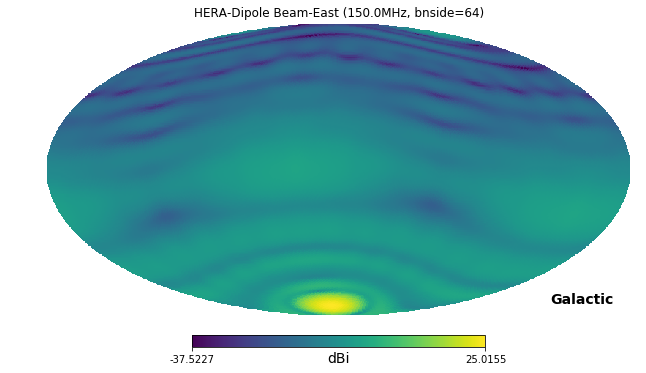

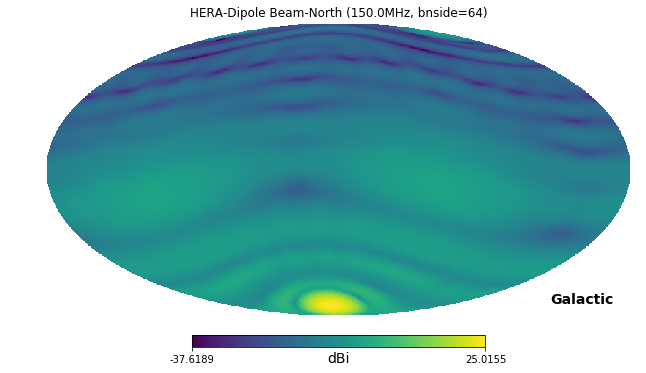

In [149]:
if Plot_Beam:
	plt.figure(0)
# 	ind = np.where(beam_freqs == freq)[0][0]
	hp.mollview(10.0 * np.log10(beam_heal_equ_x), coord='CG', title='HERA-Dipole Beam-East (%sMHz, bnside=%s)'%(freq, bnside),
			unit='dBi')
	#plt.savefig(script_dir + '/../Output/%s-equ-dipole-Beam-east-CG-%.2f-bnside-%s.pdf'%(INSTRUMENT, beam_freqs[ind], bnside))
	hp.mollview(10.0 * np.log10(beam_heal_equ_y), coord='CG', title='HERA-Dipole Beam-North (%sMHz, bnside=%s)'%(freq, bnside),
			unit='dBi')
	#plt.savefig(script_dir + '/../Output/%s-equ-dipole-Beam-north-CG-%.2f-bnside-%s.pdf'%(INSTRUMENT, beam_freqs[ind], bnside))
	plt.show(block=False)

In [150]:
########################### Delete some Input Data ##############################
Del=True
if Del:
	#del(data)
	#del(data_yy)
	try:
		#del(model)
		#del(model_yy)
		del(data_omni)
	except:
		pass

sys.stdout.flush()

In [151]:
######################
####initial A to compute beam weight
#####################
A_version = 1.0
A = {}
for p in ['x', 'y']:
	pol = p + p
	# ubl file
	#// ubl_filename = datadir + tag + '_%s%s_%i_%i.ubl' % (p, p, nUBL, 3)
	#ubls = np.array([[0,0,0]])
	#//np.fromfile(ubl_filename, dtype='float32').reshape((nUBL, 3))
	print "%i UBLs to include, longest baseline is %i wavelengths for Pol: %s" % (len(ubls[p]), np.max(np.linalg.norm(ubls[p], axis=1)) / (C / freq), pol)
	print "%i Used-Common-UBLs to include, longest baseline is %i wavelengths for Pol: %s" % (len(used_common_ubls), np.max(np.linalg.norm(used_common_ubls, axis=1)) / (C / freq), pol)

	# beam
	if p == 'x':
		beam_heal_equ = beam_heal_equ_x
	elif p == 'y':
		beam_heal_equ = beam_heal_equ_x
	print "Computing sky weighting A matrix for %s pol..." % p
	sys.stdout.flush()

	A[p] = np.zeros((nt_used * len(used_common_ubls), 12 * nside_beamweight ** 2), dtype='complex128')

	timer = time.time()
	for i in np.arange(12 * nside_beamweight ** 2):
		dec, ra = hpf.pix2ang(nside_beamweight, i)  # gives theta phi
		dec = PI / 2 - dec
		print "\r%.1f%% completed" % (100. * float(i) / (12. * nside_beamweight ** 2)),
		sys.stdout.flush()
		if abs(dec - lat_degree * PI / 180) <= PI / 2:
			A[p][:, i] = vs.calculate_pointsource_visibility(ra, dec, used_common_ubls, freq, beam_heal_equ=beam_heal_equ, tlist=lsts).flatten()

	print "%f minutes used" % (float(time.time() - timer) / 60.)
	sys.stdout.flush()
	

9 UBLs to include, longest baseline is 14 wavelengths for Pol: xx
9 Used-Common-UBLs to include, longest baseline is 14 wavelengths for Pol: xx
Computing sky weighting A matrix for x pol...
100.0% completed                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [152]:
####################################################
###beam weights using an equal pixel A matrix######
#################################################
print "Computing beam weight...",
sys.stdout.flush()
beam_weight = ((la.norm(A['x'], axis=0) ** 2 + la.norm(A['y'], axis=0) ** 2) ** .5)[hpf.nest2ring(nside_beamweight, range(12 * nside_beamweight ** 2))]
beam_weight = beam_weight / np.mean(beam_weight)
thetas_standard, phis_standard = hpf.pix2ang(nside_standard, range(hpf.nside2npix(nside_standard)), nest=True)
beam_weight = hpf.get_interp_val(beam_weight, thetas_standard, phis_standard, nest=True) #np.array([beam_weight for i in range(nside_standard ** 2 / nside_beamweight ** 2)]).transpose().flatten()
print "done."
sys.stdout.flush()

Computing beam weight... done.


In [153]:
################################################
#####################GSM###########################
#############################################
pca1 = hp.fitsfunc.read_map(script_dir + '/../data/gsm1.fits' + str(nside_standard))
pca2 = hp.fitsfunc.read_map(script_dir + '/../data/gsm2.fits' + str(nside_standard))
pca3 = hp.fitsfunc.read_map(script_dir + '/../data/gsm3.fits' + str(nside_standard))
components = np.loadtxt(script_dir + '/../data/components.dat')
scale_loglog = si.interp1d(np.log(components[:, 0]), np.log(components[:, 1]))
w1 = si.interp1d(components[:, 0], components[:, 2])
w2 = si.interp1d(components[:, 0], components[:, 3])
w3 = si.interp1d(components[:, 0], components[:, 4])
gsm_standard = np.exp(scale_loglog(np.log(freq))) * (w1(freq) * pca1 + w2(freq) * pca2 + w3(freq) * pca3)
if Absolute_Calibration_dred_mfreq:
	gsm_standard_mfreq = np.array([np.exp(scale_loglog(np.log(flist[0][i]))) * (w1(flist[0][i]) * pca1 + w2(flist[0][i]) * pca2 + w3(flist[0][i]) * pca3) for i in range(nf_used)])

# rotate sky map and converts to nest
equatorial_GSM_standard = np.zeros(12 * nside_standard ** 2, 'float')
print "Rotating GSM_standard and converts to nest...",

if INSTRUMENT == 'miteor':
	DecimalYear = 2013.58 #2013, 7, 31, 16, 47, 59, 999998)
elif INSTRUMENT == 'hera47':
	DecimalYear = np.mean(Time(data_times[0], format='jd').decimalyear)
	JulianEpoch = np.mean(Time(data_times[0], format='jd').jyear)

sys.stdout.flush()
equ_to_gal_matrix = hp.rotator.Rotator(coord='cg').mat.dot(sv.epoch_transmatrix(2000, stdtime=JulianEpoch))
ang0, ang1 = hp.rotator.rotateDirection(equ_to_gal_matrix,
					hpf.pix2ang(nside_standard, range(12 * nside_standard ** 2), nest=True))
equatorial_GSM_standard = hpf.get_interp_val(gsm_standard, ang0, ang1)
if Absolute_Calibration_dred_mfreq:
	equatorial_GSM_standard_mfreq = np.array([hpf.get_interp_val(gsm_standard_mfreq[i], ang0, ang1) for i in range(nf_used)])
print "done."

Del=True
if Del:
	del(pca1)
	del(pca2)
	del(pca3)
	del(w1)
	del(w2)
	del(w3)
	del(components)
	del(scale_loglog)
	del(gsm_standard)
	try:
		del(gsm_standard_mfreq)
	except:
		pass
sys.stdout.flush()

NSIDE = 32
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 32
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 32
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
Rotating GSM_standard and converts to nest... done.


In [154]:
#print A.shape

In [155]:
###########################################################
####simulate visibilities using non dynamic pixelization###
##########################################
full_sim_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i.simvis'%(INSTRUMENT, freq, nUBL_used+1, nt_used, nside_standard, bnside)
sim_vis_xx_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_vis_sim_xx.simvis'%(INSTRUMENT, freq, nUBL_used+1, nt_used, nside_standard, bnside)
sim_vis_yy_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_vis_sim_yy.simvis'%(INSTRUMENT, freq, nUBL_used+1, nt_used, nside_standard, bnside)
if simulation_opt == 1:
	
	if os.path.isfile(full_sim_filename):
		fullsim_vis = np.fromfile(full_sim_filename, dtype='complex128').reshape((2, nUBL_used+1, nt_used))
		fullsim_vis[0][:-1,:].astype('complex128').tofile(sim_vis_xx_filename)
		fullsim_vis[1][:-1,:].astype('complex128').tofile(sim_vis_yy_filename)
		
	else:

		fullsim_vis = np.zeros((2, nUBL_used + 1, nt_used), dtype='complex128')#since its going to accumulate along the pixels it needs to start with complex128. significant error if start with complex64
		full_sim_ubls = np.concatenate((used_common_ubls, [[0, 0, 0]]), axis=0)#tag along auto corr
		full_thetas, full_phis = hpf.pix2ang(nside_standard, range(hpf.nside2npix(nside_standard)), nest=True)
		full_decs = PI / 2 - full_thetas
		full_ras = full_phis
		full_sim_mask = hpf.get_interp_val(beam_weight, full_thetas, full_phis, nest=True) > 0
		# fullsim_vis_DBG = np.zeros((2, len(used_common_ubls), nt_used, np.sum(full_sim_mask)), dtype='complex128')

		print "Simulating visibilities, %s, expected time %.1f min"%(datetime.datetime.now(), 14.6 * (nUBL_used / 78.) * (nt_used / 193.) * (np.sum(full_sim_mask) / 1.4e5)),
		sys.stdout.flush()
		masked_equ_GSM = equatorial_GSM_standard[full_sim_mask]
		timer = time.time()
		for p, beam_heal_equ in enumerate([beam_heal_equ_x, beam_heal_equ_y]):
			for i, (ra, dec) in enumerate(zip(full_ras[full_sim_mask], full_decs[full_sim_mask])):
				res = vs.calculate_pointsource_visibility(ra, dec, full_sim_ubls, freq, beam_heal_equ=beam_heal_equ, tlist=lsts) / 2
				fullsim_vis[p] += masked_equ_GSM[i] * res
				# fullsim_vis_DBG[p, ..., i] = res[:-1]
				#autocorr = ~16*la.norm, ~80*np.std, ~1.e-5*np.corrrelate
		print "simulated visibilities in %.1f minutes."%((time.time() - timer) / 60.)
		fullsim_vis.astype('complex128').tofile(full_sim_filename)
		fullsim_vis[0][:-1,:].astype('complex128').tofile(sim_vis_xx_filename)
		fullsim_vis[1][:-1,:].astype('complex128').tofile(sim_vis_yy_filename)
		
	autocorr_vis = np.abs(fullsim_vis[:, -1])
	if crosstalk_type == 'autocorr':
		autocorr_vis_normalized = np.array([autocorr_vis[p] / (la.norm(autocorr_vis[p]) / la.norm(np.ones_like(autocorr_vis[p]))) for p in range(2)])
	else:
		autocorr_vis_normalized = np.ones((2, nt_used))
	fullsim_vis = fullsim_vis[:, :-1].transpose((1, 0, 2))


In [156]:
print autocorr_vis.mean()
print fullsim_vis.mean()

1227565.6587779154
(1556.6106039729052-329.7816353772341j)


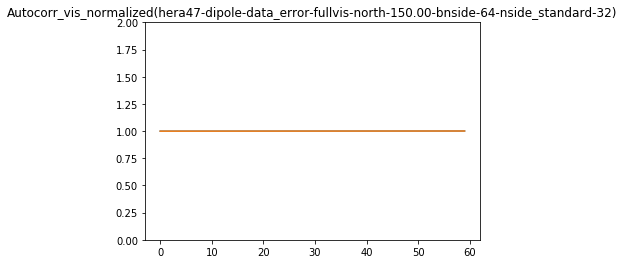

In [157]:
if plot_data_error:
	#plt.clf()
	plt.figure(30)
	plt.plot(autocorr_vis_normalized.transpose())
	plt.title('Autocorr_vis_normalized(%s-dipole-data_error-fullvis-north-%.2f-bnside-%s-nside_standard-%s)'%(INSTRUMENT, freq, bnside, nside_standard))
	plt.ylim([0, 2])
	plt.savefig(script_dir + '/../Output/%s-dipole-data_error-fullvis-north-%.2f-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, freq, bnside, nside_standard))
	plt.show(block=False)
	#plt.gcf().clear()
	#plt.clf()
	#plt.close()
sys.stdout.flush()


In [158]:
######################################### Absolute Calibration on Omnicaled Data #############################################
if Absolute_Calibration_red:
	full_redabs_sim_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_redabs.simvis'%(INSTRUMENT, freq, nBL_red_used+1, nt_used, nside_standard, bnside)
	redabs_sim_vis_xx_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_vis_redabs_sim_xx.simvis'%(INSTRUMENT, freq, nBL_red_used+1, nt_used, nside_standard, bnside)
	redabs_sim_vis_yy_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_vis_redabs_sim_yy.simvis'%(INSTRUMENT, freq, nBL_red_used+1, nt_used, nside_standard, bnside)
		
	if os.path.isfile(full_redabs_sim_filename):
		fullsim_vis_red = np.fromfile(full_redabs_sim_filename, dtype='complex128').reshape((2, nBL_red_used+1, nt_used))
		fullsim_vis_red[0][:-1,:].astype('complex128').tofile(redabs_sim_vis_xx_filename)
		fullsim_vis_red[1][:-1,:].astype('complex128').tofile(redabs_sim_vis_yy_filename)
		
	else:

		fullsim_vis_red = np.zeros((2, nBL_red_used + 1, nt_used), dtype='complex128')#since its going to accumulate along the pixels it needs to start with complex128. significant error if start with complex64
		full_sim_bls_red = np.concatenate((used_common_bls_red, [[0, 0, 0]]), axis=0)#tag along auto corr
		full_thetas, full_phis = hpf.pix2ang(nside_standard, range(hpf.nside2npix(nside_standard)), nest=True)
		full_decs = PI / 2 - full_thetas
		full_ras = full_phis
		full_sim_mask = hpf.get_interp_val(beam_weight, full_thetas, full_phis, nest=True) > 0
		# fullsim_vis_DBG = np.zeros((2, len(used_common_ubls), nt_used, np.sum(full_sim_mask)), dtype='complex128')

		print "Simulating redundant visibilities, %s, expected time %.1f min"%(datetime.datetime.now(), 14.6 * (nBL_red_used / 78.) * (nt_used / 193.) * (np.sum(full_sim_mask) / 1.4e5)),
		sys.stdout.flush()
		masked_equ_GSM = equatorial_GSM_standard[full_sim_mask]
		timer = time.time()
		for p, beam_heal_equ in enumerate([beam_heal_equ_x, beam_heal_equ_y]):
			for i, (ra, dec) in enumerate(zip(full_ras[full_sim_mask], full_decs[full_sim_mask])):
				res_red = vs.calculate_pointsource_visibility(ra, dec, full_sim_bls_red, freq, beam_heal_equ=beam_heal_equ, tlist=lsts) / 2
				fullsim_vis_red[p] += masked_equ_GSM[i] * res_red
				# fullsim_vis_DBG[p, ..., i] = res[:-1]
				#autocorr = ~16*la.norm, ~80*np.std, ~1.e-5*np.corrrelate
		print "simulated redundant visibilities in %.1f minutes."%((time.time() - timer) / 60.)
		fullsim_vis_red.astype('complex128').tofile(full_redabs_sim_filename)
		fullsim_vis_red[0][:-1,:].astype('complex128').tofile(redabs_sim_vis_xx_filename)
		fullsim_vis_red[1][:-1,:].astype('complex128').tofile(redabs_sim_vis_yy_filename)
		
	autocorr_vis_red = np.abs(fullsim_vis_red[:, -1])
	if crosstalk_type == 'autocorr':
		autocorr_vis_red_normalized = np.array([autocorr_vis_red[p] / (la.norm(autocorr_vis_red[p]) / la.norm(np.ones_like(autocorr_vis_red[p]))) for p in range(2)])
	else:
		autocorr_vis_red_normalized = np.ones((2, nt_used))
	fullsim_vis_red = fullsim_vis_red[:, :-1].transpose((1, 0, 2)) 

	if plot_data_error:
		#plt.clf()
		plt.figure(3000000)
		plt.plot(autocorr_vis_red_normalized.transpose())
		plt.title('Autocorr_vis_normalized(%s-dipole-data_error-fullvis_red-north-%.2f-bnside-%s-nside_standard-%s)'%(INSTRUMENT, freq, bnside, nside_standard))
		plt.ylim([0, 2])
		plt.savefig(script_dir + '/../Output/%s-dipole-data_error-fullvis_red-north-%.2f-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, freq, bnside, nside_standard))
		plt.show(block=False)
		#plt.gcf().clear()
		#plt.clf()
		#plt.close()
	sys.stdout.flush()


In [159]:
if Absolute_Calibration_dred_mfreq: # Used 9.4 min. 64*9*60*12280
	full_sim_filename_mfreq = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_mfreq%s-%s-%s.simvis'%(INSTRUMENT, nUBL_used+1, nt_used, nside_standard, bnside, np.min(flist[0]), np.max(flist[0]), len(flist[0]))
	sim_vis_xx_filename_mfreq = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_vis_sim_xx_mfreq%s-%s-%s.simvis'%(INSTRUMENT, nUBL_used+1, nt_used, nside_standard, bnside, np.min(flist[0]), np.max(flist[0]), len(flist[0]))
	sim_vis_yy_filename_mfreq = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_vis_sim_yy_mfreq%s-%s-%s.simvis'%(INSTRUMENT, nUBL_used+1, nt_used, nside_standard, bnside, np.min(flist[0]), np.max(flist[0]), len(flist[1]))
	if simulation_opt == 1:
		
		if os.path.isfile(full_sim_filename_mfreq):
			fullsim_vis_mfreq = np.fromfile(full_sim_filename_mfreq, dtype='complex128').reshape((2, nUBL_used+1, nt_used, nf_used))
			fullsim_vis_mfreq[0][:-1].astype('complex128').tofile(sim_vis_xx_filename_mfreq)
			fullsim_vis_mfreq[1][:-1].astype('complex128').tofile(sim_vis_yy_filename_mfreq)
			
		else:

			fullsim_vis_mfreq = np.zeros((2, nUBL_used + 1, nt_used, nf_used), dtype='complex128')#since its going to accumulate along the pixels it needs to start with complex128. significant error if start with complex64
			full_sim_ubls = np.concatenate((used_common_ubls, [[0, 0, 0]]), axis=0)#tag along auto corr
			full_thetas, full_phis = hpf.pix2ang(nside_standard, range(hpf.nside2npix(nside_standard)), nest=True)
			full_decs = PI / 2 - full_thetas
			full_ras = full_phis
			full_sim_mask = hpf.get_interp_val(beam_weight, full_thetas, full_phis, nest=True) > 0
			# fullsim_vis_DBG = np.zeros((2, len(used_common_ubls), nt_used, np.sum(full_sim_mask)), dtype='complex128')

			print "Simulating visibilities, %s, expected time %.1f min"%(datetime.datetime.now(), 14.6 * nf_used * (nUBL_used / 78.) * (nt_used / 193.) * (np.sum(full_sim_mask) / 1.4e5)),
			sys.stdout.flush()
			masked_equ_GSM_mfreq = equatorial_GSM_standard_mfreq[:, full_sim_mask]
			timer = time.time()
			for id_f, f in enumerate(flist[0]):
				for p, beam_heal_equ in enumerate([beam_heal_equ_x_mfreq[id_f], beam_heal_equ_y_mfreq[id_f]]):
					for i, (ra, dec) in enumerate(zip(full_ras[full_sim_mask], full_decs[full_sim_mask])):
						res = vs.calculate_pointsource_visibility(ra, dec, full_sim_ubls, f, beam_heal_equ=beam_heal_equ, tlist=lsts) / 2
						fullsim_vis_mfreq[p, :, :, id_f] += masked_equ_GSM_mfreq[id_f, i] * res
						# fullsim_vis_DBG[p, ..., i] = res[:-1]
						#autocorr = ~16*la.norm, ~80*np.std, ~1.e-5*np.corrrelate
			print "simulated visibilities in %.1f minutes."%((time.time() - timer) / 60.)
			fullsim_vis_mfreq.astype('complex128').tofile(full_sim_filename_mfreq)
			fullsim_vis_mfreq[0][:-1, :, :].astype('complex128').tofile(sim_vis_xx_filename_mfreq)
			fullsim_vis_mfreq[1][:-1, :, :].astype('complex128').tofile(sim_vis_yy_filename_mfreq)
			
		autocorr_vis_mfreq = np.abs(fullsim_vis_mfreq[:, -1])
#		if crosstalk_type == 'autocorr':
#			autocorr_vis_normalized = np.array([autocorr_vis[p] / (la.norm(autocorr_vis[p]) / la.norm(np.ones_like(autocorr_vis[p]))) for p in range(2)])
#		else:
#			autocorr_vis_normalized = np.ones((2, nt_used))
		fullsim_vis_mfreq = fullsim_vis_mfreq[:, :-1].transpose((1, 0, 2, 3)) # (uBL, Pol, Times, Freqs)


In [160]:
if not Model_Calibration: #and Absolute_Calibration is True:
#		model_fname1 = '/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192115507/2458042/zen.2458042.13298.xx.HH.uv'
#		model_fname2 = '/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192114862/2458042/zen.2458042.12552.xx.HH.uv'
#		model_fname1_yy = '/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192115507/2458042/zen.2458042.13298.yy.HH.uv'
#		model_fname2_yy = '/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192114862/2458042/zen.2458042.12552.yy.HH.uv'
#		(model, mflags, antpos, ants, model_freqs, model_times, model_lsts,
#		 model_pols) = hc.abscal.UVData2AbsCalDict(model_fname1, return_meta=True) # also can try model_fname2
#		(model_yy, mflags_yy, antpos_yy, ants_yy, model_freqs_yy, model_times_yy, model_lsts_yy,
#		 model_pols_yy) = hc.abscal.UVData2AbsCalDict(model_fname2, return_meta=True) # also can try model_fname2
	
#		data_fname_omni = os.path.join(DATA_PATH, "zen.2458043.12552.xx.HH.uvORA")
#		(data_omni, dflags_omni, antpos_omni, ants_omni, data_freqs_omni, data_times_omni, data_lsts_omni, 
#		 data_pols_omni) = hc.abscal.UVData2AbsCalDict(data_fname_omni, return_meta=True)
	
	#model_list = {}
	#model = {}
	model_sf = {}
	model_dred = {}
	model_dred_mfreq = {}
	data = {}
	data_sf = {}
	data_dred = {}
	data_dred_mfreq = {}
	data_dred_mfreq_pscal = {}
	interp_flags_dred_mfreq ={}
	interp_flags_dred_mfreq_pscal ={}
	AC = {}
	AC_sf = {}
	AC_dred = {}
	AC_dred_mfreq = {}
	AC_dred_mfreq_pscal = {}
	freq_to_cal = [freq]
	fulldflags = {}
	auto_select_dred_mfreq = {}
	auto_select_dred_mfreq_pscal = {}
	
#	try:
#		cdata = copy.deepcopy(data)
#	except:
#		pass
	
	try:
		cdflags_sf = copy.deepcopy(dflags_sf)
	except:
		pass
		
	try:
		cdflags_dred = copy.deepcopy(dflags_dred)
	except:
		pass
	
	try:
		cdflags = copy.deepcopy(dflags)
	except:
		pass
	
	try:
		cdflags_dred_mfreq = copy.deepcopy(dflags_dred_mfreq)
	except:
		pass
		
	#cwgts = copy.deepcopy(wgts)
	#cwgts_dred = copy.deepcopy(wgts_dred)
	
	bl_select = 0
	bl = dflags.keys()[bl_select] #dflags and dflags_yy #[(24, 53, 'xx')
	fig = {}
	axes = {}
	fig_data = {}
	axes_data = {}
	
	bl_dred_select = 0
	bl_dred = dflags_dred[0].keys()[bl_dred_select] #if Absolute_Calibration_dred else None #[(25, 37, 'xx')
	fig2 = {}
	axes2 = {}
	fig2_data = {}
	axes2_data = {}
	
	bl_dred_mfreq_select = 8
	bl_dred_mfreq = [dflags_dred_mfreq[0].keys()[bl_dred_mfreq_select], dflags_dred_mfreq[1].keys()[bl_dred_mfreq_select]]  #[(25, 37, 'xx'), (25, 37, 'yy')]
	fig3 = {}
	axes3 = {}
	fig3_data = {}
	axes3_data = {}
	fig3_data_abscorr = {} 
	axes3_data_abscorr = {}
	
	bl_dred_mfreq_pscal_select = 8
	bl_dred_mfreq_pscal = [dflags_dred_mfreq[0].keys()[bl_dred_mfreq_pscal_select], dflags_dred_mfreq[1].keys()[bl_dred_mfreq_pscal_select]]  #[(25, 37, 'xx'), (25, 37, 'yy')]
	fig4 = {}
	axes4 = {}
	fig4_data = {}
	axes4_data = {}
	fig4_data_abscorr = {} 
	axes4_data_abscorr = {}
	
	delay_corr_data = {}
	delay_corr_data_sf = {}
	delay_corr_data_dred = {}
	delay_corr_data_dred_mfreq = {}
	delay_corr_data_dred_mfreq_pscal = {}
	DAC = {}
	DAC_sf = {}
	DAC_dred = {}
	DAC_dred_mfreq = {}
	DAC_dred_mfreq_pscal = {}
	dly_phs_corr_data = {}
	dly_phs_corr_data_sf = {}
	dly_phs_corr_data_dred = {}
	dly_phs_corr_data_dred_mfreq = {}
	dly_phs_corr_data_dred_mfreq_pscal = {}
	DPAC = {}
	DPAC_sf = {}
	DPAC_dred = {}
	DPAC_dred_mfreq = {}
	DPAC_dred_mfreq_pscal = {}
	abs_corr_data = {}
	abs_corr_data_sf = {}
	abs_corr_data_dred = {}
	abs_corr_data_dred_mfreq = {}
	abs_corr_data_dred_mfreq_pscal = {}
	
	vis_data_dred_mfreq_abscal = [[], []]
	vis_data_dred_mfreq_pscal_abscal = [[], []]
	autocorr_data_dred_mfreq_abscal = [[], []]
	autocorr_data_dred_mfreq_pscal_abscal = [[], []]
	vis_data_dred_abscal = [[], []]
	vis_data_dred_pscal_abscal = [[], []]
	autocorr_data_dred_abscal = [[], []]
	autocorr_data_dred_pscal_abscal = [[], []]
	
	add_Autobsl = False # Whether we add (0,0,0) to calculate autocorr or not.
	
#		model = (copy.deepcopy(data)).astype('complex128')
#		model_yy = copy.deepcopy(data_yy).astype('complex128')
	for i in range(2):
		model_sf[i] = LastUpdatedOrderedDict()
		model_sf[i] = LastUpdatedOrderedDict()
		model_dred[i] = LastUpdatedOrderedDict()
		model_dred_mfreq[i] = LastUpdatedOrderedDict()
		#data[i] = LastUpdatedOrderedDict()
		data_sf[i] = LastUpdatedOrderedDict()
		data_dred[i] = LastUpdatedOrderedDict()
		data_dred_mfreq[i] = LastUpdatedOrderedDict()
		pol = ['xx', 'yy'][i]
		
		#fulldflags[i] = hc.abscal.UVData2AbsCalDict(data_fname_full[i], return_meta=True)[1] # assume autocorr no RFI flagged.
		
		if Absolute_Calibration_red:
			keys = dflags_sf[i].keys() # if i == 0 else dflags_yy.keys()
			for key_index, key in enumerate(keys):
				model_sf[i][key] = fullsim_vis_red[key_index, i, :]
				data_sf[i][key] = vis_data[i][:, key_index]
			model_sf[i][keys[0][0], keys[0][0], keys[0][2]] = autocorr_vis_red[i] # not lose generality, choose the autocorrelation of first antenna in the first UBL as visibility in last line for autocorrelation calibraiton.
			data_sf[i][keys[0][0], keys[0][0], keys[0][2]] = autocorr_data[i]
			cdflags_sf[i][keys[0][0], keys[0][0], keys[0][2]] = np.array([False]*len(autocorr_data[i]))
			print(keys)
			print(keys[0][0])
			
				
		if Absolute_Calibration_dred:
			for key_index_dred, key_dred in enumerate(dflags_dred[i].keys()):
				model_dred[i][key_dred] = fullsim_vis[key_index_dred, i, :]
				data_dred[i][key_dred] = vis_data_dred[i][:, key_index_dred]
			model_dred[i][dflags_dred[i].keys()[0][0], dflags_dred[i].keys()[0][0], dflags_dred[i].keys()[0][2]] = autocorr_vis[i] # not lose generality, choose the first anntena in the first UBL for autocorrelation calibraiton.
			data_dred[i][dflags_dred[i].keys()[0][0], dflags_dred[i].keys()[0][0], dflags_dred[i].keys()[0][2]] = autocorr_data[i] # add the autocorrelation of first antenna in the first UBL as the last line in visibility.
			cdflags_dred[i][dflags_dred[i].keys()[0][0], dflags_dred[i].keys()[0][0], dflags_dred[i].keys()[0][2]] = np.array([False]*len(autocorr_data[i]))
			print(dflags_dred[i].keys())
			print(dflags_dred[i].keys()[0][0])
			
		
#		if Absolute_Calibration_dred_mfreq:
#			keys = dflags_dred_mfreq[i].keys()
#			for key_index, key in enumerate(keys):
#				model[i][key] = fullsim_vis_mfreq[key_index_dred, i]
#				#data_dred_mfreq[i][key] = vis_data_dred_mfreq[i][:, :, key_index].transpose() #[pol][freq,time,ubl_index].transpose()
#			model[i][dflags_dred[i].keys()[0][0], dflags_dred[i].keys()[0][0], dflags_dred[i].keys()[0][2]] = autocorr_vis_mfreq[i] # not lose generality, choose the first anntena in the first UBL for autocorrelation calibraiton.
#			cdata[i][dflags[i].keys()[0][0], dflags[i].keys()[0][0], dflags[i].keys()[0][2]] = autocorr_data_mfreq[i] # add the autocorrelation of first antenna in the first UBL as the last line in visibility.
#			cdflags[i][keys[0][0], keys[0][0], keys[0][2]] = np.array([[False]*autocorr_data_mfreq[i].shape[1]]*autocorr_data_mfreq[i].shape[0])
#			print(dflags[i].keys())
#			print(dflags[i].keys()[0][0])
#			
							
		if Absolute_Calibration_dred_mfreq:
			keys = dflags_dred_mfreq[i].keys()
			for key_index, key in enumerate(keys):
				model_dred_mfreq[i][key] = fullsim_vis_mfreq[key_index, i]
				#data_dred_mfreq[i][key] = np.real(vis_data_dred_mfreq[i][:, :, key_index].transpose()) + np.abs(np.imag(vis_data_dred_mfreq[i][:, :, key_index].transpose()))*1j #[pol][freq,time,ubl_index].transpose()
				data_dred_mfreq[i][key] = vis_data_dred_mfreq[i][:, :, key_index].transpose() #[pol][freq,time,ubl_index].transpose()
			if add_Autobsl:
				model_dred_mfreq[i][keys[0][0], keys[0][0], keys[0][2]] = autocorr_vis_mfreq[i] # not lose generality, choose the first anntena in the first UBL for autocorrelation calibraiton.
				data_dred_mfreq[i][keys[0][0], keys[0][0], keys[0][2]] = autocorr_data_mfreq[i] # add the autocorrelation of first antenna in the first UBL as the last line in visibility.
				cdflags_dred_mfreq[i][keys[0][0], keys[0][0], keys[0][2]] = np.array([[False]*autocorr_data_mfreq[i].shape[1]]*autocorr_data_mfreq[i].shape[0])
				auto_select_dred_mfreq[i] = (keys[0][0], keys[0][0], keys[0][2])
			print(dflags_dred_mfreq[i].keys())
			print(dflags_dred_mfreq[i].keys()[0][0])
			
			
	###### make wgts #######	
	for i in range(2):
		if i == 0:
			wgts_sf = copy.deepcopy(cdflags_sf)
		for k in wgts_sf[i].keys():
			wgts_sf[i][k] = (~wgts_sf[i][k]).astype(np.float)
		
		if i == 0:
			wgts_dred = copy.deepcopy(cdflags_dred)
		for k in wgts_dred[i].keys():
			wgts_dred[i][k] = (~wgts_dred[i][k]).astype(np.float)
			
#		if i == 0:
#			wgts = copy.deepcopy(cdflags)
#		for k in wgts[i].keys():
#			wgts[i][k] = (~wgts[i][k]).astype(np.float)
				
		if i == 0:
			wgts_dred_mfreq = copy.deepcopy(cdflags_dred_mfreq)
		for k in wgts_dred_mfreq[i].keys():
			wgts_dred_mfreq[i][k] = (~wgts_dred_mfreq[i][k]).astype(np.float)
			
			
re_cal_times = 1


[(25, 37, 'xx'), (25, 52, 'xx'), (24, 52, 'xx'), (37, 39, 'xx'), (24, 39, 'xx'), (24, 53, 'xx'), (24, 25, 'xx'), (24, 38, 'xx'), (24, 37, 'xx')]
25
[(25, 37, 'yy'), (25, 52, 'yy'), (24, 52, 'yy'), (37, 39, 'yy'), (24, 39, 'yy'), (24, 53, 'yy'), (24, 25, 'yy'), (24, 38, 'yy'), (24, 37, 'yy')]
25


In [161]:
for i in range(2):
	pol = ['xx', 'yy'][i]
	re_cal = 0
	
	if Absolute_Calibration_dred_mfreq:
		for re_cal in range(re_cal_times): # number of times of absolute calibration
			if re_cal == 0:
				model_dred_mfreq[i], interp_flags_dred_mfreq[i] = hc.abscal.interp2d_vis(model_dred_mfreq[i], lsts, flist[i], lsts, flist[i])
				# instantiate class
				AC_dred_mfreq[i] = hc.abscal.AbsCal(model_dred_mfreq[i], data_dred_mfreq[i], antpos=antpos[i], wgts=wgts_dred_mfreq[i], freqs=flist[i])
				# kernel is median filter kernel, chosen to produce time-smooth output delays for this particular dataset
				AC_dred_mfreq[i].delay_lincal(kernel=(1, 11), medfilt=True, time_avg=True, solve_offsets=True)
			else:
				#model_dred_mfreq[i], interp_flags_dred_mfreq[i] = hc.abscal.interp2d_vis(model_dred_mfreq[i], lsts, flist[i], lsts, flist[i])
				# instantiate class
				AC_dred_mfreq[i] = hc.abscal.AbsCal(model_dred_mfreq[i], abs_corr_data_dred_mfreq[i], antpos=antpos[i], wgts=wgts_dred_mfreq[i], freqs=flist[i])
				# kernel is median filter kernel, chosen to produce time-smooth output delays for this particular dataset
				AC_dred_mfreq[i].delay_lincal(kernel=(1, 3), medfilt=True, time_avg=True, solve_offsets=True)
			# apply to data
			delay_corr_data_dred_mfreq[i] = hc.abscal.apply_gains(AC_dred_mfreq[i].data, (AC_dred_mfreq[i].ant_dly_gain))
			# instantiate class
			DAC_dred_mfreq[i] = hc.abscal.AbsCal(model_dred_mfreq[i], delay_corr_data_dred_mfreq[i], antpos=antpos[i], wgts=wgts_dred_mfreq[i], freqs=flist[i])
			# avg phase solver
			DAC_dred_mfreq[i].phs_logcal(avg=True)
			# apply to data
			dly_phs_corr_data_dred_mfreq[i] = hc.abscal.apply_gains(DAC_dred_mfreq[i].data, (DAC_dred_mfreq[i].ant_phi_gain))
			# instantiate class
			DPAC_dred_mfreq[i] = hc.abscal.AbsCal(model_dred_mfreq[i], dly_phs_corr_data_dred_mfreq[i], antpos=antpos[i], wgts=wgts_dred_mfreq[i], freqs=flist[i])
			# run amp linsolve
			DPAC_dred_mfreq[i].abs_amp_logcal()
			# run phs linsolve
			DPAC_dred_mfreq[i].TT_phs_logcal(zero_psi=False, four_pol=False)
			# apply to data
			abs_corr_data_dred_mfreq[i] = hc.abscal.apply_gains(DPAC_dred_mfreq[i].data, 
									(DPAC_dred_mfreq[i].abs_psi_gain, DPAC_dred_mfreq[i].TT_Phi_gain, DPAC_dred_mfreq[i].abs_eta_gain), gain_convention='multiply')
								
		vis_data_dred_mfreq_abscal[i] = np.zeros_like(vis_data_dred_mfreq[i], dtype='complex128')
		for key_id, key in enumerate(dflags_dred_mfreq[i].keys()):
			vis_data_dred_mfreq_abscal[i][:, :, key_id] = abs_corr_data_dred_mfreq[i][key].transpose()
			#vis_data_dred_mfreq_abscal[i][:, :, key_id] = np.real(abs_corr_data_dred_mfreq[i][key].transpose()) + np.abs(np.imag(abs_corr_data_dred_mfreq[i][key].transpose()))*1j
		if add_Autobsl:
			autocorr_data_dred_mfreq_abscal[i] = abs_corr_data_dred_mfreq[i][auto_select_dred_mfreq[i]]
		else:
			autocorr_data_dred_mfreq_abscal[i] = autocorr_vis_mfreq[i]
			
		vis_data_dred_abscal[i] = vis_data_dred_mfreq_abscal[i][index_freq[i], :, :]
		if add_Autobsl: 
			autocorr_data_dred_abscal[i] = autocorr_data_dred_mfreq_abscal[i][:, index_freq[i]]
		else:
			autocorr_data_dred_abscal[i] = autocorr_vis_mfreq[i][:, index_freq[i]]
		

...configuring linsolve data for delay_lincal
...running linsolve
...finished linsolve
...running linsolve
...finished linsolve
...configuring linsolve data for phs_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for TT_phs_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_lincal
...running linsolve
...finished linsolve
...running linsolve
...finished linsolve
...configuring linsolve data for phs_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for TT_phs_logcal
...running linsolve
...finished linsolve


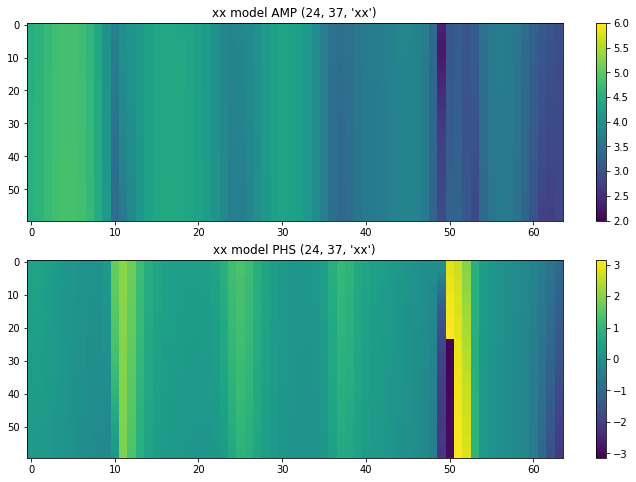

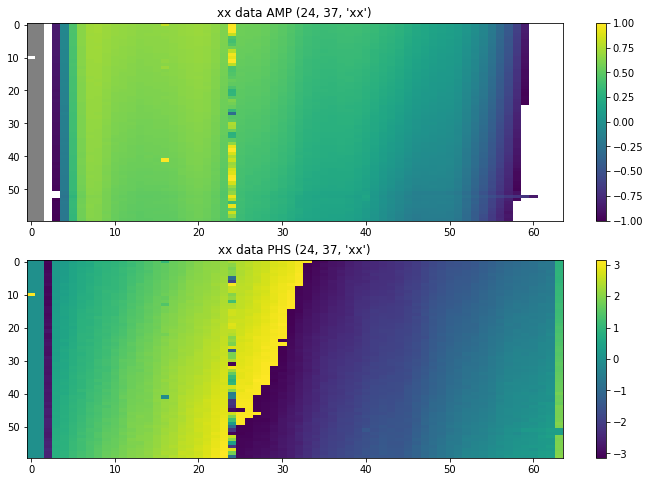

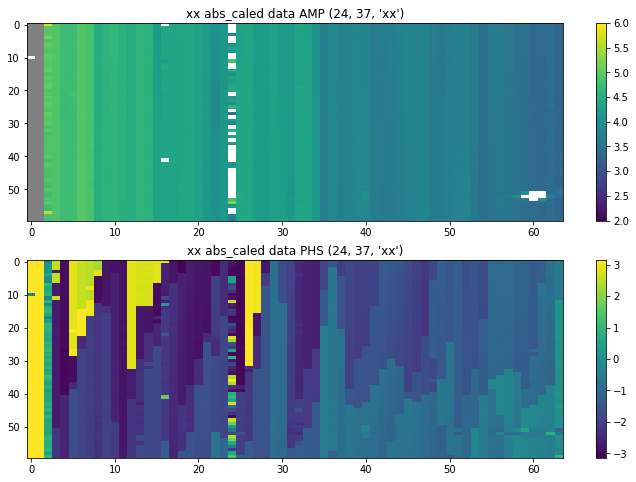

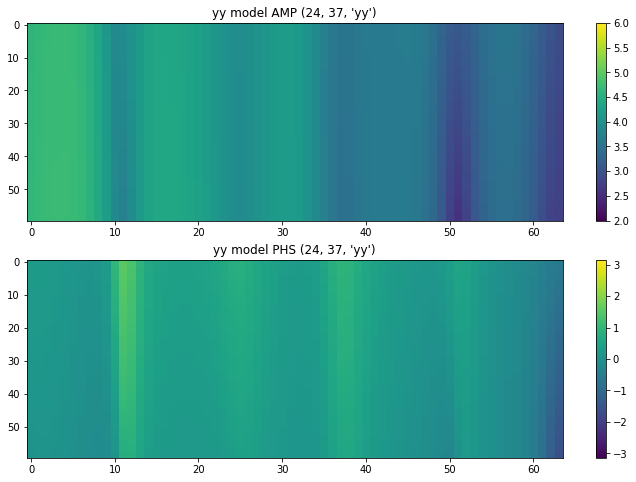

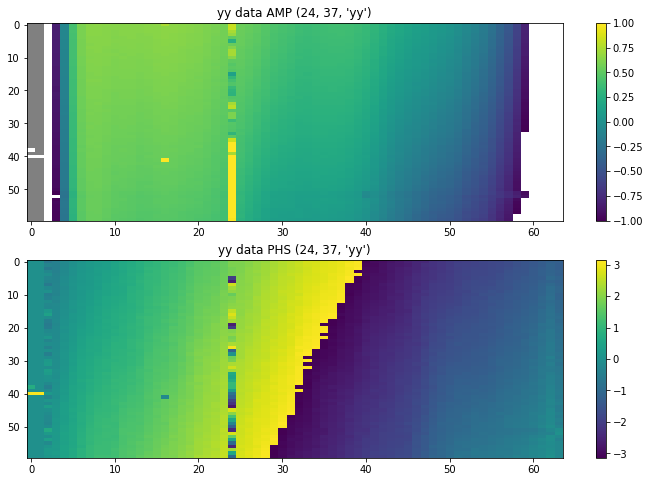

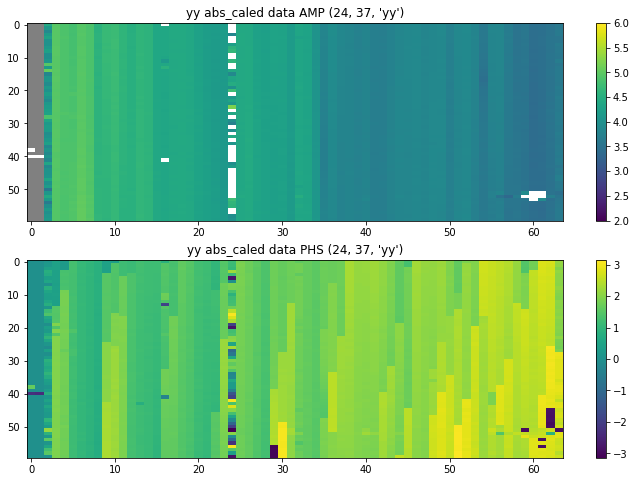

In [162]:
for i in range(2):
	pol = ['xx', 'yy'][i]
	
	if Absolute_Calibration_dred_mfreq:								
		plt.figure(80000000+10*i)
		fig3[i], axes3[i] = plt.subplots(2, 1, figsize=(12, 8))
		plt.sca(axes3[i][0])
		uvt.plot.waterfall(AC_dred_mfreq[i].model[bl_dred_mfreq[i]], mode='log', mx=6, drng=4)
		plt.colorbar()
		plt.title(pol + ' model AMP {}'.format(bl_dred_mfreq[i]))
		plt.sca(axes3[i][1])
		uvt.plot.waterfall(AC_dred_mfreq[i].model[bl_dred_mfreq[i]], mode='phs', mx=np.pi, drng=2*np.pi)
		plt.colorbar()
		plt.title(pol + ' model PHS {}'.format(bl_dred_mfreq[i]))
		plt.show(block=False)			
		#plt.cla()
			
		plt.figure(90000000+10*i)
		fig3_data[i], axes3_data[i] = plt.subplots(2, 1, figsize=(12, 8))
		plt.sca(axes3_data[i][0])
		uvt.plot.waterfall(data_dred_mfreq[i][bl_dred_mfreq[i]], mode='log', mx=1, drng=2)
		plt.colorbar()
		plt.title(pol + ' data AMP {}'.format(bl_dred_mfreq[i]))
		plt.sca(axes3_data[i][1])
		uvt.plot.waterfall(data_dred_mfreq[i][bl_dred_mfreq[i]], mode='phs', mx=np.pi, drng=2*np.pi)
		plt.colorbar()
		plt.title(pol + ' data PHS {}'.format(bl_dred_mfreq[i]))
		plt.show(block=False)
		#plt.cla()		
			
		####################### after ABS Calibration #########################	
		plt.figure(8000000+10*i)
		fig3_data_abscorr[i], axes3_data_abscorr[i] = plt.subplots(2, 1, figsize=(12, 8))
		plt.sca(axes3_data_abscorr[i][0])
		uvt.plot.waterfall(abs_corr_data_dred_mfreq[i][bl_dred_mfreq[i]], mode='log', mx=6, drng=4)
		plt.colorbar()
		plt.title(pol + ' abs_caled data AMP {}'.format(bl_dred_mfreq[i]))
		plt.sca(axes3_data_abscorr[i][1])
		uvt.plot.waterfall(abs_corr_data_dred_mfreq[i][bl_dred_mfreq[i]], mode='phs', mx=np.pi, drng=2*np.pi)
		plt.colorbar()
		plt.title(pol + ' abs_caled data PHS {}'.format(bl_dred_mfreq[i]))
		plt.show(block=False)
		#plt.cla()


In [163]:
for i in range(2):	
	if Absolute_Calibration_dred:
		# instantiate class
		#AC_dred[i] = hc.abscal.AbsCal(model_dred[i], data_dred[i], antpos=antpos[i], wgts=wgts_dred[i], freqs=freq_to_cal)
		# kernel is median filter kernel, chosen to produce time-smooth output delays for this particular dataset
		AC_dred[i].delay_lincal(kernel=(1, 3), medfilt=True, time_avg=True, solve_offsets=True)
		# apply to data
		delay_corr_data_dred[i] = hc.abscal.apply_gains(AC_dred[i].data, (AC_dred[i].ant_dly_gain))
		# instantiate class
		DAC_dred[i] = hc.abscal.AbsCal(model_dred[i], data_dred[i], antpos=antpos[i], wgts=wgts_dred[i], freqs=freq_to_cal)
		# avg phase solver
		DAC_dred[i].phs_logcal(avg=True)
		# apply to data
		dly_phs_corr_data_dred[i] = hc.abscal.apply_gains(DAC_dred[i].data, (DAC_dred[i].ant_phi_gain))
		# instantiate class
		DPAC_dred[i] = hc.abscal.AbsCal(model_dred[i], dly_phs_corr_data_dred[i], antpos=antpos[i], wgts=wgts_dred[i], freqs=freq_to_cal)
		# run amp linsolve
		DPAC_dred[i].abs_amp_logcal()
		# run phs linsolve
		DPAC_dred[i].TT_phs_logcal(zero_psi=False, four_pol=False)
		# apply to data
		abs_corr_data_dred[i] = hc.abscal.apply_gains(DPAC_dred[i].data, 
								(DPAC_dred[i].abs_psi_gain, DPAC_dred[i].TT_Phi_gain, DPAC_dred[i].abs_eta_gain), gain_convention='multiply')
		
		
		plt.figure(60000000+10*i)
		fig2[i], axes2[i] = plt.subplots(2, 1, figsize=(12, 8))
		if len(freq_to_cal) >= 2:
			plt.sca(axes2[i][0])
			uvt.plot.waterfall(AC_dred[i].model[bl_dred], mode='log', mx=4, drng=2)
			plt.colorbar()
			plt.title(pol + ' model AMP {}'.format(bl_dred))
			plt.sca(axes2[i][1])
			uvt.plot.waterfall(AC_dred[i].model[bl_dred], mode='phs', mx=np.pi, drng=2*np.pi)
			plt.colorbar()
			plt.title(pol + ' model PHS {}'.format(bl_dred))
			plt.show(block=False)			
		else:
			plt.sca(axes2[i][0])
			plt.plot(np.real(AC_dred[i].model[bl_dred]))
			plt.title(pol + ' model Real {}'.format(bl_dred))
			plt.sca(axes2[i][1])
			plt.plot(np.imag(AC_dred[i].model[bl_dred]))
			plt.title(pol + ' model Imag {}'.format(bl_dred))
			plt.show(block=False)
		#plt.cla()
			
		plt.figure(70000000+10*i)
		fig2_data[i], axes2_data[i] = plt.subplots(2, 1, figsize=(12, 8))
		if len(freq_to_cal) >= 2:
			plt.sca(axes2_data[i][0])
			uvt.plot.waterfall(AC_dred[i].data[bl_dred], mode='log', mx=4, drng=2)
			plt.colorbar()
			plt.title(pol + ' data AMP {}'.format(bl_dred))
			plt.sca(axes2_data[i][1])
			uvt.plot.waterfall(AC_dred[i].data[bl_dred], mode='phs', mx=np.pi, drng=2*np.pi)
			plt.colorbar()
			plt.title(pol + ' data PHS {}'.format(bl_dred))
			plt.show(block=False)
		else:
			plt.sca(axes2_data[i][0])
			plt.plot(np.real(AC_dred[i].data[bl_dred]))
			plt.title(pol + ' data Real {}'.format(bl_dred))
			plt.sca(axes2_data[i][1])
			plt.plot(np.imag(AC_dred[i].data[bl_dred]))
			plt.title(pol + ' data Imag {}'.format(bl_dred))
			plt.show(block=False)
		#plt.cla()
			
			
		####################### after ABS Calibration #########################	
		plt.figure(7000000+10*i)
		fig2_data[i], axes2_data[i] = plt.subplots(2, 1, figsize=(12, 8))
		if len(freq_to_cal) >= 2:
			plt.sca(axes2_data[i][0])
			uvt.plot.waterfall(abs_corr_data_dred[i][bl_dred], mode='log', mx=4, drng=2)
			plt.colorbar()
			plt.title(pol + ' data AMP {}'.format(bl_dred))
			plt.sca(axes2_data[i][1])
			uvt.plot.waterfall(abs_corr_data_dred[i][bl_dred], mode='phs', mx=np.pi, drng=2*np.pi)
			plt.colorbar()
			plt.title(pol + ' data PHS {}'.format(bl_dred))
			plt.show(block=False)
		else:
			plt.sca(axes2_data[i][0])
			plt.plot(np.real(abs_corr_data_dred[i][bl_dred]))
			plt.title(pol + ' data Real {}'.format(bl_dred))
			plt.sca(axes2_data[i][1])
			plt.plot(np.imag(abs_corr_data_dred[i][bl_dred]))
			plt.title(pol + ' data Imag {}'.format(bl_dred))
			plt.show(block=False)
		#plt.cla()


In [164]:
################# Noise and Vis Data Loading ##################
if len(tlist) >= 2:
	Time_seperation_real = np.array([3600.*np.abs(tlist[i+1]-tlist[i]) for i in range(len(tlist)-1)]) # in second
elif INSTRUMENT == 'hera47':
	 Time_seperation_real = 11
elif INSTRUMENT == 'miteor':
	Time_seperation_real = 144
Frequency_gap_real = np.array([1.e6*np.abs(flist[0][i+1]-flist[0][i]) for i in range(len(flist[0])-1)]) # Hz

Integration_Time = np.mean(Time_seperation_real)
Frequency_Bin = np.mean(Frequency_gap_real)

Calculate_SimulationData_Noise = True
Calculate_Data_Noise = True

scale_noise = True
#Use_AbsCal = False

noise = {}
noise_data = {}
if Calculate_SimulationData_Noise:
	if Keep_Red:	
		noise['x'] = np.array([np.random.normal(0, autocorr_vis_red[0][t_index]/(Integration_Time*Frequency_Bin)**0.5, nUBL_used) for t_index in range(len(autocorr_vis[0]))],dtype='complex128').flatten()
		noise['y'] = np.array([np.random.normal(0, autocorr_vis_red[1][t_index]/(Integration_Time*Frequency_Bin)**0.5, nUBL_used) for t_index in range(len(autocorr_vis[1]))],dtype='complex128').flatten()
	else:
		noise['x'] = np.array([(np.random.normal(0, autocorr_vis[0][t_index]/(Integration_Time*Frequency_Bin)**0.5, nUBL_used) / np.array(redundancy[0])**0.5) for t_index in range(len(autocorr_vis[0]))],dtype='complex128').flatten()
		noise['y'] = np.array([(np.random.normal(0, autocorr_vis[1][t_index]/(Integration_Time*Frequency_Bin)**0.5, nUBL_used) / np.array(redundancy[1])**0.5) for t_index in range(len(autocorr_vis[1]))],dtype='complex128').flatten()
	
#	N_acu = {}
#	N_acu['x'] = np.outer(noise['x'], noise['x'].T)
#	N_acu['y'] = np.outer(noise['y'], noise['y'].T)
	N = {}
	N['x'] = noise['x'] * noise['x']
	N['y'] = noise['y'] * noise['y']
	
	sim_var_xx_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_var_sim_xx.simvis'%(INSTRUMENT, freq, nUBL_used+1, nt_used, nside_standard, bnside)
	sim_var_yy_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_var_sim_yy.simvis'%(INSTRUMENT, freq, nUBL_used+1, nt_used, nside_standard, bnside)
	N['x'].astype('complex128').tofile(sim_var_xx_filename)
	N['y'].astype('complex128').tofile(sim_var_yy_filename)
	
	Del = True
	if Del:
		del(noise)
		del(N)

if Calculate_Data_Noise:
	if INSTRUMENT == 'miteor':
		noise_data['x'] = (var_data[0].flatten())**0.5
		noise_data['y'] = (var_data[1].flatten())**0.5
		
	elif INSTRUMENT == 'hera47':
		if Keep_Red:
			noise_data['x'] = np.array([np.random.normal(0,autocorr_data[0][t_index]/(Integration_Time*Frequency_Bin)**0.5,nUBL_used) for t_index in range(len(autocorr_data[0]))],dtype='complex128').flatten() # Not Absolute Calibrated
			noise_data['y'] = np.array([np.random.normal(0,autocorr_data[1][t_index]/(Integration_Time*Frequency_Bin)**0.5,nUBL_used) for t_index in range(len(autocorr_data[1]))],dtype='complex128').flatten()
		else:
			if scale_noise:
				if Use_AbsCal:
					noise_data['x'] = np.array([(np.random.normal(0, autocorr_data_dred_abscal[0][t_index]/(Integration_Time*Frequency_Bin) **0.5, nUBL_used) / np.array(redundancy[0])**0.5) for t_index in range(len(autocorr_data_dred_abscal[0]))],dtype='complex128').flatten() # Absolute Calibrated
					noise_data['y'] = np.array([(np.random.normal(0, autocorr_data_dred_abscal[1][t_index]/(Integration_Time*Frequency_Bin) **0.5, nUBL_used) / np.array(redundancy[1])**0.5) for t_index in range(len(autocorr_data_dred_abscal[1]))],dtype='complex128').flatten()
				else:
					noise_data['x'] = np.array([(np.random.normal(0, autocorr_data[0][t_index]/(Integration_Time*Frequency_Bin)**0.5, nUBL_used) / np.array(redundancy[0])**0.5) for t_index in range(len(autocorr_data[0]))],dtype='complex128').flatten() # Absolute Calibrated
					noise_data['y'] = np.array([(np.random.normal(0, autocorr_data[1][t_index]/(Integration_Time*Frequency_Bin)**0.5, nUBL_used) / np.array(redundancy[1])**0.5) for t_index in range(len(autocorr_data[1]))],dtype='complex128').flatten()
			else:
				if Use_AbsCal:
					noise_data['x'] = np.array([(np.random.normal(0, autocorr_data_dred_abscal[0][t_index]/(Integration_Time*Frequency_Bin)**0.5, nUBL_used) ) for t_index in range(len(autocorr_data_dred_abscal[0]))],dtype='complex128').flatten() # Absolute Calibrated
					noise_data['y'] = np.array([(np.random.normal(0, autocorr_data_dred_abscal[1][t_index]/(Integration_Time*Frequency_Bin)**0.5, nUBL_used) ) for t_index in range(len(autocorr_data_dred_abscal[1]))],dtype='complex128').flatten()
				else:
					noise_data['x'] = np.array([(np.random.normal(0, autocorr_data[0][t_index]/(Integration_Time*Frequency_Bin)**0.5, nUBL_used) ) for t_index in range(len(autocorr_data[0]))],dtype='complex128').flatten() # Absolute Calibrated
					noise_data['y'] = np.array([(np.random.normal(0, autocorr_data[1][t_index]/(Integration_Time*Frequency_Bin)**0.5, nUBL_used) ) for t_index in range(len(autocorr_data[1]))],dtype='complex128').flatten()
						
#	N_data_acu = {}
#	N_data_acu['x'] = np.outer(noise_data['x'], noise_data['x'].T)
#	N_data_acu['y'] = np.outer(noise_data['y'], noise_data['y'].T)
	N_data = {}
	N_data['x'] = noise_data['x'] * noise_data['x']
	N_data['y'] = noise_data['y'] * noise_data['y']
	
	Store_Data_Noise = True

	if Store_Data_Noise:
		data_var_xx_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_var_data_xx.simvis'%(INSTRUMENT, freq, nUBL_used+1, nt_used, nside_standard, bnside)
		data_var_yy_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_var_data_yy.simvis'%(INSTRUMENT, freq, nUBL_used+1, nt_used, nside_standard, bnside)
		N_data['x'].astype('complex128').tofile(data_var_xx_filename)
		N_data['y'].astype('complex128').tofile(data_var_yy_filename)
	
	Del = True
	if Del:
		del(noise_data)
		#del(N_data)
#		try:
#			del(autocorr_data)
#		except:
#			pass

sys.stdout.flush()


In [165]:
######################
####simulate cas and cyg
#######################
southern_points = {'hyd':{'ra': '09:18:05.7', 'dec': '-12:05:44'},
'cen':{'ra': '13:25:27.6', 'dec': '-43:01:09'},
'cyg':{'ra': '19:59:28.3', 'dec': '40:44:02'},
'pic':{'ra': '05:19:49.7', 'dec': '-45:46:44'},
'vir':{'ra': '12:30:49.4', 'dec': '12:23:28'},
'for':{'ra': '03:22:41.7', 'dec': '-37:12:30'},
'sag':{'ra': '17:45:40.045', 'dec': '-29:0:27.9'},
'cas':{'ra': '23:23:26', 'dec': '58:48:00'},
'crab':{'ra': '5:34:31.97', 'dec': '22:00:52.1'}}


for source in southern_points.keys():
	southern_points[source]['body'] = ephem.FixedBody()
	southern_points[source]['body']._ra = southern_points[source]['ra']
	southern_points[source]['body']._dec = southern_points[source]['dec']

flux_func = {}
#flux_func['cas'] = si.interp1d(np.loadtxt('/home/omniscope/data/point_source_flux/casA2013.5out')[:,1], np.loadtxt('/home/omniscope/data/point_source_flux/casA2013.5out')[:,2])
#flux_func['cyg'] = si.interp1d(np.loadtxt('/home/omniscope/data/point_source_flux/cygA2006out')[:,1], np.loadtxt('/home/omniscope/data/point_source_flux/cygA2006out')[:,2])
flux_func['cas'] = si.interp1d(flist[0], np.array([S_casa_v_t(flist[0][i], DecimalYear) for i in range(len(flist[0]))]))
flux_func['cyg'] = si.interp1d(flist[0], np.array([S_cyga_v(flist[0][i], DecimalYear) for i in range(len(flist[0]))]))


pt_sources = ['cyg', 'cas']
pt_vis = np.zeros((len(pt_sources), 2, nUBL_used, nt_used), dtype='complex128')
if INSTRUMENT == 'miteor':
	print "Simulating cyg casvisibilities, %s, expected time %.1f min"%(datetime.datetime.now(), 14.6 * (nUBL_used / 78.) * (nt_used / 193.) * (2. / 1.4e5)),
	sys.stdout.flush()
	timer = time.time()
	for p, beam_heal_equ in enumerate([beam_heal_equ_x, beam_heal_equ_y]):
		for i, source in enumerate(pt_sources):
			ra = southern_points[source]['body']._ra
			dec = southern_points[source]['body']._dec
			pt_vis[i, p] = jansky2kelvin * flux_func[source](freq) * vs.calculate_pointsource_visibility(ra, dec, used_common_ubls, freq, beam_heal_equ=beam_heal_equ, tlist=lsts) / 2
elif INSTRUMENT == 'hera47':
	print "Simulating cyg casvisibilities, %s, expected time %.1f min"%(datetime.datetime.now(), 14.6 * (nUBL_used / 78.) * (nt_used / 193.) * (2. / 1.4e5)),
	sys.stdout.flush()
	timer = time.time()
	for p, beam_heal_equ in enumerate([beam_heal_equ_x, beam_heal_equ_y]):
		for i, source in enumerate(pt_sources):
			ra = southern_points[source]['body']._ra
			dec = southern_points[source]['body']._dec
			pt_vis[i, p] = jansky2kelvin * flux_func[source](freq) * vs.calculate_pointsource_visibility(ra, dec, used_common_ubls, freq, beam_heal_equ=beam_heal_equ, tlist=lsts) / 2



if PointSource_AbsCal:
	vis_freq = {}
	
	autocorr_data_dred_mfreq_pscal = {}
	vis_data_dred_mfreq_pscal = {}
	
	for j, p in enumerate(['x', 'y']):
		pol = p+p
		vis_data_dred_mfreq_pscal[j] = np.zeros_like(vis_data_dred_mfreq_abscal[j])
		autocorr_data_dred_mfreq_pscal[j] = np.zeros_like(autocorr_data_dred_mfreq_abscal[j])
	
	for id_f in range(len(flist[0])):
		vis_freq[0] = flist[0][id_f]
		vis_freq[1] = flist[1][id_f]
		cal_lst_range = np.array([5, 6]) / TPI * 24.
		calibrate_ubl_length = 1600 / np.mean([vis_freq[0], vis_freq[1]]) #10.67
		cal_time_mask = tmask	 #(tlist>cal_lst_range[0]) & (tlist<cal_lst_range[1])#a True/False mask on all good data to get good data in cal time range
		#cal_ubl_mask = {}
		
		
		Ni = {}
		cubls = copy.deepcopy(ubls)
		ubl_sort = {}
		noise_data_pscal = {}
		N_data_pscal = {}
		vis_data_dred_pscal = {}
		
		From_AbsCal = False
		
		for i, p in enumerate(['x', 'y']):
			pol = p+p
			cal_ubl_mask = np.linalg.norm(ubls[p], axis=1) >= calibrate_ubl_length
			#get Ni (1/variance) and data
			#var_filename = datadir + tag + '_%s%s_%i_%i%s.var'%(p, p, nt, nUBL, vartag)
			#noise_data_pscal['y'] = np.array([(np.random.normal(0,autocorr_data[1][t_index]/(Integration_Time*Frequency_Bin)**0.5,nUBL_used) ) for t_index in range(len(autocorr_data[1]))],dtype='complex128').flatten()
			
			if From_AbsCal:
				vis_data_dred_pscal[i] = vis_data_dred_mfreq_abscal[i][id_f][np.ix_(cal_time_mask, cal_ubl_mask)].transpose()
				noise_data_pscal[p] = np.array([(np.random.normal(0,autocorr_data_dred_mfreq_abscal[i][t_index, id_f]/(Integration_Time*Frequency_Bin)**0.5, nUBL) ) for t_index in range(len(autocorr_data[i]))],dtype='complex128').flatten() # Absolute Calibrated
			else:
				vis_data_dred_pscal[i] = vis_data_dred_mfreq[i][id_f][np.ix_(cal_time_mask, cal_ubl_mask)].transpose()
				noise_data_pscal[p] = np.array([(np.random.normal(0,autocorr_data_mfreq[i][t_index, id_f]/(Integration_Time*Frequency_Bin)**0.5, nUBL) ) for t_index in range(len(autocorr_data[i]))],dtype='complex128').flatten() # Absolute Calibrated
				
			N_data_pscal[p] = noise_data_pscal[p] * noise_data_pscal[p]
			#N_data_pscal['y'] = noise_data_pscal['y'] * noise_data_pscal['y']
			Ni[p] = 1./N_data_pscal[p].reshape((nt, nUBL))[np.ix_(cal_time_mask, cal_ubl_mask)].transpose()
			ubls[p] = ubls[p][cal_ubl_mask]
			ubl_sort[p] = np.argsort(la.norm(ubls[p], axis=1))

			print "%i UBLs to include"%len(ubls[p])
		
		del(noise_data_pscal)
		
		print "Computing UNpolarized point sources matrix..."
		sys.stdout.flush()
		cal_sources = ['cyg', 'cas']
		Apol = np.empty((np.sum(cal_ubl_mask), 2, np.sum(cal_time_mask), len(cal_sources)), dtype='complex128')
		timer = time.time()
		for n, source in enumerate(cal_sources):
			ra = southern_points[source]['body']._ra
			dec = southern_points[source]['body']._dec

			Apol[:, 0, :, n] = vs.calculate_pointsource_visibility(ra, dec, ubls[p], vis_freq[0], beam_heal_equ=beam_heal_equ_x_mfreq[id_f], tlist=lsts[cal_time_mask])
			Apol[:, 1, :, n] = vs.calculate_pointsource_visibility(ra, dec, ubls[p], vis_freq[1], beam_heal_equ=beam_heal_equ_y_mfreq[id_f], tlist=lsts[cal_time_mask])

		Apol = np.conjugate(Apol).reshape((np.sum(cal_ubl_mask), 2 * np.sum(cal_time_mask), len(cal_sources)))
		Ni = np.transpose([Ni['x'], Ni['y']], (1, 0, 2))

		realA = np.zeros((2 * Apol.shape[0] * Apol.shape[1], 1 + 2 * np.sum(cal_ubl_mask) * 2), dtype='complex128')
		realA[:, 0] = np.concatenate((np.real(Apol.reshape((Apol.shape[0] * Apol.shape[1], Apol.shape[2]))), np.imag(Apol.reshape((Apol.shape[0] * Apol.shape[1], Apol.shape[2])))), axis=0).dot([jansky2kelvin_mfreq[0][id_f] * flux_func[source](vis_freq[0]) for source in cal_sources])
		vis_scale = la.norm(realA[:, 0]) / len(realA)**.5
		for coli, ncol in enumerate(range(1, realA.shape[1])):
			realA[coli * np.sum(cal_time_mask): (coli + 1) * np.sum(cal_time_mask), ncol] = vis_scale

		realNi = np.concatenate((Ni.flatten() * 2, Ni.flatten() * 2))
		realAtNiAinv = np.linalg.pinv(np.einsum('ji,j,jk->ik', realA, realNi, realA))


		b = np.transpose([vis_data_dred_pscal[0], vis_data_dred_pscal[1]], (1, 0, 2))
		phase_degen_niter = 0
		phase_degen2 = {'x': np.zeros(2), 'y': np.zeros(2)}
		phase_degen_iterative_x = np.zeros(2)
		phase_degen_iterative_y = np.zeros(2)
		def tocomplex(realdata):
			reshapedata = realdata.reshape((2, np.sum(cal_ubl_mask), 2, np.sum(cal_time_mask)))
			return reshapedata[0] + reshapedata[1] * 1.j

		phase_degen_niter_max = 100
		while (phase_degen_niter < phase_degen_niter_max and max(np.linalg.norm(phase_degen_iterative_x), np.linalg.norm(phase_degen_iterative_y)) > 1e-5) or phase_degen_niter == 0:
			phase_degen_niter += 1
			b[:, 0] = b[:, 0] * np.exp(1.j * ubls['x'][:, :2].dot(phase_degen_iterative_x))[:, None]
			b[:, -1] = b[:, -1] * np.exp(1.j * ubls['y'][:, :2].dot(phase_degen_iterative_y))[:, None]
			realb = np.concatenate((np.real(b.flatten()), np.imag(b.flatten())))

			psol = realAtNiAinv.dot(np.transpose(realA).dot(realNi * realb))
			realb_fit = realA.dot(psol)
			perror = ((realb_fit - realb) * (realNi**.5)).reshape((2, np.sum(cal_ubl_mask), 2, np.sum(cal_time_mask)))

			realbfit_noadditive = realA[:, 0] * psol[0]
			realbfit_additive = realb_fit - realbfit_noadditive
			realb_noadditive = realb - realbfit_additive
			bfit_noadditive = tocomplex(realbfit_noadditive)
			b_noadditive = tocomplex(realb_noadditive)
			if phase_degen_niter == phase_degen_niter_max:
				phase_degen_iterative_x = solve_phase_degen(np.transpose(b_noadditive[:, 0]), np.transpose(b_noadditive[:, 0]), np.transpose(bfit_noadditive[:, 0]), np.transpose(bfit_noadditive[:, 0]), ubls['x'])#, [3, 3, 1e3])
				phase_degen_iterative_y = solve_phase_degen(np.transpose(b_noadditive[:, -1]), np.transpose(b_noadditive[:, -1]), np.transpose(bfit_noadditive[:, -1]), np.transpose(bfit_noadditive[:, -1]), ubls['y'])#, [3, 3, 1e3])

			else:
				phase_degen_iterative_x = solve_phase_degen(np.transpose(b_noadditive[:, 0]), np.transpose(b_noadditive[:, 0]), np.transpose(bfit_noadditive[:, 0]), np.transpose(bfit_noadditive[:, 0]), ubls['x'])
				phase_degen_iterative_y = solve_phase_degen(np.transpose(b_noadditive[:, -1]), np.transpose(b_noadditive[:, -1]), np.transpose(bfit_noadditive[:, -1]), np.transpose(bfit_noadditive[:, -1]), ubls['y'])
			phase_degen2['x'] += phase_degen_iterative_x
			phase_degen2['y'] += phase_degen_iterative_y
			print phase_degen_niter, phase_degen2['x'], phase_degen2['y'], np.linalg.norm(perror)

		renorm = 1 / (2 * psol[0])

		print (renorm, vis_freq[0],  phase_degen2['x'], vis_freq[1], phase_degen2['y'])

		#freqs[fi] = vis_freq

		################################# apply to data and var and output unpolarized version ####################################
		data_var_xx_filename_pscal = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_var_data_xx_pscal.simvis'%(INSTRUMENT, freq, nUBL, nt, nside_standard, bnside)
		data_var_yy_filename_pscal = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_var_data_yy_pscal.simvis'%(INSTRUMENT, freq, nUBL, nt, nside_standard, bnside)
		
		#vis_data_dred_pscal = {}
		#N_data_pscal = {}
		
		######### recover ubls and ubl_sort ##########
		ubls = cubls
		#ubl_sort = cubl_sort
		
		if Keep_Red:
			nUBL = len(bsl_coord_x)
			for p in ['x', 'y']:
				#ubl_filename = datadir + tag + '_%s%s_%i_%i.ubl' % (p, p, nUBL, 3)
				ubls[p] = globals()['bsl_coord_' + p]
			common_ubls = np.array([u for u in ubls['x'] if (u in ubls['y'] or -u in ubls['y'])])
			
		else:
			nUBL = len(bsl_coord_dred[0])
			nUBL_yy = len(bsl_coord_dred[1])
			for i in range(2):
				p = ['x', 'y'][i]
				ubls[p] = bsl_coord_dred[i]
			common_ubls = np.array([u for u in ubls['x'] if (u in ubls['y'] or -u in ubls['y'])])
		
		#get data and var and apply change
		
		for j, p in enumerate(['x', 'y']):
			pol = p+p

			if From_AbsCal:
				vis_data_dred_mfreq_pscal[j][id_f] = vis_data_dred_mfreq_abscal[j][id_f] * np.exp(1.j * ubls[p][:, :2].dot(phase_degen2[p])) * renorm
				if comply_ps2mod_autocorr:
					autocorr_data_dred_mfreq_pscal[j][:, id_f] = autocorr_vis_mfreq[j][:, id_f]
				else:
					autocorr_data_dred_mfreq_pscal[j][:, id_f] = autocorr_data_dred_mfreq_abscal[j][:, id_f] * np.abs(renorm)  # Absolute Calibrated
			else:
				vis_data_dred_mfreq_pscal[j][id_f] = vis_data_dred_mfreq[j][id_f] * np.exp(1.j * ubls[p][:, :2].dot(phase_degen2[p])) * renorm
				if comply_ps2mod_autocorr:
					autocorr_data_dred_mfreq_pscal[j][:, id_f] = autocorr_vis_mfreq[j][:, id_f]
				else:
					autocorr_data_dred_mfreq_pscal[j][:, id_f] = autocorr_data_mfreq[j][:, id_f] * np.abs(renorm) # Absolute Calibrated
		
		
	noise_data_pscal = {}
	N_data_pscal = {}
	vis_data_dred_pscal = {}
	for i, p in enumerate(['x', 'y']):
		pol = p+p
#		data_filename = glob.glob(datadir + tag + '_%s%s_*_*'%(p, p) + datatag)[0]
#		nt_nUBL = os.path.basename(data_filename).split(datatag)[0].split('%s%s_'%(p, p))[-1]
#		nt = int(nt_nUBL.split('_')[0])
#		nUBL = int(nt_nUBL.split('_')[1])
#		var_filename = datadir + tag + '_%s%s_%i_%i%s.var'%(p, p, nt, nUBL, vartag)
#
#		op_data_filename = datadir + tag + '_%s%s_%i_%i%s'%(p, p, nt, nUBL, dataoptag)
#		op_var_filename = datadir + tag + '_%s%s_%i_%i%s.var'%(p, p, nt, nUBL, varoptag)
#		op_var100_filename = datadir + tag + '_%s%s_%i_%i%s.var'%(p, p, nt, nUBL, varoptag+'x100')

		#ubl file
		#ubl_filename = datadir + tag + '_%s%s_%i_%i.ubl'%(p, p, nUBL, 3)
		#ubls = np.fromfile(ubl_filename, dtype='float32').reshape((nUBL, 3))
		
#		if From_AbsCal:
#			vis_data_dred_pscal[i] = vis_data_dred_abscal[i] * np.exp(1.j * ubls[p][:, :2].dot(phase_degen2[p])) * renorm
#			noise_data_pscal[p] = np.array([(np.random.normal(0,autocorr_data_dred_abscal[i][t_index]/(Integration_Time*Frequency_Bin)**0.5, nUBL) ) for t_index in range(len(autocorr_data[i]))],dtype='complex128').flatten() # Absolute Calibrated
#		else:
#			vis_data_dred_pscal[i] = vis_data_dred[i] * np.exp(1.j * ubls[p][:, :2].dot(phase_degen2[p])) * renorm
#			noise_data_pscal[p] = np.array([(np.random.normal(0,autocorr_data[i][t_index]/(Integration_Time*Frequency_Bin)**0.5, nUBL) ) for t_index in range(len(autocorr_data[i]))],dtype='complex128').flatten() # Absolute Calibrated
		
		vis_data_dred_pscal[i] = vis_data_dred_mfreq_pscal[i][index_freq[i]]
		noise_data_pscal[p] = np.array([(np.random.normal(0, autocorr_data_dred_mfreq_pscal[i][t_index, index_freq[i]]/ (Integration_Time*Frequency_Bin)**0.5, nUBL)/ np.array(redundancy[i])**0.5 ) for t_index in range(len(autocorr_data_dred_mfreq_pscal[i]))],dtype='complex128').flatten() # Absolute Calibrated
		
#		if From_AbsCal:
#			vis_data_dred_pscal[i] = vis_data_dred_mfreq_pscal[i][index_freq[i]]
#			noise_data_pscal[p] = np.array([(np.random.normal(0,autocorr_data_dred_mfreq_pscal[i][t_index, index_freq[i]]/(Integration_Time*Frequency_Bin)**0.5, nUBL) ) for t_index in range(len(autocorr_data_dred_mfreq_pscal[i]))],dtype='complex128').flatten() # Absolute Calibrated
#		else:
#			vis_data_dred_pscal[i] = vis_data_dred_mfreq_pscal[i][index_freq[i]]
#			noise_data_pscal[p] = np.array([(np.random.normal(0,autocorr_data_dred_mfreq_pscal[i][t_index, index_freq[i]]/(Integration_Time*Frequency_Bin)**0.5, nUBL) ) for t_index in range(len(autocorr_data_dred_mfreq_pscal[i]))],dtype='complex128').flatten() # Absolute Calibrated
					
		N_data_pscal[p] = noise_data_pscal[p] * noise_data_pscal[p]
		N_data_pscal[p] = N_data_pscal[p].reshape((nt, nUBL))
		
		#save
#		if os.path.isfile(op_data_filename) and not overwrite:
#			raise IOError(op_data_filename + ' exists.')
#		else:
#			new_data.astype('complex128').tofile(op_data_filename)

		N_data_pscal[p].astype('complex128').tofile(globals()['data_var_' + pol + '_filename_pscal'])
		#(new_var * 100.).astype('float32').tofile(op_var100_filename)
	del(noise_data_pscal)


Simulating cyg casvisibilities, 2018-03-07 17:33:25.571007, expected time 0.0 min 6 UBLs to include
6 UBLs to include
Computing UNpolarized point sources matrix...
1 [-0.00128442  0.00116148] [0.0023708 0.0020876] 2.4171332902120675
2 [-0.00256884  0.00232296] [0.00467708 0.00453097] 2.417157181599729
3 [-0.00385326  0.00348443] [0.00691239 0.00746678] 2.417191554851042
4 [-0.00513768  0.00464591] [0.00906609 0.01114449] 2.4172388769054853
5 [-0.0064221   0.00580739] [0.01111933 0.01603345] 2.417303098444025
6 [-0.00770652  0.00696887] [0.01303386 0.02347534] 2.4173904708242997
7 [-0.00899094  0.00813035] [0.01470683 0.03728691] 2.41751411162783
8 [-0.01027536  0.00929182] [-0.22952267 -0.0822281 ] 2.4176712049611853
9 [-0.01155978  0.0104533 ] [-0.22771941 -0.08478618] 2.41759700496694
10 [-0.0128442   0.01161478] [-0.22586956 -0.08667079] 2.4175812799500385
11 [-0.01412862  0.01277626] [-0.22399605 -0.08813869] 2.417572635438127
12 [-0.01541304  0.01393774] [-0.22211197 -0.08932977] 

17 [ 0.01198116 -0.00160724] [-3.10019055 -2.20849026] 0.6245240540941781
18 [ 0.01268594 -0.00170178] [-3.28246043 -2.33316593] 0.6245098092590606
19 [ 0.01339071 -0.00179632] [-3.46500005 -2.45856618] 0.6245342909047749
20 [ 0.01409549 -0.00189087] [-3.64722706 -2.583013  ] 0.6245023984964017
21 [ 0.01480026 -0.00198541] [-3.82977398 -2.70838439] 0.6245342014647339
22 [ 0.01550504 -0.00207995] [-4.01204082 -2.83292717] 0.6245115960915701
23 [ 0.01620981 -0.0021745 ] [-4.19441858 -2.95784601] 0.6245239637931311
24 [ 0.01691458 -0.00226904] [-4.37681642 -3.08280701] 0.6245269976013652
25 [ 0.01761936 -0.00236358] [-4.55907353 -3.20735078] 0.6245085051539075
26 [ 0.01832413 -0.00245813] [-4.74163421 -3.33273633] 0.6245352610293126
27 [ 0.01902891 -0.00255267] [-4.92386151 -3.4571299 ] 0.6245032550108576
28 [ 0.01973368 -0.00264721] [-5.10638774 -3.58241375] 0.6245334350293547
29 [ 0.02043846 -0.00274176] [-5.28866905 -3.70698237] 0.6245142823275981
30 [ 0.02114323 -0.0028363 ] [-5.47102

36 [-0.02282875  0.10322046] [-0.27849281 -0.17246586] 50.26416828235031
37 [-0.02265804  0.10412656] [-0.27784545 -0.17266714] 50.2490031278907
38 [-0.02251071  0.10490428] [-0.27721893 -0.17281838] 50.24074308430915
39 [-0.02234043  0.10551418] [-0.27661432 -0.17292088] 50.2384534761933
40 [-0.02214874  0.10600046] [-0.2760289  -0.17298204] 50.23970098437422
41 [-0.02197077  0.10646104] [-0.27546031 -0.17300816] 50.243375300944194
42 [-0.02182361  0.10693634] [-0.27490233 -0.17301186] 50.24995683698381
43 [-0.02170816  0.10742278] [-0.27435031 -0.17300242] 50.25935207543439
44 [-0.0215752   0.10783135] [-0.27380367 -0.17298167] 50.271122933401045
45 [-0.0214222   0.10815352] [-0.27325634 -0.17296047] 50.28323505688988
46 [-0.02125763  0.10841782] [-0.27270953 -0.17294084] 50.29481318036994
47 [-0.02109407  0.1086539 ] [-0.27216327 -0.17292275] 50.30597011845467
48 [-0.02092887  0.10886357] [-0.27161761 -0.17290598] 50.317184420417504
49 [-0.0207604  0.109049 ] [-0.27107086 -0.1728894

51 [0.04282708 0.04335225] [-0.04267836 -0.07682648] 39373.24189469576
52 [0.04348545 0.04421132] [-0.04386824 -0.07831531] 39422.7536006042
53 [0.04413577 0.04506591] [-0.04507562 -0.07980813] 39474.265651155605
54 [0.04478255 0.0459159 ] [-0.04630048 -0.08130519] 39527.08274244725
55 [0.04542992 0.04676299] [-0.04754338 -0.08280707] 39581.3960951279
56 [0.0460776  0.04760854] [-0.04880541 -0.08431467] 39637.37897530084
57 [0.04672334 0.04845016] [-0.05008677 -0.08582842] 39694.907351210015
58 [0.04736594 0.0492873 ] [-0.05138734 -0.08734854] 39753.80228961861
59 [0.04800243 0.05011931] [-0.05270666 -0.08887455] 39813.8635293342
60 [0.04863273 0.05094715] [-0.05404336 -0.09040594] 39874.68765838144
61 [0.04925422 0.05176933] [-0.05539678 -0.09194342] 39936.0331216103
62 [0.04986681 0.05258556] [-0.05676656 -0.09348712] 39997.52402361117
63 [0.05047486 0.05339738] [-0.05815225 -0.09503715] 40058.99014864654
64 [0.051084   0.05420383] [-0.05955601 -0.09659245] 40120.69254757824
65 [0.05

62 [-0.00116853 -0.0753772 ] [ 0.03954096 -0.04322246] 18098.990051419547
63 [-0.00155994 -0.07630476] [ 0.03953653 -0.04363185] 18115.691333965387
64 [-0.00195661 -0.07722265] [ 0.03951555 -0.04403381] 18131.671011390008
65 [-0.00235756 -0.07813216] [ 0.03947815 -0.04442967] 18146.64698523863
66 [-0.00276242 -0.07903414] [ 0.03941987 -0.04482223] 18160.695120280285
67 [-0.00317132 -0.07993009] [ 0.03934114 -0.04521315] 18173.7171873405
68 [-0.0035838  -0.08082038] [ 0.03924917 -0.04560517] 18185.802512296345
69 [-0.00399944 -0.08170538] [ 0.03914553 -0.04599781] 18197.329524220684
70 [-0.00441786 -0.08258543] [ 0.03903464 -0.04638886] 18208.377805101904
71 [-0.00483874 -0.08346085] [ 0.03891724 -0.04677845] 18219.102442033854
72 [-0.00526177 -0.08433196] [ 0.03879356 -0.0471667 ] 18229.552519935343
73 [-0.00568672 -0.08519904] [ 0.03866382 -0.04755371] 18239.75516913221
74 [-0.00611337 -0.08606299] [ 0.03852824 -0.0479396 ] 18249.735842304297
75 [-0.00654239 -0.08692587] [ 0.03838703 

75 [-0.04805656 -0.0577279 ] [0.01390277 0.0798813 ] 59698.32491605866
76 [-0.04878636 -0.05810453] [0.01386765 0.08090276] 59977.91286301768
77 [-0.04952403 -0.05846338] [0.01382462 0.08192342] 60257.76288537637
78 [-0.05026818 -0.05880488] [0.0137732  0.08294365] 60538.56292342622
79 [-0.05103277 -0.05912061] [0.01371487 0.08396034] 60820.35239464203
80 [-0.05180406 -0.05941807] [0.01364836 0.08497517] 61101.45601438354
81 [-0.05257764 -0.05969934] [0.01357324 0.08598827] 61382.58075618737
82 [-0.05335386 -0.05996367] [0.01348851 0.08700072] 61663.63922358189
83 [-0.05413305 -0.06021046] [0.01339555 0.08800936] 61944.97748934979
84 [-0.05491562 -0.06043892] [0.01329487 0.08901259] 62224.97367262807
85 [-0.05570207 -0.06064826] [0.01318519 0.09001181] 62502.76583659562
86 [-0.05649934 -0.06083765] [0.01306488 0.09100895] 62778.88699420049
87 [-0.0573013  -0.06100599] [0.01293241 0.09200554] 63054.125119732766
88 [-0.05812143 -0.06115215] [0.01278806 0.09299992] 63328.936898523454
89 [

88 [-0.02949422 -0.10889859] [-0.01435215 -0.15700515] 27597.638836273316
89 [-0.02953864 -0.10950141] [-0.01461444 -0.15793685] 27598.37150265039
90 [-0.02958034 -0.11009344] [-0.01487427 -0.15885985] 27600.83976826437
91 [-0.02961951 -0.11067447] [-0.0151313 -0.1597754] 27605.123539662287
92 [-0.02965631 -0.11124468] [-0.01538702 -0.16068158] 27611.182320333293
93 [-0.0296909  -0.11180425] [-0.01564247 -0.16157718] 27618.9089406994
94 [-0.02972342 -0.11235338] [-0.01590249 -0.1624625 ] 27628.24697441363
95 [-0.02975399 -0.11289224] [-0.01616541 -0.16334218] 27639.17624642872
96 [-0.02978272 -0.11342103] [-0.01643548 -0.1642094 ] 27651.8202191955
97 [-0.02980971 -0.1139399 ] [-0.01671757 -0.16506377] 27666.20914715598
98 [-0.02983503 -0.11444901] [-0.01701181 -0.16590543] 27682.572015077654
99 [-0.02985876 -0.11494852] [-0.0173125  -0.16673717] 27701.163745542417
100 [-0.02988081 -0.11543883] [-0.01761734 -0.1675633 ] 27722.07828887258
((-196.38723128710447-0j), 109.375, array([-0.029

1 [ 0.00816787 -0.00757377] [ 0.01230757 -0.00322015] 77494.79733171008
2 [ 0.01075879 -0.01302451] [ 0.02082117 -0.00545022] 77312.69842411394
3 [ 0.01237497 -0.01801791] [ 0.02639181 -0.00684314] 77310.98058699281
4 [ 0.01348267 -0.0226103 ] [ 0.0302388 -0.0078285] 77330.16424716871
5 [ 0.014567   -0.02700137] [ 0.03298455 -0.00861762] 77353.95186804929
6 [ 0.01542767 -0.03116002] [ 0.03504027 -0.00954314] 77374.24942701015
7 [ 0.01650393 -0.03588336] [ 0.03647908 -0.01031739] 77389.75073329038
8 [ 0.01748893 -0.04073624] [ 0.03755162 -0.01098237] 77406.22223878214
9 [ 0.01772734 -0.04520545] [ 0.0387005  -0.01241632] 77427.12146674852
10 [ 0.01742347 -0.04954025] [ 0.03950259 -0.01384195] 77438.70897130002
11 [ 0.01694824 -0.05375101] [ 0.04029494 -0.01528803] 77449.26576359117
12 [ 0.0161301  -0.05795467] [ 0.04088477 -0.01686237] 77460.58809344891
13 [ 0.01512018 -0.06200736] [ 0.04148659 -0.01846275] 77469.08511428446
14 [ 0.01401763 -0.06596736] [ 0.04185576 -0.02002981] 77478.3

36 [-0.03773393 -0.05265919] [0.05682279 0.01831081] 37385.48681136152
37 [-0.03910067 -0.05454867] [0.05795048 0.01897668] 37595.335713834014
38 [-0.04050242 -0.05647784] [0.05903839 0.01965821] 37803.138262166
39 [-0.04195252 -0.05846247] [0.06008557 0.02035604] 38008.78530366735
40 [-0.04342547 -0.06048555] [0.06109297 0.02107094] 38212.53081297001
41 [-0.04491354 -0.06253957] [0.0620619  0.02180386] 38413.010745106585
42 [-0.04641522 -0.06462034] [0.06300063 0.02255602] 38609.394975634896
43 [-0.04793153 -0.06672758] [0.0639168 0.0233286] 38801.69774054115
44 [-0.04953152 -0.06886205] [0.06480949 0.02412374] 38989.89531913827
45 [-0.05126279 -0.07103189] [0.06567458 0.02495787] 39174.78700144866
46 [-0.05304596 -0.07324328] [0.06651346 0.02583418] 39356.5327947006
47 [-0.05490384 -0.07549715] [0.06732893 0.02675598] 39532.60517116872
48 [-0.05675337 -0.07778965] [0.06812051 0.02772838] 39702.82793766668
49 [-0.05871955 -0.08012126] [0.06889802 0.02875357] 39864.2122913967
50 [-0.06

48 [-0.01335094  0.02772317] [-0.05563262 -0.09463249] 61544.616003301024
49 [-0.0133393   0.02796262] [-0.0562994  -0.09578935] 61561.95989821903
50 [-0.0133231   0.02819836] [-0.05693199 -0.09691737] 61579.52543199516
51 [-0.01330242  0.02843055] [-0.05753579 -0.0980215 ] 61597.08545898013
52 [-0.01327735  0.02865935] [-0.05812806 -0.09910387] 61614.68428464035
53 [-0.01324795  0.02888492] [-0.05871136 -0.10016615] 61632.58827470113
54 [-0.01321434  0.02910745] [-0.05928651 -0.10120772] 61650.793071766006
55 [-0.01317659  0.0293271 ] [-0.05985354 -0.10222932] 61669.254158609016
56 [-0.01313479  0.02954404] [-0.0604111 -0.1032292] 61687.9231895939
57 [-0.01308902  0.02975866] [-0.06094667 -0.10421018] 61706.7138282991
58 [-0.01303933  0.0299711 ] [-0.06146328 -0.10517778] 61725.37194565548
59 [-0.01298585  0.03018149] [-0.06196816 -0.10613118] 61743.9571524381
60 [-0.01293028  0.03038982] [-0.06246175 -0.10707066] 61762.5619467698
61 [-0.01287269  0.03059602] [-0.0629456  -0.10799456]

22 [0.03995192 0.01580703] [ 0.02186342 -0.09771887] 68388.16307212568
23 [0.04053079 0.01660628] [ 0.0198987  -0.09925829] 68448.06962127858
24 [0.04111576 0.01739693] [ 0.01872707 -0.1007867 ] 68509.39007668736
25 [0.04172016 0.01815645] [ 0.01800217 -0.10225042] 68562.7022320505
26 [0.04243674 0.0188932 ] [ 0.01752454 -0.10361549] 68615.53085895373
27 [0.04319621 0.01961466] [ 0.0171789  -0.10486636] 68676.91042459509
28 [0.04402674 0.02029396] [ 0.01691833 -0.10586347] 68744.87914931876
29 [0.04466607 0.0210161 ] [ 0.01672096 -0.10677247] 68821.11772231685
30 [0.04524288 0.02172817] [ 0.01655674 -0.10759983] 68886.88451576901
31 [0.04578673 0.02241857] [ 0.01612231 -0.10834952] 68951.11962725791
32 [0.04640739 0.02309486] [ 0.01584821 -0.10904488] 69016.8291711738
33 [0.0469434  0.02375724] [ 0.01566474 -0.109664  ] 69092.39760107269
34 [0.04739399 0.02439615] [ 0.01553296 -0.110214  ] 69162.35750186697
35 [0.04780566 0.02501958] [ 0.01543242 -0.11071093] 69225.59838790516
36 [0.04

37 [0.04196561 0.10713129] [-0.02436412  0.07874903] 55992.67597292544
38 [0.0420632  0.10741817] [-0.02436389  0.07874711] 55992.629903619134
39 [0.04213173 0.10766318] [-0.02436383  0.07874566] 55992.57523288928
40 [0.04219588 0.10787384] [-0.02436354  0.07874415] 55992.45807009545
41 [0.04226159 0.10806785] [-0.02436332  0.07874285] 55992.38127935611
42 [0.04234265 0.10820414] [-0.02436326  0.07874188] 55992.344146959986
43 [0.04241366 0.10831074] [-0.02436391  0.07874202] 55992.489917624844
44 [0.04245764 0.10838835] [-0.02436472  0.07874285] 55992.64827650739
45 [0.04249659 0.10844857] [-0.0243652  0.0787437] 55992.72978702309
46 [0.04252883 0.10849679] [-0.02436559  0.07874462] 55992.81620085241
47 [0.04255503 0.10853572] [-0.0243659   0.07874554] 55992.8911251622
48 [0.04257623 0.10856721] [-0.02436613  0.0787464 ] 55992.95280337102
49 [0.04259356 0.108593  ] [-0.0243663   0.07874717] 55993.00287578263
50 [0.04260899 0.10861631] [-0.02436642  0.07874785] 55993.04371659711
51 [0.

89 [-0.05356641 -0.04172297] [ 0.05490651 -0.08319913] 67622.51912592315
90 [-0.05365386 -0.04206074] [ 0.0548988  -0.08318974] 67621.03154047712
91 [-0.05373632 -0.04238067] [ 0.05489032 -0.08318026] 67619.61393498909
92 [-0.05381287 -0.04268835] [ 0.05488155 -0.08317089] 67618.26386650292
93 [-0.05388717 -0.04297992] [ 0.05487249 -0.0831616 ] 67616.87732264213
94 [-0.05395748 -0.04325837] [ 0.05491788 -0.08315242] 67615.62615328963
95 [-0.05402483 -0.04352309] [ 0.05494576 -0.08313859] 67614.45848976867
96 [-0.05409221 -0.0437697 ] [ 0.05509545 -0.08312215] 67613.38052227844
97 [-0.05415826 -0.04399994] [ 0.05519633 -0.08309323] 67612.65736908639
98 [-0.05422638 -0.04421824] [ 0.05526594 -0.08305877] 67612.12654637841
99 [-0.05428917 -0.04443547] [ 0.05531545 -0.08302299] 67611.82331918374
100 [-0.05435107 -0.04464588] [ 0.05535061 -0.08298768] 67611.34639841509
((-339.6737842584663-0j), 121.875, array([-0.05435107, -0.04464588]), 121.875, array([ 0.05535061, -0.08298768]))
9 UBLs to

17 [ 0.0433395  -0.00105204] [-0.01675557  0.02291687] 63439.66257557415
18 [ 0.04447332 -0.00086819] [-0.01650229  0.02322949] 63424.24075961584
19 [ 0.04548585 -0.00067679] [-0.01629795  0.0235322 ] 63410.00204755433
20 [ 0.04632496 -0.0004199 ] [-0.01612806  0.02382253] 63396.9747494803
21 [ 0.04695111 -0.00010914] [-0.01597642  0.02410387] 63385.50778518013
22 [0.04742173 0.0002027 ] [-0.01584335  0.02437307] 63376.329331168374
23 [0.04779121 0.00048773] [-0.01571571  0.02462394] 63369.06800769033
24 [0.04808768 0.00073721] [-0.01559005  0.02485515] 63363.313498765594
25 [0.04832746 0.00094946] [-0.01546901  0.02506965] 63358.787178499646
26 [0.0485361 0.0011325] [-0.01535234  0.02527051] 63355.26847097508
27 [0.04872871 0.00129182] [-0.01524054  0.02545941] 63352.354638894816
28 [0.04890404 0.00143383] [-0.01513389  0.02563751] 63349.79434128006
29 [0.04905293 0.00155895] [-0.01503246  0.0258057 ] 63347.552409031814
30 [0.04918041 0.00166622] [-0.01493642  0.0259695 ] 63345.751663

30 [ 0.05013238 -0.11924891] [0.26446737 0.20683872] 42165.33428730309
31 [ 0.05011813 -0.12146603] [0.26541943 0.20693549] 42172.260130670285
32 [ 0.05046426 -0.12337025] [0.26640027 0.20693991] 42177.05955384261
33 [ 0.05124271 -0.12525076] [0.26725885 0.20657725] 42180.79071399693
34 [ 0.05178964 -0.12566541] [0.2679082  0.20546444] 42183.72331775593
35 [ 0.05187107 -0.12671878] [0.26821189 0.20404772] 42184.866391685064
36 [ 0.05125941 -0.12810377] [0.27381377 0.21300581] 42185.62353467943
37 [ 0.05098777 -0.12887504] [0.27435822 0.2128733 ] 42185.78742349764
38 [-0.07492107 -0.03711099] [0.11342742 0.24355569] 42185.76879157016
39 [-0.06510635 -0.03354041] [0.11491463 0.24385448] 42170.85479618501
40 [-0.0644019  -0.03222668] [0.11468164 0.24355449] 42179.38958926555
41 [-0.06442113 -0.03275329] [0.11469138 0.24336624] 42177.94173310302
42 [-0.06443303 -0.03254637] [0.11463847 0.24338736] 42178.7792027965
43 [-0.06441433 -0.03266449] [0.11465214 0.2433646 ] 42178.38724977369
44 [-

94 [-0.16023109  0.08059102] [0.02822467 0.07154955] 61554.863610461216
95 [-0.16021751  0.08058718] [0.02902206 0.07251822] 61554.44603328548
96 [-0.16020579  0.08058459] [0.02980811 0.07346669] 61554.133949407995
97 [-0.16019564  0.08058298] [0.03055643 0.07435758] 61553.8745766105
98 [-0.16018688  0.08058222] [0.03127677 0.07517806] 61553.68634090291
99 [-0.16017954  0.08058231] [0.03196914 0.07597365] 61553.61475258781
100 [-0.16017332  0.08058303] [0.03266878 0.07677806] 61553.557085064254
((-122.7465417251287-0j), 128.125, array([-0.16017332,  0.08058303]), 128.125, array([0.03266878, 0.07677806]))
9 UBLs to include
9 UBLs to include
Computing UNpolarized point sources matrix...
1 [-0.00218472  0.00256518] [ 0.00070582 -0.00110478] 48252.95307053489
2 [-0.00419129  0.00507873] [ 0.00136021 -0.00217905] 47363.82115266344
3 [-0.00604776  0.00755087] [ 0.00198406 -0.00323279] 46657.03313586387
4 [-0.0077512   0.00998265] [ 0.00262071 -0.00429184] 46107.48275854768
5 [-0.00930965  0.

1 [ 0.00176546 -0.0007555 ] [-0.00087775 -0.00269278] 51548.21939956605
2 [ 0.00377357 -0.00179294] [-0.00168569 -0.00545451] 51616.998205900694
3 [ 0.00613043 -0.0031782 ] [-0.00238652 -0.00833526] 51696.55552950665
4 [ 0.00865546 -0.00485349] [-0.00297285 -0.01135623] 51788.1667169635
5 [ 0.01140571 -0.00694655] [-0.00338205 -0.01457122] 51882.06488435899
6 [ 0.01441615 -0.00951992] [-0.00387454 -0.01781486] 51978.14603853335
7 [ 0.01792295 -0.01278104] [-0.00466536 -0.02094412] 52062.26244281655
8 [ 0.02153672 -0.01641383] [-0.00612633 -0.02370055] 52127.20055638916
9 [ 0.02526801 -0.02075185] [-0.00772188 -0.0262774 ] 52156.723675800844
10 [ 0.02886705 -0.0254183 ] [-0.00917725 -0.02879106] 52165.75179199362
11 [ 0.03208204 -0.03018007] [-0.01047528 -0.0312154 ] 52159.53064053687
12 [ 0.03462619 -0.03451346] [-0.01160029 -0.03353338] 52139.624097475134
13 [ 0.0363866  -0.03826281] [-0.01208383 -0.03602117] 52114.93365483562
14 [ 0.03759044 -0.04153008] [-0.0115622  -0.03894081] 521

13 [-0.00323712  0.01416512] [0.00660824 0.00152896] 27665.013131139567
14 [-0.00335624  0.0152413 ] [0.00713578 0.00163685] 27689.979576029353
15 [-0.00345645  0.01631552] [0.00766728 0.00174422] 27715.558318348678
16 [-0.00353372  0.01738072] [0.00820156 0.00185095] 27741.42875922863
17 [-0.00358916  0.01843844] [0.00873795 0.00195598] 27766.627017478517
18 [-0.00362564  0.01949352] [0.00927553 0.00205938] 27791.07942304519
19 [-0.00364311  0.02054586] [0.00981409 0.00216168] 27815.114616755436
20 [-0.00363978  0.02159238] [0.01035391 0.0022633 ] 27838.511076384588
21 [-0.00361477  0.02263127] [0.01089479 0.0023649 ] 27860.67627025509
22 [-0.0035678   0.02366167] [0.01143849 0.00246743] 27881.18420378379
23 [-0.00349689  0.02467968] [0.01198425 0.00257096] 27899.66625630111
24 [-0.00340374  0.02568741] [0.01253252 0.0026747 ] 27915.460549520976
25 [-0.00329236  0.02669099] [0.01308261 0.00277797] 27928.688412439038
26 [-0.00316256  0.02768948] [0.01363199 0.00288056] 27940.0995616262

29 [0.01131579 0.01837691] [0.00360876 0.0061691 ] 24438.329816578822
30 [0.01138808 0.01880102] [0.00376315 0.00633708] 24362.636792937617
31 [0.01145051 0.01921481] [0.00391683 0.00650536] 24287.25355665024
32 [0.01150373 0.01961858] [0.00407149 0.00667105] 24212.211437239763
33 [0.01154886 0.0200117 ] [0.00422712 0.006834  ] 24137.43174008116
34 [0.01158742 0.02039279] [0.00438355 0.00699422] 24063.148963254298
35 [0.01161985 0.02076231] [0.00454032 0.0071523 ] 23989.78739575835
36 [0.01164655 0.02112071] [0.00469671 0.00730926] 23917.370217918866
37 [0.01166723 0.02146959] [0.0048532  0.00746415] 23845.937854530723
38 [0.01168142 0.0218107 ] [0.00500968 0.00761703] 23775.17575514227
39 [0.01168949 0.02214435] [0.00516608 0.00776796] 23704.75946054319
40 [0.01169122 0.02247173] [0.00532234 0.007917  ] 23634.693005075915
41 [0.01168604 0.02279466] [0.00547879 0.00806352] 23564.764501233632
42 [0.01167536 0.0231114 ] [0.0056358 0.0082069] 23494.580242308282
43 [0.01166043 0.02342053] 

43 [-0.0306761   0.01615018] [0.00507846 0.00619595] 40678.63708541863
44 [-0.0311473   0.01642706] [0.00523428 0.00632866] 40619.2611256582
45 [-0.03160922  0.01669888] [0.00538839 0.00646179] 40563.72637752872
46 [-0.03206302  0.01696516] [0.00554071 0.00659535] 40512.04662006489
47 [-0.03250696  0.01722716] [0.00569117 0.00672936] 40464.23745113565
48 [-0.03294085  0.01748521] [0.00583952 0.00686348] 40419.810940346935
49 [-0.03336494  0.01773938] [0.00598583 0.00699789] 40378.53740426614
50 [-0.03377951  0.01798974] [0.00613006 0.00713261] 40340.26201852765
51 [-0.03418488  0.0182363 ] [0.00627219 0.00726764] 40304.84056742447
52 [-0.03458151  0.01847901] [0.0064122  0.00740298] 40272.14619871346
53 [-0.03496964  0.01871793] [0.00655006 0.00753866] 40242.09168768983
54 [-0.03534933  0.01895319] [0.00668586 0.00767483] 40214.54990478739
55 [-0.03572075  0.01918492] [0.00681952 0.00781139] 40189.36392913059
56 [-0.03608408  0.01941315] [0.00695097 0.00794825] 40166.403767802854
57 [-

55 [ 0.14575752 -0.13682395] [-0.13912641 -0.00266058] 559977.314040134
56 [ 0.14759482 -0.13661137] [-0.14050297 -0.00317605] 560343.4260078482
57 [ 0.14940621 -0.13639948] [-0.1418668  -0.00368834] 560863.7012217619
58 [ 0.15118752 -0.13617754] [-0.14324125 -0.00420241] 561530.3035675065
59 [ 0.1529355  -0.13594688] [-0.14462591 -0.00473255] 562363.5314505177
60 [ 0.15465164 -0.13571415] [-0.14601538 -0.00527793] 563376.7892440351
61 [ 0.15633852 -0.13548022] [-0.14740835 -0.00584113] 564566.1069221752
62 [ 0.15799899 -0.13524034] [-0.14880593 -0.00642331] 565932.3955944371
63 [ 0.1596235  -0.13500001] [-0.15020456 -0.00702732] 567477.5524803121
64 [ 0.16118803 -0.13476266] [-0.15161061 -0.00764282] 569202.4695328866
65 [ 0.16269427 -0.13452667] [-0.15300266 -0.0082616 ] 571107.5898367957
66 [ 0.16414212 -0.13429352] [-0.15443752 -0.00888752] 573147.8547014131
67 [ 0.16553181 -0.13406383] [-0.15585007 -0.00951603] 575392.2184878282
68 [ 0.16687444 -0.13384271] [-0.15729254 -0.0101682

66 [-0.14027548 -0.68116355] [ 0.02820761 -0.01572293] 28533.376095496216
67 [-0.14000327 -0.68091239] [ 0.02820584 -0.01512826] 28599.82051806457
68 [-0.13974698 -0.68066316] [ 0.02819176 -0.0145269 ] 28667.386876905144
69 [-0.13950442 -0.6804164 ] [ 0.02811199 -0.01388902] 28735.277195189283
70 [-0.13927353 -0.68016973] [ 0.02795848 -0.01320412] 28807.476770616544
71 [-0.13905179 -0.67992461] [ 0.02779999 -0.01250257] 28884.944713889097
72 [-0.13886166 -0.67968067] [ 0.0276368  -0.01178584] 28963.18377880708
73 [-0.13871087 -0.67943763] [ 0.02741315 -0.01102381] 29041.734158681506
74 [-0.13862367 -0.67919402] [ 0.02715343 -0.01020908] 29124.223630697317
75 [-0.13863302 -0.67895732] [ 0.02684668 -0.00934567] 29210.56621213793
76 [-0.13878201 -0.67872134] [ 0.02654803 -0.00846112] 29299.888898774974
77 [-0.13897547 -0.67849361] [ 0.0262506  -0.00754918] 29388.209587435704
78 [-0.13933798 -0.67828991] [ 0.02595172 -0.0066071 ] 29476.786993592672
79 [-0.13985926 -0.67810978] [ 0.02562343

77 [-0.00899529 -0.01131714] [-0.01314644 -0.02304842] 73299.92112077093
78 [-0.00910797 -0.01137272] [-0.01325843 -0.02323146] 73350.08469455458
79 [-0.00921697 -0.01142781] [-0.0133689  -0.02341237] 73399.47378707612
80 [-0.0093224  -0.01148238] [-0.01347773 -0.02359093] 73447.68102980916
81 [-0.00942387 -0.01153615] [-0.01358355 -0.02376587] 73494.70415424649
82 [-0.00952159 -0.01158938] [-0.01368643 -0.02393727] 73540.03998516308
83 [-0.00961572 -0.01164205] [-0.01378845 -0.02410633] 73583.72737846011
84 [-0.00970672 -0.01169454] [-0.01389017 -0.02427341] 73626.52463756701
85 [-0.00979479 -0.01174678] [-0.01399162 -0.02443853] 73668.6600206534
86 [-0.00988013 -0.01179873] [-0.01409283 -0.02460172] 73710.18792718928
87 [-0.00996291 -0.01185035] [-0.01419404 -0.02476288] 73751.15880234416
88 [-0.01004339 -0.0119017 ] [-0.01429699 -0.02492248] 73791.70671770751
89 [-0.01012155 -0.01195273] [-0.01440273 -0.02508123] 73832.471903275
90 [-0.01019776 -0.01200317] [-0.01451122 -0.02523922]

87 [-0.0145291   0.01237008] [ 0.02471874 -0.09982814] 37288.850041312784
88 [-0.01453615  0.01233355] [ 0.02468793 -0.09995006] 37281.445350802845
89 [-0.01454341  0.01229749] [ 0.02465884 -0.10007042] 37274.17251777454
90 [-0.01455085  0.01226188] [ 0.02463119 -0.10018909] 37267.08026884359
91 [-0.01455847  0.01222673] [ 0.02460394 -0.1003046 ] 37260.16487833158
92 [-0.01456624  0.01219202] [ 0.02457716 -0.10041706] 37253.467089675614
93 [-0.01457414  0.01215774] [ 0.02455108 -0.10052618] 37246.9792898466
94 [-0.01458211  0.01212398] [ 0.02452594 -0.10063165] 37240.71513766818
95 [-0.01459006  0.01209085] [ 0.0245017  -0.10073359] 37234.68971400991
96 [-0.01459801  0.01205832] [ 0.02447833 -0.10083213] 37228.89405600759
97 [-0.014606    0.01202626] [ 0.02445634 -0.10092828] 37223.317898084744
98 [-0.01461403  0.01199467] [ 0.0244362  -0.10102212] 37217.92181632343
99 [-0.01462209  0.01196354] [ 0.02441778 -0.10111345] 37212.70875324098
100 [-0.01463016  0.01193286] [ 0.02440086 -0.10

99 [-0.0441136  -0.02399031] [0.00053899 0.00344289] 43277.73589733389
100 [-0.04423601 -0.02418182] [0.00053321 0.00347397] 43278.942303194635
((-35.53418172255537-0j), 143.75, array([-0.04423601, -0.02418182]), 143.75, array([0.00053321, 0.00347397]))
9 UBLs to include
9 UBLs to include
Computing UNpolarized point sources matrix...
1 [ 0.00221672 -0.00142907] [-0.00310209  0.00090519] 28211.800855700552
2 [ 0.00454084 -0.00286552] [-0.00618318  0.00174515] 28329.704266910678
3 [ 0.00698855 -0.00433279] [-0.00941183  0.00261128] 28459.914722716454
4 [ 0.00953918 -0.00582354] [-0.01269638  0.00345723] 28604.548433980977
5 [ 0.01215877 -0.00732298] [-0.01584149  0.00423333] 28756.286704663264
6 [ 0.01490489 -0.00891241] [-0.01890542  0.00497868] 28903.090415115676
7 [ 0.01774372 -0.01058768] [-0.02187456  0.00577705] 29043.86560420816
8 [ 0.02063852 -0.01241037] [-0.02470308  0.00654121] 29175.69010738615
9 [ 0.02344095 -0.0144241 ] [-0.02735822  0.00722615] 29292.96141652744
10 [ 0.025

32 [ 0.05997228 -0.08961006] [ 0.00275401 -0.01769226] 64125.87206245883
33 [ 0.06142585 -0.09139187] [ 0.00269974 -0.01778342] 64089.994725766686
34 [ 0.06254925 -0.09293924] [ 0.00264726 -0.01786848] 64056.329832850046
35 [ 0.06348775 -0.09433451] [ 0.00259658 -0.0179479 ] 64024.78774989533
36 [ 0.06418347 -0.09554606] [ 0.00254772 -0.01802209] 63995.160836503346
37 [ 0.06472829 -0.09660586] [ 0.00250079 -0.01809165] 63967.33141244163
38 [ 0.06515455 -0.09753725] [ 0.00245576 -0.01815654] 63941.14915301017
39 [ 0.06548403 -0.09835902] [ 0.00241257 -0.018217  ] 63916.58504587544
40 [ 0.06573403 -0.09908741] [ 0.00237105 -0.01827313] 63893.54898389362
41 [ 0.06591825 -0.09973673] [ 0.00233119 -0.01832528] 63871.96723172759
42 [ 0.06612727 -0.10036566] [ 0.00229297 -0.01837331] 63851.73607667614
43 [ 0.06631617 -0.10095016] [ 0.00225637 -0.01841772] 63832.8559413058
44 [ 0.0664522  -0.10147408] [ 0.00222136 -0.01845889] 63815.20250506143
45 [ 0.06654456 -0.10194599] [ 0.0021879  -0.0184

43 [-0.04061091 -0.02628423] [0.01610168 0.03788413] 51329.75374347682
44 [-0.04218891 -0.02691077] [0.01624891 0.03849741] 51200.23651566889
45 [-0.04386903 -0.02748509] [0.01638994 0.03910229] 51069.16011931955
46 [-0.04556549 -0.02806247] [0.01652502 0.03969891] 50936.10750146927
47 [-0.04727622 -0.0286307 ] [0.01665362 0.04028603] 50801.29375399046
48 [-0.04897955 -0.02919387] [0.01677592 0.04086371] 50664.84598208535
49 [-0.05070368 -0.02974105] [0.01689234 0.04143244] 50526.93549838336
50 [-0.05247415 -0.03024867] [0.01700351 0.04199304] 50387.27881491914
51 [-0.05431101 -0.03069819] [0.01710951 0.04254541] 50245.50063716227
52 [-0.05615679 -0.03112929] [0.01721069 0.0430898 ] 50101.29410463281
53 [-0.05801163 -0.03155071] [0.01730737 0.04362655] 49955.219192326826
54 [-0.06000482 -0.03187925] [0.01740014 0.04415646] 49807.24497647059
55 [-0.06201535 -0.03219073] [0.01749055 0.04468205] 49655.3452152128
56 [-0.0640466  -0.03246703] [0.01757908 0.04520323] 49500.845087625254
57 [-

54 [ 0.02139178 -0.08305266] [ 0.02764477 -0.00439913] 60006.145106585594
55 [ 0.02099551 -0.08481489] [ 0.02817703 -0.00454242] 59939.70100361283
56 [ 0.02061251 -0.08656058] [ 0.02872205 -0.00469158] 59872.60763350608
57 [ 0.02024012 -0.08828768] [ 0.02928044 -0.00484649] 59806.1307641534
58 [ 0.01985964 -0.09000685] [ 0.0298496  -0.00500706] 59739.944453865435
59 [ 0.01947828 -0.09169197] [ 0.03042201 -0.00517327] 59671.30533672427
60 [ 0.01911065 -0.09335268] [ 0.03099646 -0.00534498] 59601.463564595266
61 [ 0.01875921 -0.09499824] [ 0.03156757 -0.00552179] 59532.63321214314
62 [ 0.01841136 -0.09662872] [ 0.03213734 -0.00570312] 59465.29417605983
63 [ 0.01805097 -0.0982342 ] [ 0.03271011 -0.00588882] 59397.5400945002
64 [ 0.01765959 -0.09982016] [ 0.03328773 -0.0060788 ] 59326.87627421682
65 [ 0.017271   -0.10139246] [ 0.03387124 -0.00627299] 59250.30796055232
66 [ 0.01690192 -0.10295109] [ 0.03446153 -0.0064713 ] 59173.040938134916
67 [ 0.01655138 -0.10449574] [ 0.03505331 -0.0066

66 [0.07514129 0.17333389] [-0.25005897  0.00847933] 33190.53603148897
67 [0.07534728 0.17353351] [-0.2508197   0.00764181] 33109.29799459845
68 [0.07555309 0.1737342 ] [-0.25157081  0.00680248] 33027.6517520417
69 [0.0757579  0.17393439] [-0.25231397  0.0059614 ] 32945.49140942079
70 [0.07596152 0.17413317] [-0.25305025  0.00511862] 32863.133528500286
71 [0.07616532 0.17432828] [-0.25377988  0.00427418] 32780.67108673163
72 [0.07637028 0.17452344] [-0.25450312  0.00342812] 32697.53939255705
73 [0.07657228 0.17472349] [-0.25522024  0.00258052] 32613.490285201737
74 [0.07677401 0.1749218 ] [-0.25593161  0.00173116] 32530.195006373615
75 [0.0769778 0.1751158] [-0.25663744  0.00087973] 32446.48879414051
76 [0.07718235 0.1753096 ] [-2.57335739e-01  2.62701475e-05] 32361.43840156789
77 [0.07738599 0.17550626] [-0.25802531 -0.0008291 ] 32275.58030758515
78 [0.07758911 0.17570258] [-0.25870661 -0.00168627] 32189.58676551608
79 [0.07779091 0.17589426] [-0.25938006 -0.00254509] 32103.2508143286

78 [-0.17017983  0.13771379] [-0.11031563 -0.08981363] 35998.086558258205
79 [-0.12104427  0.11077628] [-0.12053719 -0.0844593 ] 36210.189236249855
80 [-0.14453856  0.11863635] [-0.103348   -0.08929367] 36143.08971698696
81 [-0.10119881  0.09325697] [-0.12558665 -0.07481946] 36353.1506826892
82 [-0.10762866  0.09397459] [-0.11280708 -0.07803513] 36018.706115526045
83 [-0.13805164  0.0843645 ] [-0.09234673 -0.08574455] 36278.71978220421
84 [-0.11250809  0.07528099] [-0.10908679 -0.07763142] 36255.22491824082
85 [-0.2560217   0.05489622] [-0.01303475  0.14687281] 36369.8090694911
86 [-0.25172815  0.05347901] [-0.01444304  0.14782077] 35059.993059079156
87 [-0.24781311  0.05191359] [-0.01593677  0.1488361 ] 35192.2218516636
88 [-0.24430647  0.05020735] [-0.01731874  0.1497652 ] 35320.31650531602
89 [-0.24116385  0.04835458] [-0.0185741   0.15062458] 35437.851199345205
90 [-0.23846034  0.04641888] [-0.01973584  0.15142436] 35543.713839638345
91 [-0.23622772  0.04440164] [-0.02081029  0.152

91 [-0.29661965 -0.18307999] [0.17496536 0.20629835] 41300.62182647534
92 [-0.29646458 -0.18259237] [0.17479682 0.2054773 ] 41288.47396035427
93 [-0.29630277 -0.18211606] [0.17465153 0.20471948] 41276.88384760039
94 [-0.29613647 -0.18165045] [0.17453206 0.20400255] 41264.90632703568
95 [-0.2959681  -0.18119516] [0.17444472 0.20332542] 41252.37977897217
96 [-0.29579958 -0.18075001] [0.17439054 0.20268819] 41239.30298940363
97 [-0.29563053 -0.18031481] [0.17436077 0.20208108] 41225.75957615557
98 [-0.29546152 -0.17988946] [0.17434851 0.20149687] 41211.7769741707
99 [-0.29528972 -0.17947397] [0.17434642 0.20094208] 41197.44093058482
100 [-0.29511565 -0.17906745] [0.17434868 0.20041147] 41182.80072660687
((-85.49363087052811-0j), 154.6875, array([-0.29511565, -0.17906745]), 154.6875, array([0.17434868, 0.20041147]))
9 UBLs to include
9 UBLs to include
Computing UNpolarized point sources matrix...
1 [ 0.00118437 -0.00210457] [-1.03870179e-03 -5.49300935e-05] 27795.66196742628
2 [ 0.00221573

1 [-0.00560758  0.00162009] [ 0.02744122 -0.00502947] 41715.20261131137
2 [-0.0155089   0.00366416] [0.07022711 0.00139012] 42984.869119025236
3 [-0.01344399 -0.0015725 ] [ 0.06201482 -0.00403118] 41491.50535211572
4 [-0.00978559 -0.0105644 ] [ 0.04394508 -0.00857862] 42797.797636001735
5 [0.00591529 0.28930785] [0.09678749 0.01885265] 43268.57316242018
6 [0.00638309 0.28645237] [0.101404   0.01683343] 37133.955558133726
7 [0.00715036 0.28322674] [0.10940203 0.01492866] 37183.01327165685
8 [0.00814364 0.27969434] [0.12081944 0.01331193] 37187.90199922361
9 [0.00929213 0.27583844] [0.13403362 0.01206413] 37281.32976638846
10 [0.01043547 0.2716992 ] [0.14677259 0.01123842] 37642.658567383856
11 [0.01157904 0.26719657] [0.15843478 0.01090943] 38264.87102035714
12 [0.01273725 0.26222709] [0.16929705 0.01094386] 39060.03309489257
13 [0.01392504 0.2566683 ] [0.18011912 0.01137228] 39945.78013495687
14 [0.01556422 0.25000938] [0.1909878  0.01278063] 40908.32148806842
15 [0.01970269 0.24042094

16 [-0.02221033  0.01539411] [-0.0130599   0.02331909] 34867.264324839074
17 [-0.02305939  0.01637395] [-0.01309968  0.02406076] 34804.41210100617
18 [-0.02383926  0.0173365 ] [-0.01317561  0.02479386] 34743.69863843673
19 [-0.02461832  0.01830704] [-0.01320769  0.02547288] 34682.996358997865
20 [-0.02539864  0.01928239] [-0.01324673  0.02612846] 34624.48683755449
21 [-0.02615106  0.02025079] [-0.01325756  0.02673757] 34565.97786695111
22 [-0.02687522  0.02121893] [-0.01322708  0.02729521] 34509.6869854498
23 [-0.02758156  0.02218739] [-0.01318707  0.02782066] 34455.835824103655
24 [-0.02828157  0.02315486] [-0.013104   0.0282958] 34402.948063453885
25 [-0.0289268   0.02409371] [-0.01302081  0.02874565] 34352.33622285713
26 [-0.02954845  0.02502939] [-0.01294808  0.02917771] 34303.54594875797
27 [-0.03015029  0.02596047] [-0.01288465  0.02959312] 34255.013324351334
28 [-0.030699    0.02687348] [-0.01282946  0.0299929 ] 34206.777637463834
29 [-0.03122438  0.02777577] [-0.01278166  0.030

27 [0.02139045 0.21716473] [0.09940472 0.05146509] 36470.82625953492
28 [0.02138233 0.21715658] [0.09940957 0.0514506 ] 36471.13682128431
29 [0.02137778 0.21715012] [0.09941264 0.0514412 ] 36471.31592847922
((-318.731795300304-0j), 160.9375, array([0.02137778, 0.21715012]), 160.9375, array([0.09941264, 0.0514412 ]))
9 UBLs to include
9 UBLs to include
Computing UNpolarized point sources matrix...
1 [-0.00067648  0.00044438] [ 0.0015526  -0.00067294] 38626.18282917253
2 [-0.00132909  0.00086839] [ 0.00298666 -0.00132497] 38446.3655341804
3 [-0.00194621  0.00127403] [ 0.00432751 -0.00195837] 38279.15131177859
4 [-0.00253101  0.00166313] [ 0.00554159 -0.00256465] 38124.23932234291
5 [-0.00308757  0.00203743] [ 0.00662032 -0.00314855] 37982.84040116337
6 [-0.00361657  0.00239844] [ 0.00763057 -0.00371806] 37854.576020928034
7 [-0.00412566  0.00274731] [ 0.00859058 -0.00426993] 37735.82651744894
8 [-0.00462013  0.00308566] [ 0.00947926 -0.00480354] 37624.98412764257
9 [-0.00510553  0.003420

7 [0.07281994 0.24137212] [-0.08791855  0.03765658] 26053.061718632038
8 [0.07225553 0.24166378] [-0.08968065  0.03793022] 25978.452145308176
9 [0.07185148 0.24185811] [-0.09114661  0.03815546] 25922.475869128088
10 [0.07138526 0.24196975] [-0.09226138  0.03826107] 25877.18799899522
11 [0.0710394  0.24202696] [-0.09311273  0.03828957] 25844.18974232917
12 [0.07077806 0.24205168] [-0.09376409  0.03828103] 25820.604077785276
13 [0.07057982 0.24205227] [-0.09426812  0.03825624] 25803.596348187843
14 [0.0703233  0.24203867] [-0.09467467  0.03822951] 25791.090451618806
15 [0.07012445 0.24200891] [-0.09507502  0.03823859] 25780.969998749577
16 [0.06996816 0.24196871] [-0.09538548  0.03823101] 25770.46865779006
17 [0.0698442  0.24192218] [-0.0956254   0.03820925] 25762.71186746391
18 [0.06974569 0.24187096] [-0.09581164  0.03817825] 25757.110819031022
19 [0.06966657 0.24181752] [-0.09595765  0.03814156] 25753.10123483814
20 [0.06960196 0.24176415] [-0.0960731   0.03810173] 25750.250954988605


71 [0.00249681 0.08384918] [-0.06045939 -0.00606213] 27533.251811458234
72 [0.0024966 0.0838487] [-0.06047152 -0.0060935 ] 27532.914073245178
73 [0.00249638 0.08384815] [-0.0604832  -0.00612353] 27532.592306206825
74 [0.00249616 0.08384755] [-0.06049444 -0.00615227] 27532.28557918733
75 [0.00249595 0.0838469 ] [-0.06050524 -0.00617979] 27531.993058884098
76 [0.00249573 0.08384622] [-0.06051563 -0.00620614] 27531.71395277797
77 [0.00249551 0.08384551] [-0.06052561 -0.00623141] 27531.447532991122
78 [0.0024953  0.08384478] [-0.06053519 -0.0062557 ] 27531.192672539273
79 [0.00249509 0.08384404] [-0.0605444  -0.00627905] 27530.948029882507
80 [0.00249488 0.08384329] [-0.06055324 -0.0063015 ] 27530.713181253803
81 [0.00249468 0.08384254] [-0.06056174 -0.00632308] 27530.4877204208
82 [0.00249448 0.08384179] [-0.0605699  -0.00634382] 27530.271258273602
83 [0.00249428 0.08384104] [-0.06057775 -0.00636376] 27530.063422318606
84 [0.00249409 0.0838403 ] [-0.06058528 -0.00638293] 27529.86385611112

31 [0.02264646 0.05250576] [-0.07623311 -0.00094897] 26255.43963291431
32 [0.02249117 0.05288105] [-0.07738608 -0.00056842] 26316.94206169115
33 [0.02236309 0.0532035 ] [-7.85321552e-02 -8.86817296e-05] 26372.574119157707
34 [0.02226244 0.05348065] [-0.07956006  0.0004072 ] 26429.554121173907
35 [0.02218577 0.05372551] [-0.0806115  0.000795 ] 26481.786708839754
36 [0.02213059 0.05392562] [-0.08172111  0.00110967] 26532.062810739895
37 [0.02204587 0.0541182 ] [-0.08272963  0.00145181] 26582.47522378898
38 [0.02178657 0.05438169] [-0.08355161  0.00180218] 26630.091373874482
39 [0.02157139 0.05463281] [-0.0843193   0.00218994] 26674.10252939463
40 [0.02141956 0.05484331] [-0.08515088  0.0024775 ] 26715.652683406846
41 [0.0211364 0.0551161] [-0.08587889  0.00276577] 26755.978188803718
42 [0.02091659 0.05537061] [-0.08652608  0.00301957] 26794.65391812648
43 [0.02101207 0.05572004] [-0.08708355  0.00327771] 26828.087447800328
44 [0.0210806  0.05600391] [-0.08755807  0.00354076] 26852.268182

42 [-0.02346439  0.21293062] [-0.03670268  0.01154221] 37185.34192901
43 [-0.02345101  0.21288124] [-0.03676041  0.01161117] 37183.730253853435
44 [-0.02344041  0.21283726] [-0.03680772  0.01167269] 37182.46718498686
45 [-0.02343201  0.21279814] [-0.0368461  0.0117279] 37181.50341817284
46 [-0.0234254   0.21276339] [-0.03687683  0.01177777] 37180.79685460949
47 [-0.02342024  0.21273257] [-0.03690057  0.01182383] 37180.31243858656
48 [-0.02341628  0.21270529] [-0.03691828  0.01186671] 37180.04463006425
49 [-0.02341331  0.21268119] [-0.03693076  0.01190693] 37179.965419602515
50 [-0.02341116  0.21265995] [-0.03693871  0.01194495] 37180.05089512576
51 [-0.02340971  0.21264127] [-0.03694271  0.01198119] 37180.280661665834
52 [-0.02340886  0.2126249 ] [-0.03694327  0.01201596] 37180.6373409718
53 [-0.0234085   0.21261059] [-0.03694082  0.01204958] 37181.10614211175
54 [-0.02340858  0.21259814] [-0.03693572  0.01208229] 37181.67449348315
55 [-0.02340904  0.21258736] [-0.03692828  0.01211432]

53 [-0.21382578  0.20363572] [0.01917411 0.01067611] 59614.77659148826
54 [-0.21525636  0.20580776] [0.01813361 0.0086295 ] 59966.17250847947
55 [-0.2165867   0.20790584] [0.01703315 0.00656363] 60325.84284613543
56 [-0.2177612   0.20990592] [0.01586377 0.00448018] 60695.41661602307
57 [-0.21870162  0.21177741] [0.01463856 0.00236598] 61046.497508924454
58 [-0.21949118  0.21356651] [0.01337025 0.00022823] 61340.672119075876
59 [-0.22016801  0.21530694] [ 0.01205467 -0.00192391] 61597.31730592786
60 [-0.2206426   0.21695846] [ 0.01070203 -0.00409002] 61825.31318002965
61 [-0.22094496  0.21853747] [ 0.00932122 -0.00627176] 61988.02353914642
62 [-0.22110712  0.2200452 ] [ 0.00791787 -0.00846593] 62093.40382457952
63 [-0.22123602  0.2215414 ] [ 0.00649099 -0.01066353] 62152.04755896011
64 [-0.2213374   0.22299075] [ 0.00507081 -0.01288602] 62203.90826038273
65 [-0.22148601  0.22447875] [ 0.00365871 -0.01512276] 62251.00563603912
66 [-0.22154671  0.22592032] [ 0.00223802 -0.01733332] 62321.

63 [-0.00426512  0.03266066] [-0.00936781  0.02380836] 77094.44475969803
64 [-0.00425299  0.03297733] [-0.00934377  0.02397265] 77176.48964551392
65 [-0.00424025  0.03329023] [-0.00931869  0.02413408] 77255.58289435891
66 [-0.00422692  0.03359943] [-0.00929175  0.02429223] 77331.79436641936
67 [-0.00421165  0.03390582] [-0.00926289  0.0244471 ] 77403.57293381762
68 [-0.00419413  0.03420965] [-0.00923225  0.02459882] 77470.73512106312
69 [-0.00417441  0.034511  ] [-0.00919984  0.02474759] 77533.51012183772
70 [-0.0041525   0.03480994] [-0.0091657   0.02489359] 77591.96882523676
71 [-0.00412845  0.03510654] [-0.00912994  0.02503692] 77646.22744982835
72 [-0.00410227  0.03540086] [-0.00909335  0.02517809] 77696.49256525522
73 [-0.004074    0.03569297] [-0.00905606  0.02531718] 77744.22677094271
74 [-0.00404364  0.03598291] [-0.00901809  0.02545426] 77789.64388745025
75 [-0.00401122  0.03627075] [-0.00897949  0.02558938] 77832.81279387689
76 [-0.00397675  0.03655654] [-0.00894029  0.025722

75 [ 0.06607653 -0.18286579] [0.03897798 0.22244573] 27191.18368078394
76 [ 0.06592576 -0.18311965] [0.03987094 0.22283114] 27168.244592959116
77 [ 0.06581496 -0.1833659 ] [0.04076088 0.22323247] 27144.514661076475
78 [ 0.06571317 -0.18360435] [0.04166625 0.22366886] 27120.091336299818
79 [ 0.0656109  -0.18383661] [0.04263211 0.22412337] 27094.928120156987
80 [ 0.06550964 -0.1840645 ] [0.04361016 0.2245981 ] 27067.823990336743
81 [ 0.06542423 -0.18428911] [0.04458079 0.22507583] 27040.04044250032
82 [ 0.06536045 -0.18451159] [0.04553811 0.22555991] 27011.865182908965
83 [ 0.06531258 -0.18473152] [0.04652578 0.22601562] 26983.39073133195
84 [ 0.06539042 -0.18501924] [0.04755968 0.22645519] 26953.339437666244
85 [ 0.06555096 -0.18535133] [0.04860687 0.22692156] 26918.598221083725
86 [ 0.06566288 -0.18565738] [0.04964131 0.22739986] 26881.111928620052
87 [ 0.06574223 -0.18594396] [0.05067449 0.227894  ] 26844.61065966194
88 [ 0.0658037  -0.18622158] [0.05167698 0.22840368] 26808.481047127

89 [0.03844754 0.14663399] [0.07202342 0.04469727] 21375.798404415695
90 [0.03845588 0.14661052] [0.07097788 0.04602871] 21368.986872900332
91 [0.03844283 0.1466018 ] [0.07220899 0.04408472] 21373.582050407203
92 [0.0384571  0.14657928] [0.07104575 0.04545679] 21367.213009923023
93 [0.03844774 0.14657253] [0.07047385 0.04663298] 21372.057656975034
94 [0.0384219  0.14657026] [0.07198881 0.04455915] 21375.772725573737
95 [0.0384327  0.14655156] [0.07094676 0.04589553] 21368.94457946306
96 [0.03842202 0.14654754] [0.07217856 0.04395961] 21373.532211206602
97 [0.03843811 0.14652914] [0.071018   0.04533624] 21367.149158101864
98 [0.0384306 0.1465264] [0.07044789 0.04651733] 21371.9918737997
99 [0.03840639 0.14652849] [0.07196009 0.04445549] 21375.702323282272
100 [0.03841849 0.146513  ] [0.07092159 0.0457955 ] 21368.878521379473
((465.74157065172454+0j), 176.5625, array([0.03841849, 0.146513  ]), 176.5625, array([0.07092159, 0.0457955 ]))
9 UBLs to include
9 UBLs to include
Computing UNpola

99 [-0.0836833  -0.11731601] [-0.05298835 -0.05309304] 31687.53069397687
100 [-0.0846513  -0.11898554] [-0.0530533  -0.05302855] 31689.837834545073
((-477.8638570049071-0j), 178.125, array([-0.0846513 , -0.11898554]), 178.125, array([-0.0530533 , -0.05302855]))
9 UBLs to include
9 UBLs to include
Computing UNpolarized point sources matrix...
1 [ 0.02031666 -0.01288969] [-0.00685353  0.00911214] 33518.28396056463
2 [ 0.02803235 -0.02147409] [-0.00978733  0.01480763] 33151.052134265185
3 [ 0.0321563  -0.02819214] [-0.01130399  0.01897548] 32996.53338957746
4 [ 0.03412918 -0.03343177] [-0.01221368  0.02265876] 32909.68110524906
5 [ 0.03515283 -0.03772597] [-0.01326351  0.02603101] 32849.075096868044
6 [ 0.03551716 -0.04129498] [-0.01399084  0.02919632] 32801.11743322514
7 [ 0.03544723 -0.04433067] [-0.01443804  0.03218706] 32760.502197436956
8 [ 0.0351476  -0.04697444] [-0.01457942  0.03503517] 32724.877188746537
9 [ 0.03481193 -0.04939343] [-0.01484236  0.03795402] 32692.218613087614
10 

8 [-0.01995913 -0.04575276] [0.00125429 0.07490226] 32084.018855686714
9 [-0.02127465 -0.04945773] [0.00152719 0.07865333] 32019.261915911346
10 [-0.02244677 -0.05256318] [0.00173627 0.08184105] 31970.18518308897
11 [-0.02341035 -0.05515967] [0.00189434 0.08463225] 31932.033413383517
12 [-0.02419894 -0.05743619] [0.00218297 0.08722682] 31899.493630945508
13 [-0.02483606 -0.05948823] [0.00251701 0.08952444] 31870.47016128763
14 [-0.02535169 -0.06128667] [0.00289382 0.09158041] 31846.91717489041
15 [-0.02582029 -0.06290889] [0.00336144 0.09348586] 31827.808491852244
16 [-0.02673265 -0.06430942] [0.00378302 0.09513689] 31813.445661923957
17 [-0.02755905 -0.06557334] [0.00423224 0.09660229] 31810.537973599927
18 [-0.02852941 -0.06685414] [0.00467251 0.09789972] 31811.19368264105
19 [-0.02939116 -0.06801589] [0.00517567 0.09918766] 31818.077677348127
20 [-0.03050805 -0.06925501] [0.00562872 0.10035941] 31825.827287732784
21 [-0.03204524 -0.0705072 ] [0.00606275 0.10142779] 31839.56057155349

9 UBLs to include
Computing UNpolarized point sources matrix...
1 [-0.00483725 -0.00871539] [-0.0015811 -0.0016221] 26858.831864427862
2 [-0.00940304 -0.01531817] [-0.00258136 -0.00308979] 26368.352118129405
3 [-0.0135534  -0.02103186] [-0.00300204 -0.00441168] 26032.685983206047
4 [-0.01804562 -0.02556895] [-0.00319387 -0.00562248] 25803.02098616227
5 [-0.02180928 -0.02949648] [-0.00327106 -0.00676681] 25685.095550345766
6 [-0.02527025 -0.03288876] [-0.00320003 -0.00785041] 25647.945553502246
7 [-0.02832147 -0.03586998] [-0.00316886 -0.00889311] 25665.79128575615
8 [-0.03089149 -0.03825212] [-0.00343472 -0.00993105] 25724.486348061288
9 [-0.03262518 -0.0405064 ] [-0.00381175 -0.01094286] 25813.01980697302
10 [-0.03410756 -0.04250382] [-0.0043343  -0.01197357] 25906.171923945523
11 [-0.03559156 -0.04424762] [-0.0050277  -0.01299999] 26007.797642394497
12 [-0.03670839 -0.04597651] [-0.00587295 -0.0139926 ] 26119.79723230653
13 [-0.03746443 -0.04758739] [-0.0069102 -0.0149056] 26233.9585

25 [-0.02954423 -0.00858972] [0.02141453 0.00239314] 53084.948885127094
26 [-0.0295422 -0.0085959] [0.02141372 0.00240358] 53085.067141848114
27 [-0.02954068 -0.00860073] [0.02141299 0.00241243] 53085.17334059731
((339.7573030810272+0j), 185.9375, array([-0.02954068, -0.00860073]), 185.9375, array([0.02141299, 0.00241243]))
9 UBLs to include
9 UBLs to include
Computing UNpolarized point sources matrix...
1 [0.15068845 0.05353173] [-0.19782218 -0.11705546] 26114.725553355907
2 [0.16265984 0.04998219] [-0.21149582 -0.1165648 ] 25984.437489071046
3 [0.16620304 0.063796  ] [-0.24966641 -0.10177415] 26055.44948128261
4 [0.16236918 0.06071971] [-0.20490561 -0.11048085] 26111.812450166915
5 [0.07653665 0.16400298] [-0.1098829  -0.12586811] 26097.02008795248
6 [0.08839785 0.14182293] [-0.13725964 -0.11895834] 25986.10061025428
7 [0.08904505 0.09912861] [-0.16298651 -0.10983253] 26079.38998999017
8 [0.08621016 0.116987  ] [-0.13796146 -0.11174767] 25896.03694873019
9 [0.07851579 0.16363679] [-0

9 [-0.01934772  0.0087265 ] [-0.00332053  0.02148712] 68993.83467126492
10 [-0.02083413  0.01018517] [-0.00635156  0.02603161] 69404.95459322623
11 [-0.02222763  0.01163497] [-0.01060588  0.03150708] 69838.4084736364
12 [-0.02397218  0.01435721] [-0.01797325  0.03907506] 70255.10758656528
13 [-0.02860445  0.03300594] [-0.03068867  0.05348102] 70600.83827240937
14 [-0.01471002  0.0309492 ] [-0.02092598  0.04601747] 70247.00123667628
15 [ 0.0449489  -0.20644536] [-0.07332646  0.0650443 ] 70632.54208522632
16 [ 0.0478852  -0.20545374] [-0.0707497   0.06155963] 69726.85473087468
17 [ 0.05188324 -0.20385898] [-0.05921996  0.05252777] 70088.19667314718
18 [0.11908558 0.0623798 ] [-0.06278349  0.32859472] 70630.8265984734
19 [0.11854812 0.06202585] [-0.06074379  0.32792703] 59053.4557856545
20 [0.11796156 0.06167674] [-0.0585878   0.32718496] 59466.72568132743
21 [0.11732746 0.06133316] [-0.05630227  0.32636255] 59908.096899304706
22 [0.1166085  0.06099589] [-0.05386029  0.32545343] 60379.434

21 [-0.07719975  0.09550635] [ 0.09445735 -0.02135924] 80250.70140736204
22 [-0.07906889  0.09527831] [ 0.0966165  -0.02182198] 80225.05443744898
23 [-0.08080636  0.09503494] [ 0.09851439 -0.02226815] 80200.40367907108
24 [-0.08233827  0.09481323] [ 0.10030663 -0.02269671] 80185.67988386477
25 [-0.08366388  0.09457657] [ 0.1019118  -0.02309148] 80170.7220899916
26 [-0.08481744  0.0943316 ] [ 0.10344539 -0.02349603] 80157.37883621665
27 [-0.08603025  0.09408011] [ 0.10485086 -0.02387041] 80140.38678389872
28 [-0.08729407  0.09382354] [ 0.10616421 -0.02423542] 80134.72746424194
29 [-0.08847453  0.09356486] [ 0.10733226 -0.02457474] 80138.25004218334
30 [-0.08960002  0.0933114 ] [ 0.10839925 -0.02490001] 80145.96958203922
31 [-0.09073178  0.09306649] [ 0.1094348  -0.02524133] 80157.0729341529
32 [-0.09175882  0.09283898] [ 0.11044089 -0.02557791] 80171.4519075642
33 [-0.09266425  0.09262534] [ 0.1113268  -0.02588761] 80182.96931123338
34 [-0.09346555  0.09242156] [ 0.11222311 -0.02619967]

32 [-0.07085939  0.06081918] [-0.11587794  0.06517124] 28097.844367501282
33 [-0.07047793  0.06317579] [-0.11629445  0.06633503] 28110.834884880656
34 [-0.0700799   0.06542891] [-0.11670199  0.067434  ] 28113.741049753637
35 [-0.06969147  0.06756289] [-0.11702948  0.06837125] 28117.395128828633
36 [-0.06932739  0.06955339] [-0.11731474  0.06934084] 28119.637805732043
37 [-0.06902173  0.07130127] [-0.11771093  0.07028675] 28119.462632148086
38 [-0.06879058  0.07285632] [-0.11817543  0.07118112] 28125.177895017943
39 [-0.06847427  0.07427839] [-0.11867653  0.07219787] 28134.961878687758
40 [-0.06844569  0.07577231] [-0.11929645  0.07321988] 28144.980315710953
41 [-0.06848527  0.07715135] [-0.11952826  0.07400907] 28160.033569365885
42 [-0.06842816  0.07832989] [-0.1197778   0.07469142] 28159.915946420846
43 [-0.06834382  0.07933756] [-0.12028565  0.07532092] 28162.281175633103
44 [-0.06836087  0.08031322] [-0.12065234  0.07586086] 28177.334013279567
45 [-0.06888473  0.08166066] [-0.12088

41 [-0.10319977  0.02817361] [ 0.07088602 -0.04847339] 12802.673811723242
42 [-0.10137975  0.02730354] [ 0.07073998 -0.0488285 ] 12824.037368933748
43 [-0.09959388  0.02652031] [ 0.07058004 -0.0491738 ] 12847.113733262137
44 [-0.09770808  0.0258021 ] [ 0.0704013  -0.04951007] 12869.073355204946
45 [-0.09583965  0.02523378] [ 0.07019921 -0.04983394] 12891.48126280132
46 [-0.0941143   0.02473144] [ 0.06995966 -0.05014958] 12912.72055056834
47 [-0.09251968  0.02433339] [ 0.06967024 -0.05046326] 12931.935961655228
48 [-0.09096775  0.0240275 ] [ 0.06930708 -0.05076082] 12949.307348422715
49 [-0.08948465  0.02381989] [ 0.06892837 -0.05105252] 12966.152887096889
50 [-0.08809716  0.02366854] [ 0.06854022 -0.05133774] 12981.674277698663
51 [-0.08683511  0.02356857] [ 0.06812038 -0.05161393] 12995.805110499496
52 [-0.0857049   0.02354362] [ 0.0676449  -0.05189071] 13008.616302537665
53 [-0.08452727  0.02354022] [ 0.06719853 -0.05217216] 13020.24532169124
54 [-0.08345138  0.0235945 ] [ 0.06677623

51 [0.03673031 0.03834165] [ 0.01333583 -0.11048489] 13159.381379874092
52 [0.03826296 0.04134388] [ 0.01303533 -0.11088483] 13176.423189350731
53 [0.03982805 0.04465708] [ 0.01264524 -0.11124591] 13194.207660515143
54 [0.04170392 0.04855883] [ 0.01255101 -0.11154107] 13211.428496844512
55 [0.04378958 0.05325729] [ 0.01191542 -0.11165139] 13229.210582441781
56 [0.04567948 0.05874709] [ 0.01059685 -0.11185684] 13247.3252367426
57 [0.04838939 0.06556774] [ 0.00838293 -0.11252118] 13262.676336330447
58 [0.05101079 0.07504071] [ 0.00476595 -0.11494615] 13277.354740386658
59 [0.05641511 0.10276109] [-0.00352087 -0.12498825] 13286.853264171366
60 [-0.09872677  0.1648882 ] [ 0.14942803 -0.1376417 ] 13286.011865203449
61 [-0.10262298  0.169026  ] [ 0.14911692 -0.13953262] 13198.66604629775
62 [-0.10652116  0.17351662] [ 0.14888519 -0.14237609] 13205.471398084841
63 [-0.11103079  0.17911949] [ 0.14822187 -0.14704701] 13217.375621335232
64 [-0.11533709  0.18563978] [ 0.14874238 -0.15512083] 1323

64 [0.19231396 0.15142479] [-0.26056988  0.18241629] 2072.006398712529
65 [0.1922064  0.15110572] [-0.26041321  0.18252305] 2071.9624069897545
66 [0.19210518 0.15080126] [-0.26027531  0.18263344] 2071.954641198186
67 [0.19200978 0.15051116] [-0.26015342  0.18274525] 2071.9761112555716
68 [0.19191979 0.15023504] [-0.26004606  0.18285451] 2072.0201395689287
69 [0.19183483 0.14997243] [-0.25995115  0.18296049] 2072.079465843501
70 [0.19175455 0.14972284] [-0.25986499  0.1830665 ] 2072.1502469678794
71 [0.191677  0.1494887] [-0.25978735  0.18317004] 2072.232005723944
72 [0.19160195 0.14927029] [-0.25971809  0.18326889] 2072.3191264714937
73 [0.19153012 0.14906637] [-0.2596563   0.18336281] 2072.407878695783
74 [0.19146189 0.14887583] [-0.25960141  0.18345109] 2072.497154360187
75 [0.1913974  0.14869772] [-0.25955245  0.18353395] 2072.5855447588324
76 [0.19133679 0.14853091] [-0.25950863  0.18361164] 2072.6723461437223
77 [0.19128202 0.14837108] [-0.25946928  0.18368442] 2072.757205557428
7

76 [-0.03164347 -0.00656715] [0.0525278  0.07649489] 24112.384971587137
77 [-0.03159741 -0.00656606] [0.05253525 0.07666112] 24112.874134104033
78 [-0.03158023 -0.00656708] [0.05254268 0.07682274] 24113.420118116494
79 [-0.03155381 -0.0065744 ] [0.05254517 0.07697888] 24114.275252552718
80 [-0.03152769 -0.0065848 ] [0.05254531 0.07712928] 24115.13081814029
81 [-0.03150079 -0.00659737] [0.05254358 0.07727378] 24116.015729922205
82 [-0.031474   -0.00661116] [0.05254061 0.07741238] 24116.898820656046
83 [-0.03144758 -0.00662559] [0.05253678 0.07754512] 24117.77004708435
84 [-0.03142177 -0.00664026] [0.05253034 0.07766803] 24118.620494475945
85 [-0.03139716 -0.00665474] [0.05252132 0.07777867] 24119.43077601559
86 [-0.03133201 -0.00666821] [0.05251166 0.07787803] 24120.184760668944
87 [-0.03128342 -0.00667289] [0.05250903 0.07796815] 24120.434116556393
88 [-0.03124761 -0.00667317] [0.05252465 0.07805002] 24120.60667699789
89 [-0.0312255  -0.00667102] [0.05253228 0.07812466] 24120.674953535

[(25, 37, 'xx'), (25, 52, 'xx'), (24, 52, 'xx'), (37, 39, 'xx'), (24, 39, 'xx'), (24, 53, 'xx'), (24, 25, 'xx'), (24, 38, 'xx'), (24, 37, 'xx')]
25
[(25, 37, 'yy'), (25, 52, 'yy'), (24, 52, 'yy'), (37, 39, 'yy'), (24, 39, 'yy'), (24, 53, 'yy'), (24, 25, 'yy'), (24, 38, 'yy'), (24, 37, 'yy')]
25
...configuring linsolve data for delay_lincal
...running linsolve
...finished linsolve
...running linsolve
...finished linsolve
...configuring linsolve data for phs_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for TT_phs_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_lincal
...running linsolve
...finished linsolve
...running linsolve
...finished linsolve
...configuring linsolve data for phs_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuri

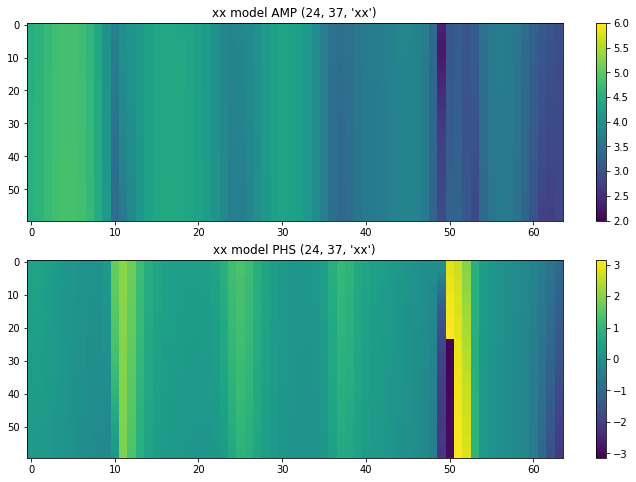

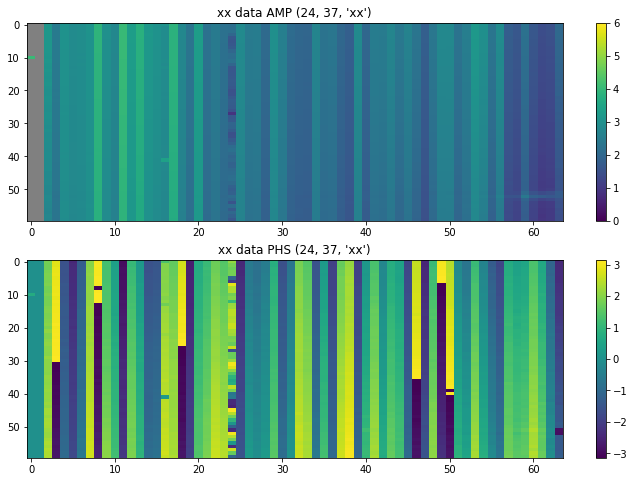

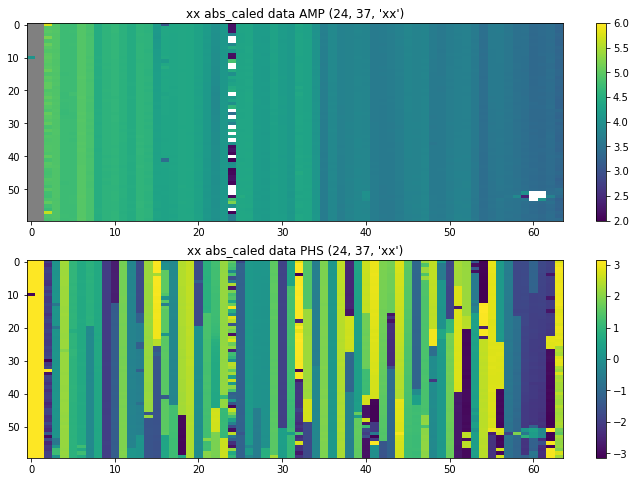

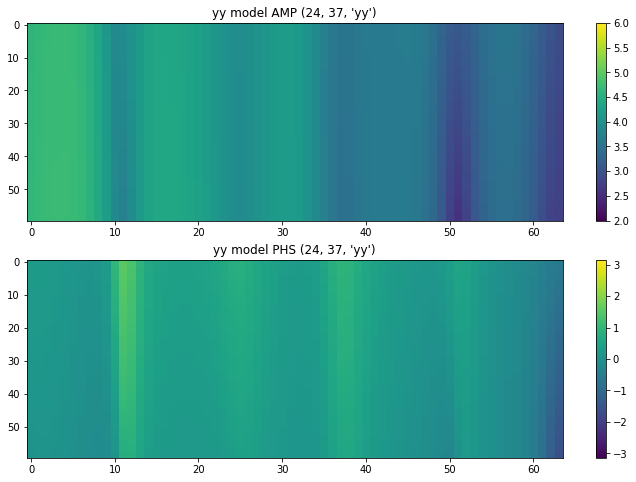

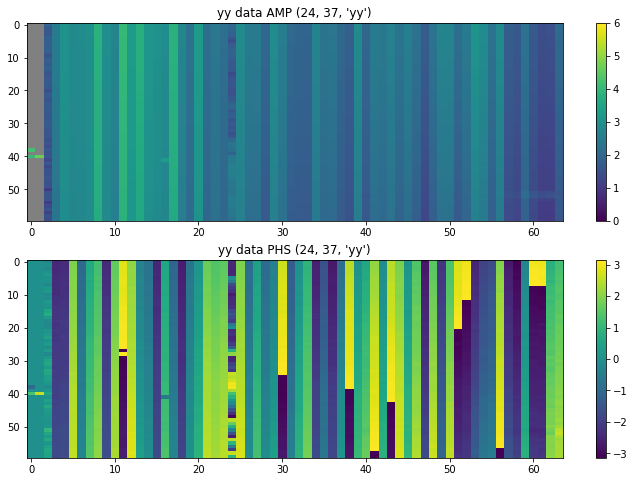

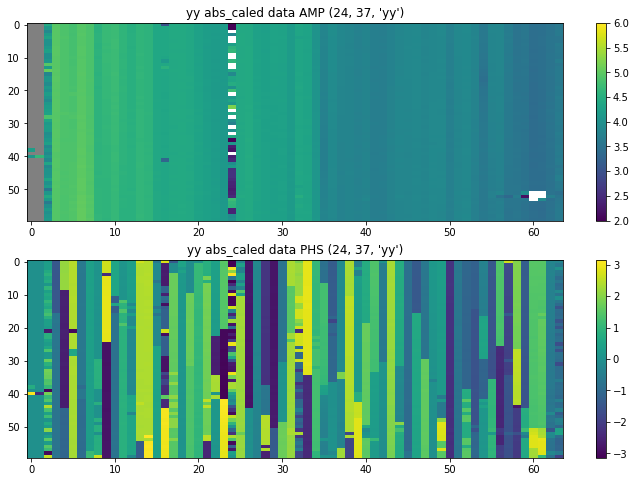

In [166]:
Absolute_Calibration_dred_mfreq_pscal = True

if Absolute_Calibration_dred_mfreq_pscal:
	
	for i in range(2):
		data_dred_mfreq_pscal[i] = LastUpdatedOrderedDict()
		pol = ['xx', 'yy'][i]
		if Absolute_Calibration_dred_mfreq:
			keys = dflags_dred_mfreq[i].keys()
			for key_index, key in enumerate(keys):
				#model_dred_mfreq[i][key] = fullsim_vis_mfreq[key_index, i]
				#data_dred_mfreq[i][key] = np.real(vis_data_dred_mfreq[i][:, :, key_index].transpose()) + np.abs(np.imag(vis_data_dred_mfreq[i][:, :, key_index].transpose()))*1j #[pol][freq,time,ubl_index].transpose()
				data_dred_mfreq_pscal[i][key] = vis_data_dred_mfreq_pscal[i][:, :, key_index].transpose() #[pol][freq,time,ubl_index].transpose()
			if add_Autobsl:
				model_dred_mfreq[i][keys[0][0], keys[0][0], keys[0][2]] = autocorr_vis_mfreq[i] # not lose generality, choose the first anntena in the first UBL for autocorrelation calibraiton.
				data_dred_mfreq_pscal[i][keys[0][0], keys[0][0], keys[0][2]] = autocorr_data_mfreq[i] # add the autocorrelation of first antenna in the first UBL as the last line in visibility.
				cdflags_dred_mfreq[i][keys[0][0], keys[0][0], keys[0][2]] = np.array([[False]*autocorr_data_mfreq[i].shape[1]]*autocorr_data_mfreq[i].shape[0])
				auto_select_dred_mfreq_pscal[i] = (keys[0][0], keys[0][0], keys[0][2])
			print(dflags_dred_mfreq[i].keys())
			print(dflags_dred_mfreq[i].keys()[0][0])
				
		
				
	re_cal_times = 3

	for i in range(2):
		pol = ['xx', 'yy'][i]
		re_cal = 0
		
		if Absolute_Calibration_dred_mfreq_pscal:
			for re_cal in range(re_cal_times): # number of times of absolute calibration
				if re_cal == 0:
					model_dred_mfreq[i], interp_flags_dred_mfreq[i] = hc.abscal.interp2d_vis(model_dred_mfreq[i], lsts, flist[i], lsts, flist[i])
					# instantiate class
					AC_dred_mfreq_pscal[i] = hc.abscal.AbsCal(model_dred_mfreq[i], data_dred_mfreq_pscal[i], antpos=antpos[i], wgts=wgts_dred_mfreq[i], freqs=flist[i])
					# kernel is median filter kernel, chosen to produce time-smooth output delays for this particular dataset
					AC_dred_mfreq_pscal[i].delay_lincal(kernel=(1, 11), medfilt=True, time_avg=True, solve_offsets=True)
				else:
					#model_dred_mfreq[i], interp_flags_dred_mfreq[i] = hc.abscal.interp2d_vis(model_dred_mfreq[i], lsts, flist[i], lsts, flist[i])
					# instantiate class
					AC_dred_mfreq_pscal[i] = hc.abscal.AbsCal(model_dred_mfreq[i], abs_corr_data_dred_mfreq_pscal[i], antpos=antpos[i], wgts=wgts_dred_mfreq[i], freqs=flist[i])
					# kernel is median filter kernel, chosen to produce time-smooth output delays for this particular dataset
					AC_dred_mfreq_pscal[i].delay_lincal(kernel=(1, 3), medfilt=True, time_avg=True, solve_offsets=True)
				# apply to data
				delay_corr_data_dred_mfreq_pscal[i] = hc.abscal.apply_gains(AC_dred_mfreq_pscal[i].data, (AC_dred_mfreq_pscal[i].ant_dly_gain))
				# instantiate class
				DAC_dred_mfreq_pscal[i] = hc.abscal.AbsCal(model_dred_mfreq[i], delay_corr_data_dred_mfreq_pscal[i], antpos=antpos[i], wgts=wgts_dred_mfreq[i], freqs=flist[i])
				# avg phase solver
				DAC_dred_mfreq_pscal[i].phs_logcal(avg=True)
				# apply to data
				dly_phs_corr_data_dred_mfreq_pscal[i] = hc.abscal.apply_gains(DAC_dred_mfreq_pscal[i].data, (DAC_dred_mfreq_pscal[i].ant_phi_gain))
				# instantiate class
				DPAC_dred_mfreq_pscal[i] = hc.abscal.AbsCal(model_dred_mfreq[i], dly_phs_corr_data_dred_mfreq_pscal[i], antpos=antpos[i], wgts=wgts_dred_mfreq[i], freqs=flist[i])
				# run amp linsolve
				DPAC_dred_mfreq_pscal[i].abs_amp_logcal()
				# run phs linsolve
				DPAC_dred_mfreq_pscal[i].TT_phs_logcal(zero_psi=False, four_pol=False)
				# apply to data
				abs_corr_data_dred_mfreq_pscal[i] = hc.abscal.apply_gains(DPAC_dred_mfreq_pscal[i].data, 
										(DPAC_dred_mfreq_pscal[i].abs_psi_gain, DPAC_dred_mfreq_pscal[i].TT_Phi_gain, DPAC_dred_mfreq_pscal[i].abs_eta_gain), gain_convention='multiply')
									
			vis_data_dred_mfreq_pscal_abscal[i] = np.zeros_like(vis_data_dred_mfreq_pscal[i], dtype='complex128')
			for key_id, key in enumerate(dflags_dred_mfreq[i].keys()):
				vis_data_dred_mfreq_pscal_abscal[i][:, :, key_id] = abs_corr_data_dred_mfreq_pscal[i][key].transpose()
				#vis_data_dred_mfreq_pscal_abscal[i][:, :, key_id] = np.real(abs_corr_data_dred_mfreq_pscal[i][key].transpose()) + np.abs(np.imag(abs_corr_data_dred_mfreq_pscal[i][key].transpose()))*1j
			if add_Autobsl:
				autocorr_data_dred_mfreq_pscal_abscal[i] = abs_corr_data_dred_mfreq_pscal[i][auto_select_dred_mfreq_pscal[i]]
			else:
				autocorr_data_dred_mfreq_pscal_abscal[i] = autocorr_vis_mfreq[i]
				
			vis_data_dred_pscal_abscal[i] = vis_data_dred_mfreq_pscal_abscal[i][index_freq[i], :, :]
			if add_Autobsl: 
				autocorr_data_dred_pscal_abscal[i] = autocorr_data_dred_mfreq_pscal_abscal[i][:, index_freq[i]]
			else:
				autocorr_data_dred_pscal_abscal[i] = autocorr_vis_mfreq[i][:, index_freq[i]]
			
	for i in range(2):
		pol = ['xx', 'yy'][i]
		
		if Absolute_Calibration_dred_mfreq_pscal:								
			plt.figure(85000000+10*i)
			fig4[i], axes4[i] = plt.subplots(2, 1, figsize=(12, 8))
			plt.sca(axes4[i][0])
			uvt.plot.waterfall(AC_dred_mfreq_pscal[i].model[bl_dred_mfreq_pscal[i]], mode='log', mx=6, drng=4)
			plt.colorbar()
			plt.title(pol + ' model AMP {}'.format(bl_dred_mfreq_pscal[i]))
			plt.sca(axes4[i][1])
			uvt.plot.waterfall(AC_dred_mfreq_pscal[i].model[bl_dred_mfreq_pscal[i]], mode='phs', mx=np.pi, drng=2*np.pi)
			plt.colorbar()
			plt.title(pol + ' model PHS {}'.format(bl_dred_mfreq_pscal[i]))
			plt.show(block=False)			
			#plt.cla()
				
			plt.figure(95000000+10*i)
			fig4_data[i], axes4_data[i] = plt.subplots(2, 1, figsize=(12, 8))
			plt.sca(axes4_data[i][0])
			uvt.plot.waterfall(data_dred_mfreq_pscal[i][bl_dred_mfreq_pscal[i]], mode='log', mx=6, drng=6)
			plt.colorbar()
			plt.title(pol + ' data AMP {}'.format(bl_dred_mfreq_pscal[i]))
			plt.sca(axes4_data[i][1])
			uvt.plot.waterfall(data_dred_mfreq_pscal[i][bl_dred_mfreq_pscal[i]], mode='phs', mx=np.pi, drng=2*np.pi)
			plt.colorbar()
			plt.title(pol + ' data PHS {}'.format(bl_dred_mfreq_pscal[i]))
			plt.show(block=False)
			#plt.cla()		
				
			####################### after ABS Calibration #########################	
			plt.figure(8500000+10*i)
			fig4_data_abscorr[i], axes4_data_abscorr[i] = plt.subplots(2, 1, figsize=(12, 8))
			plt.sca(axes4_data_abscorr[i][0])
			uvt.plot.waterfall(abs_corr_data_dred_mfreq_pscal[i][bl_dred_mfreq_pscal[i]], mode='log', mx=6, drng=4)
			plt.colorbar()
			plt.title(pol + ' abs_caled data AMP {}'.format(bl_dred_mfreq_pscal[i]))
			plt.sca(axes4_data_abscorr[i][1])
			uvt.plot.waterfall(abs_corr_data_dred_mfreq_pscal[i][bl_dred_mfreq_pscal[i]], mode='phs', mx=np.pi, drng=2*np.pi)
			plt.colorbar()
			plt.title(pol + ' abs_caled data PHS {}'.format(bl_dred_mfreq_pscal[i]))
			plt.show(block=False)
			#plt.cla()
	

In [167]:
################################### Store Visibility Data and prepare to Delete Variable ##################################
data_vis_xx_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_xx.simvis'%(INSTRUMENT, freq, nUBL_used+1, nt_used, nside_standard, bnside)
data_vis_yy_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_yy.simvis'%(INSTRUMENT, freq, nUBL_used+1, nt_used, nside_standard, bnside)
vis_data[0].astype('complex128').tofile(data_vis_xx_filename)
vis_data[1].astype('complex128').tofile(data_vis_yy_filename)

data_vis_dred_xx_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_dred_xx_dred.simvis'%(INSTRUMENT, freq, nUBL_used+1, nt_used, nside_standard, bnside)
data_vis_dred_yy_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_dred_yy_dred.simvis'%(INSTRUMENT, freq, nUBL_used+1, nt_used, nside_standard, bnside)
vis_data_dred[0].astype('complex128').tofile(data_vis_dred_xx_filename)
vis_data_dred[1].astype('complex128').tofile(data_vis_dred_yy_filename)

data_vis_dred_mfreq_xx_filename = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_xx_mfreq%s-%s-%s_dred_mfreq.simvis'%(INSTRUMENT, nUBL_used+1, nt_used, nside_standard, bnside, np.min(flist[0]), np.max(flist[0]), len(flist[0]))
data_vis_dred_mfreq_yy_filename = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_yy_mfreq%s-%s-%s_dred_mfreq.simvis'%(INSTRUMENT, nUBL_used+1, nt_used, nside_standard, bnside, np.min(flist[1]), np.max(flist[1]), len(flist[1]))
vis_data_dred_mfreq[0].astype('complex128').tofile(data_vis_dred_mfreq_xx_filename)
vis_data_dred_mfreq[1].astype('complex128').tofile(data_vis_dred_mfreq_yy_filename)

abscal_data_vis_dred_mfreq_xx_filename = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_xx_mfreq%s-%s-%s_dred_mfreq_abscal.simvis'%(INSTRUMENT, nUBL_used+1, nt_used, nside_standard, bnside, np.min(flist[0]), np.max(flist[0]), len(flist[0]))
abscal_data_vis_dred_mfreq_yy_filename = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_yy_mfreq%s-%s-%s_dred_mfreq_abscal.simvis'%(INSTRUMENT, nUBL_used+1, nt_used, nside_standard, bnside, np.min(flist[1]), np.max(flist[1]), len(flist[1]))
vis_data_dred_mfreq_abscal[0].astype('complex128').tofile(abscal_data_vis_dred_mfreq_xx_filename)
vis_data_dred_mfreq_abscal[1].astype('complex128').tofile(abscal_data_vis_dred_mfreq_yy_filename)

abscal_data_vis_dred_xx_filename = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_xx_%s_dred_abscal.simvis'%(INSTRUMENT, nUBL_used+1, nt_used, nside_standard, bnside, freq)
abscal_data_vis_dred_yy_filename = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_yy_%s_dred_abscal.simvis'%(INSTRUMENT, nUBL_used+1, nt_used, nside_standard, bnside, freq)
vis_data_dred_abscal[0].astype('complex128').tofile(abscal_data_vis_dred_xx_filename)
vis_data_dred_abscal[1].astype('complex128').tofile(abscal_data_vis_dred_yy_filename)

pscal_data_vis_dred_mfreq_xx_filename = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_xx_%s_dred_mfreq_pscal.simvis'%(INSTRUMENT, nUBL, nt, nside_standard, bnside, freq)
pscal_data_vis_dred_mfreq_yy_filename = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_yy_%s_dred_mfreq_pscal.simvis'%(INSTRUMENT, nUBL, nt, nside_standard, bnside, freq)
vis_data_dred_mfreq_pscal[0].astype('complex128').tofile(pscal_data_vis_dred_mfreq_xx_filename)
vis_data_dred_mfreq_pscal[1].astype('complex128').tofile(pscal_data_vis_dred_mfreq_yy_filename)

pscal_data_vis_dred_xx_filename = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_xx_%s_pscal.simvis'%(INSTRUMENT, nUBL, nt, nside_standard, bnside, freq)
pscal_data_vis_dred_yy_filename = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_yy_%s_pscal.simvis'%(INSTRUMENT, nUBL, nt, nside_standard, bnside, freq)
vis_data_dred_pscal[0].astype('complex128').tofile(pscal_data_vis_dred_xx_filename)
vis_data_dred_pscal[1].astype('complex128').tofile(pscal_data_vis_dred_yy_filename)

sys.stdout.flush()


In [168]:
#print noise['x']

In [169]:
################
####read data and N
################
data = {}
Ni = {}
data_shape = {}
ubl_sort = {}
data_filename = full_sim_filename

Use_Simulation_noise = True
From_File_Data = True


for p in ['x', 'y']:
	pol = p + p
	print "%i UBLs to include, longest baseline is %i wavelengths" % (
	nUBL_used, np.max(np.linalg.norm(used_common_ubls, axis=1)) / (C / freq))
	if p == 'x':
		pol_index = 0
		sim_var_filename = sim_var_xx_filename
		sim_vis_filename = sim_vis_xx_filename
		try:
			data_var_filename = data_var_xx_filename
			data_var_filename_pscal = data_var_xx_filename_pscal
		except:
			pass
	elif p == 'y':
		pol_index = 1
		sim_var_filename = sim_var_yy_filename
		sim_vis_filename = sim_vis_yy_filename
		try:
			data_var_filename = data_var_yy_filename
			data_var_filename_pscal = data_var_yy_filename_pscal
		except:
			pass

	# get Ni (1/variance) and data
#	var_filename = datadir + tag + '_%s%s_%i_%i' % (p, p, nt, nUBL) + vartag + '.var'
#	Ni[pol] = 1. / (N[p].reshape((nt_used, nUBL_used))[tmask].transpose()[abs(ubl_index[p]) - 1].flatten() * jansky2kelvin ** 2)
	if Use_SimulatedData == 1:
#		Ni[pol] = 1. / (np.fromfile(data_var_filename, dtype='complex128').reshape((nt_used, nUBL_used))[tmask].transpose()[abs(ubl_index[p]) - 1].flatten() * jansky2kelvin ** 2)
		Ni[pol] = 1. / (np.fromfile(sim_var_filename, dtype='complex128').reshape((nt_used, nUBL_used)).transpose().flatten())
		data[pol] = np.fromfile(sim_vis_filename, dtype='complex128').reshape((nUBL_used, nt_used))
	else:
		if INSTRUMENT == 'miteor':
			if Use_Simulation_noise:
				Ni[pol] = 1. / (np.fromfile(data_var_filename, dtype='complex128').reshape((nt, nUBL))[tmask].transpose()[abs(ubl_index[p]) - 1].flatten())
			else:
				Ni[pol] = 1. / var_data[pol_index][tmask].transpose()[abs(ubl_index[p]) - 1].flatten()
			data[pol] = vis_data[pol_index][tmask].transpose()[abs(ubl_index[p]) - 1] #= (time_vis_data[:,1:,1::3] + time_vis_data[:,1:,2::3] * 1j).astype('complex64')			
			data[pol][ubl_index[p] < 0] = data[pol][ubl_index[p] < 0].conjugate()
#			data[pol] = (data[pol].flatten() * jansky2kelvin).conjugate()  # there's a conjugate convention difference
			data[pol] = (data[pol].flatten()).conjugate()  # there's a conjugate convention difference
		elif INSTRUMENT == 'hera47':
			if From_File_Data:
				if Use_PsAbsCal:
					Ni[pol] = 1. / (np.fromfile(data_var_filename_pscal, dtype='complex128').reshape((nt, nUBL))[tmask].transpose()[abs(ubl_index[p]) - 1].flatten()) #var_data[pol_index][tmask].transpose()[abs(ubl_index[p]) - 1].flatten()
				elif Use_Fullsim_Noise:
					Ni[pol] = 1. / (np.fromfile(sim_var_filename, dtype='complex128').reshape((nt_used, nUBL_used)).transpose().flatten())
				else:
					Ni[pol] = 1. / (np.fromfile(data_var_filename, dtype='complex128').reshape((nt, nUBL))[tmask].transpose()[abs(ubl_index[p]) - 1].flatten()) #var_data[pol_index][tmask].transpose()[abs(ubl_index[p]) - 1].flatten()
			else:
				if Use_PsAbsCal:
					Ni[pol] = 1. / N_data_pscal[p].reshape((nt, nUBL))[tmask].transpose()[abs(ubl_index[p]) - 1].flatten() #var_data[pol_index][tmask].transpose()[abs(ubl_index[p]) - 1].flatten()
				elif Use_Fullsim_Noise:
					Ni[pol] = 1. / (np.fromfile(sim_var_filename, dtype='complex128').reshape((nt_used, nUBL_used)).transpose().flatten())
				else:
					Ni[pol] = 1. / N_data[p].reshape((nt, nUBL))[tmask].transpose()[abs(ubl_index[p]) - 1].flatten() #var_data[pol_index][tmask].transpose()[abs(ubl_index[p]) - 1].flatten()
			if From_File_Data:
				if Use_PsAbsCal:
					data[pol] = np.fromfile(globals()['pscal_data_vis_dred_' + pol + '_filename'], dtype='complex128').reshape((nt, nUBL))[tmask].transpose()[abs(ubl_index[p]) - 1]
				elif Use_AbsCal:				
					data[pol] = np.fromfile(globals()['abscal_data_vis_dred_' + pol + '_filename'], dtype='complex128').reshape((nt, nUBL))[tmask].transpose()[abs(ubl_index[p]) - 1]
				else:
					data[pol] = np.fromfile(globals()['data_vis_dred_' + pol + '_filename'], dtype='complex128').reshape((nt, nUBL))[tmask].transpose()[abs(ubl_index[p]) - 1]
			else:
				if Use_PsAbsCal:
					data[pol] = vis_data_dred_pscal[pol_index][tmask].transpose()[abs(ubl_index[p]) - 1] #= (time_vis_data[:,1:,1::3] + time_vis_data[:,1:,2::3] * 1j).astype('complex64')
					#data[pol][ubl_index[p] < 0] = data[pol][ubl_index[p] < 0]#.conjugate()
					data[pol] = data[pol].flatten()#.conjugate()  # there's a conjugate convention difference
				elif Use_AbsCal:				
					data[pol] = vis_data_dred_abscal[pol_index][tmask].transpose()[abs(ubl_index[p]) - 1] #= (time_vis_data[:,1:,1::3] + time_vis_data[:,1:,2::3] * 1j).astype('complex64')
					#data[pol][ubl_index[p] < 0] = data[pol][ubl_index[p] < 0]#.conjugate()
					data[pol] = data[pol].flatten()#.conjugate()  # there's a conjugate convention difference
				else:
					data[pol] = vis_data_dred[pol_index][tmask].transpose()[abs(ubl_index[p]) - 1] #= (time_vis_data[:,1:,1::3] + time_vis_data[:,1:,2::3] * 1j).astype('complex64')
					#data[pol][ubl_index[p] < 0] = data[pol][ubl_index[p] < 0]#.conjugate()
					data[pol] = (data[pol].flatten() * jansky2kelvin)#.conjugate()  # there's a conjugate convention difference
			#data[pol][ubl_index[p] < 0] = data[pol][ubl_index[p] < 0]#.conjugate()
			#data[pol] = (data[pol].flatten() * jansky2kelvin)#.conjugate()  # there's a conjugate convention difference
	data_shape[pol] = (nUBL_used, nt_used)
	ubl_sort[p] = np.argsort(la.norm(used_common_ubls, axis=1))
print "Memory usage: %.3fMB" % (resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1024)
sys.stdout.flush()

# Merge data
data = np.array([data['xx'], data['yy']]).reshape([2] + list(data_shape['xx'])).transpose(
	(1, 0, 2)).flatten()
data = np.concatenate((np.real(data), np.imag(data))).astype('complex128')
Ni = np.concatenate((Ni['xx'], Ni['yy'])).reshape([2] + list(data_shape['xx'])).transpose(
	(1, 0, 2)).flatten()
Ni = np.concatenate((Ni * 2, Ni * 2))

sys.stdout.flush()

def get_complex_data(real_data, nubl=nUBL_used, nt=nt_used):
	if len(real_data.flatten()) != 2 * nubl * 2 * nt:
		raise ValueError("Incorrect dimensions: data has length %i where nubl %i and nt %i together require length of %i."%(len(real_data), nubl, nt, 2 * nubl * 2 * nt))
	input_shape = real_data.shape
	real_data.shape = (2, nubl, 2, nt)
	result = real_data[0] + 1.j * real_data[1]
	real_data.shape = input_shape
	return result

def stitch_complex_data(complex_data):
	return np.concatenate((np.real(complex_data.flatten()), np.imag(complex_data.flatten()))).astype('complex128')


9 UBLs to include, longest baseline is 14 wavelengths
9 UBLs to include, longest baseline is 14 wavelengths
Memory usage: 8380580.000MB


In [170]:
##################### Delete or Erase Data #######################
Erase = False
if Erase:
	model_sf = {}
	model_dred = {}
	model_dred_mfreq = {}
	#data = {}
	data_sf = {}
	data_dred = {}
	data_dred_mfreq = {}
	AC = {}
	AC_sf = {}
	AC_dred = {}
	AC_dred_mfreq = {}
	freq_to_cal = [freq]
	fulldflags = {}
	auto_select_dred_mfreq = {}

	#	try:
	#		cdata = copy.deepcopy(data)
	#	except:
	#		pass

	try:
		del(dflags_sf) 
		#del(cdflags_sf)
	except:
		pass
		
	try:
		del(dflags_dred) 
		#del(cdflags_dred)
	except:
		pass

	try:
		del(dflags)
		#del(cdflags) 
	except:
		pass

	try:
		del(dflags_dred_mfreq)
		#del(cdflags_dred_mfreq) 
	except:
		pass
		
	#cwgts = copy.deepcopy(wgts)
	#cwgts_dred = copy.deepcopy(wgts_dred)

	bl_select = 0
	#bl = dflags.keys()[bl_select] #dflags and dflags_yy #[(24, 53, 'xx')
	fig = {}
	axes = {}
	fig_data = {}
	axes_data = {}

	bl_dred_select = 0
	#bl_dred = dflags_dred[0].keys()[bl_dred_select] #[(25, 37, 'xx')
	fig2 = {}
	axes2 = {}
	fig2_data = {}
	axes2_data = {}

	bl_dred_mfreq_select = 8
	#bl_dred_mfreq = [dflags_dred_mfreq[0].keys()[bl_dred_mfreq_select], dflags_dred_mfreq[1].keys()[bl_dred_mfreq_select]]  #[(25, 37, 'xx'), (25, 37, 'yy')]
	fig3 = {}
	axes3 = {}
	fig3_data = {}
	axes3_data = {}
	fig3_data_abscorr = {} 
	axes3_data_abscorr = {}

	delay_corr_data = {}
	delay_corr_data_sf = {}
	delay_corr_data_dred = {}
	delay_corr_data_dred_mfreq = {}
	DAC = {}
	DAC_sf = {}
	DAC_dred = {}
	DAC_dred_mfreq = {}
	dly_phs_corr_data = {}
	dly_phs_corr_data_sf = {}
	dly_phs_corr_data_dred = {}
	dly_phs_corr_data_dred_mfreq = {}
	DPAC = {}
	DPAC_sf = {}
	DPAC_dred = {}
	DPAC_dred_mfreq = {}
	abs_corr_data = {}
	abs_corr_data_sf = {}
	abs_corr_data_dred = {}
	abs_corr_data_dred_mfreq = {}

	vis_data_dred_mfreq_abscal = [[], []]
	autocorr_data_dred_mfreq_abscal = [[], []]
	vis_data_dred_abscal = [[], []]
	autocorr_data_dred_abscal = [[], []]


	Del = True
	if Del:
		try:
			del(vis_data)
			del(vis_data_dred)
		except:
			pass
		try:
			del(vis_data_mfreq)
			del(vis_data_dred_mfreq)
		except:
			pass	
			
			
		try:
			del(N_data)
		except:
			pass
		try:
			del(noise_data)
		except:
			pass
		try:
			del(var_data)
		except:
			pass
	#	try:
	#		del(var_data)
	#	except:
	#		pass

sys.stdout.flush()


In [171]:
print Ni

[1.12098316e-04+0.j 9.89348349e-05+0.j 2.22373968e-05+0.j ...
 4.24501502e-04+0.j 7.18377218e-05+0.j 1.18565319e-02+0.j]


In [172]:
# pre_ampcal = False

In [173]:
#pre_ampcal = True

In [174]:
################################
################################
####pre_calibrate################
################################
################################
#####1. antenna based calibration#######
for cal_index in range(1):
	if cal_index == 0:
		raw_data = np.copy(data).reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1])
#	if pre_ampcal:
#		pre_ampcal = False if cal_index == 0 else True
#		cal_index += 1
#	else:
#		cal_index = 2 
	if antpairs is not None:
		used_antpairs = antpairs[abs(ubl_index['x'])-1]
		n_usedants = np.unique(used_antpairs)
	#####2. re-phasing and crosstalk#######
	additive_A = np.zeros((nUBL_used, 2, nt_used, 1 + 4 * nUBL_used)).astype('complex128')

	#put in autocorr regardless of whats saved on disk
	for p in range(2):
		additive_A[:, p, :, 0] = fullsim_vis[:, p]
		for i in range(nUBL_used):
			additive_A[i, p, :, 1 + 4 * i + 2 * p] = 1. * autocorr_vis_normalized[p]
			additive_A[i, p, :, 1 + 4 * i + 2 * p + 1] = 1.j * autocorr_vis_normalized[p]
	additive_A.shape = (nUBL_used * 2 * nt_used, 1 + 4 * nUBL_used)

	if pre_calibrate:
		#import omnical.calibration_omni as omni
		#raw_data = np.copy(data).reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1])
		#raw_Ni = np.copy(Ni)

		real_additive_A = np.concatenate((np.real(additive_A), np.imag(additive_A)), axis=0).astype('complex128')
		if pre_ampcal:#if pre_ampcal, allow xx and yy to fit amp seperately
			n_prefit_amp = 2
			real_additive_A.shape = (2 * nUBL_used, 2, nt_used, 1 + 4 * nUBL_used)
			real_additive_A_expand = np.zeros((2 * nUBL_used, 2, nt_used, n_prefit_amp + 4 * nUBL_used), dtype='complex128')
			for i in range(n_prefit_amp):
				real_additive_A_expand[:, i, :, i] = real_additive_A[:, i, :, 0]
			real_additive_A_expand[..., n_prefit_amp:] = real_additive_A[..., 1:]
			real_additive_A = real_additive_A_expand
			real_additive_A.shape = (2 * nUBL_used * 2 * nt_used, n_prefit_amp + 4 * nUBL_used)
		else:
			n_prefit_amp = 1

		additive_AtNiA = np.empty((n_prefit_amp + 4 * nUBL_used, n_prefit_amp + 4 * nUBL_used), dtype='complex128')
		if pre_addcal:
			ATNIA(real_additive_A, Ni, additive_AtNiA)
			additive_AtNiAi = sla.inv(additive_AtNiA)
		else:
			real_additive_A[..., n_prefit_amp:] = 0.
			ATNIA(real_additive_A, Ni, additive_AtNiA)
			additive_AtNiAi = sla.pinv(additive_AtNiA)

		niter = 0
		rephases = np.zeros((2,2))
		additive_term = np.zeros_like(data)
		additive_term_incr = np.zeros_like(data)
		while (niter == 0 or la.norm(rephases) > .001 or la.norm(additive_term_incr) / la.norm(data) > .001) and niter < 500:
			niter += 1

			if pre_phscal:
				cdata = get_complex_data(data)
				for p, pol in enumerate(['xx', 'yy']):
					#rephase = omni.solve_phase_degen_fast(cdata[:, p].transpose(), cdata[:, p].transpose(), fullsim_vis[:, p].transpose(), fullsim_vis[:, p].transpose(), used_common_ubls)
					rephase = solve_phase_degen(cdata[:, p].transpose(), cdata[:, p].transpose(), fullsim_vis[:, p].transpose(), fullsim_vis[:, p].transpose(), used_common_ubls)
					rephases[p] = rephase
					if p == 0:
						print 'pre process rephase', pol, rephase,
					else:
						print pol, rephase
					cdata[:, p] *= np.exp(1.j * used_common_ubls[:, :2].dot(rephase))[:, None]
				data = stitch_complex_data(cdata).astype('complex128')

			additive_sol = additive_AtNiAi.dot(np.transpose(real_additive_A).dot(data * Ni))
			print '>>>>>>>>>>>>>additive fitting amp', additive_sol[:n_prefit_amp],
			additive_term_incr = real_additive_A[:, n_prefit_amp:].dot(additive_sol[n_prefit_amp:])
			data -= additive_term_incr
			additive_term += additive_term_incr
			print "additive fraction", la.norm(additive_term_incr) / la.norm(data),

		cadd = get_complex_data(additive_term)

		if pre_ampcal:
			data = stitch_complex_data(get_complex_data(data) / additive_sol[:n_prefit_amp, None])
			if Use_PsAbsCal and not comply_ps2mod_autocorr:
				Ni = stitch_complex_data(get_complex_data(Ni) * additive_sol[:n_prefit_amp, None]**2)
			additive_term = stitch_complex_data(get_complex_data(additive_term) / additive_sol[:n_prefit_amp, None])
			
			print(additive_sol[:n_prefit_amp])
			
print 'saving data to', os.path.dirname(data_filename) + '/' + INSTRUMENT + tag + datatag + vartag + '_gsmcal_n%i_bn%i.npz'%(nside_standard, bnside)
np.savez(os.path.dirname(data_filename) + '/' + INSTRUMENT + tag + datatag + vartag + '_gsmcal_n%i_bn%i.npz'%(nside_standard, bnside),
		 data=data,
		 simdata=stitch_complex_data(fullsim_vis),
		 psdata=[stitch_complex_data(vis) for vis in pt_vis],
		 pt_sources=pt_sources,
		 ubls=used_common_ubls,
		 tlist=lsts,
		 Ni=Ni,
		 freq=freq)
	
	


Estimated time for A 2160 by 38 4.054752e-05 minutes pre process rephase xx [ 0.12481946 -0.03067976] yy [ 0.00047314 -0.00041053]
>>>>>>>>>>>>>additive fitting amp [-3.76216467+0.j  0.69782306+0.j] additive fraction 1.0621057287535176 pre process rephase xx [ 0.1586313  -0.03303214] yy [-0.00424383  0.00699039]
>>>>>>>>>>>>>additive fitting amp [-6.57493174+0.j  0.68266521+0.j] additive fraction 1.1400342054460326 pre process rephase xx [-0.10500578 -0.12611283] yy [-0.00404873  0.00644955]
>>>>>>>>>>>>>additive fitting amp [-2.22327839+0.j  0.66645619+0.j] additive fraction 2.7870712409163314 pre process rephase xx [ 0.04958711 -0.16013336] yy [-0.00346833  0.0056285 ]
>>>>>>>>>>>>>additive fitting amp [7.06475032+0.j 0.65028981+0.j] additive fraction 0.9928579238586964 pre process rephase xx [ 0.00042049 -0.00061051] yy [-0.00308292  0.00477943]
>>>>>>>>>>>>>additive fitting amp [7.02425161+0.j 0.63557959+0.j] additive fraction 0.014398034694725441 pre process rephase xx [ 0.0004385

>>>>>>>>>>>>>additive fitting amp [3.4641087 +0.j 0.65428049+0.j] additive fraction 0.0420133770252479 pre process rephase xx [ 0.00187868 -0.00049325] yy [-0.00070865 -0.00040527]
>>>>>>>>>>>>>additive fitting amp [3.33373974+0.j 0.65667034+0.j] additive fraction 0.04379379641736983 pre process rephase xx [ 0.0019404  -0.00050455] yy [-0.00070597 -0.00039929]
>>>>>>>>>>>>>additive fitting amp [3.19831912+0.j 0.6589686 +0.j] additive fraction 0.04652455737668597 pre process rephase xx [ 0.00199344 -0.00053147] yy [-0.00071654 -0.0003805 ]
>>>>>>>>>>>>>additive fitting amp [3.05685994+0.j 0.66114659+0.j] additive fraction 0.049733580142295196 pre process rephase xx [ 0.00206142 -0.00058319] yy [-0.00069658 -0.00034447]
>>>>>>>>>>>>>additive fitting amp [2.90641365+0.j 0.66311464+0.j] additive fraction 0.0542211114220613 pre process rephase xx [ 0.00209142 -0.0005537 ] yy [-0.00068109 -0.00031148]
>>>>>>>>>>>>>additive fitting amp [2.75566993+0.j 0.6648982 +0.j] additive fraction 0.05623

>>>>>>>>>>>>>additive fitting amp [6.9723705 +0.j 0.69276779+0.j] additive fraction 0.01051370342310066 pre process rephase xx [ 0.00039735 -0.00049691] yy [-0.00074094 -0.00026201]
>>>>>>>>>>>>>additive fitting amp [6.93124568+0.j 0.69252341+0.j] additive fraction 0.010179713032260503 pre process rephase xx [ 0.0003792  -0.00048374] yy [-0.00073388 -0.00026007]
>>>>>>>>>>>>>additive fitting amp [6.89091923+0.j 0.6922326 +0.j] additive fraction 0.009912726708831027 pre process rephase xx [ 0.00035915 -0.000466  ] yy [-0.0007268  -0.00025812]
>>>>>>>>>>>>>additive fitting amp [6.85177672+0.j 0.69189667+0.j] additive fraction 0.009566435172579725 pre process rephase xx [ 0.00035054 -0.0004605 ] yy [-0.00071459 -0.00026402]
>>>>>>>>>>>>>additive fitting amp [6.81276351+0.j 0.69152353+0.j] additive fraction 0.009473089092908905 pre process rephase xx [ 0.00033382 -0.0004407 ] yy [-0.00069853 -0.00027156]
>>>>>>>>>>>>>additive fitting amp [6.77503216+0.j 0.69111672+0.j] additive fraction 0.

>>>>>>>>>>>>>additive fitting amp [6.05710662+0.j 0.6383    +0.j] additive fraction 0.002204628911852985 pre process rephase xx [ 2.23760003e-05 -5.88416609e-05] yy [-0.00057021 -0.0003418 ]
>>>>>>>>>>>>>additive fitting amp [6.05206344+0.j 0.6361166 +0.j] additive fraction 0.0021118649837320695 pre process rephase xx [ 1.95172627e-05 -5.65986977e-05] yy [-0.00055453 -0.0003171 ]
>>>>>>>>>>>>>additive fitting amp [6.04729885+0.j 0.63399123+0.j] additive fraction 0.0020330317341995608 pre process rephase xx [ 1.68280369e-05 -5.45231749e-05] yy [-0.00054884 -0.00030733]
>>>>>>>>>>>>>additive fitting amp [6.04279444+0.j 0.631866  +0.j] additive fraction 0.001986502778361626 pre process rephase xx [ 1.42972153e-05 -5.26049197e-05] yy [-0.0005543  -0.00032464]
>>>>>>>>>>>>>additive fitting amp [6.03853289+0.j 0.62964085+0.j] additive fraction 0.001980616360577749 pre process rephase xx [ 1.19143572e-05 -5.08343531e-05] yy [-0.0005384  -0.00031946]
>>>>>>>>>>>>>additive fitting amp [6.034497

>>>>>>>>>>>>>additive fitting amp [5.94594215+0.j 0.56339552+0.j] additive fraction 0.0012102643434391094 pre process rephase xx [-3.79525749e-05 -5.76372852e-05] yy [-0.0002505  -0.00013398]
>>>>>>>>>>>>>additive fitting amp [5.94364796+0.j 0.56200891+0.j] additive fraction 0.0012169901631798007 pre process rephase xx [-3.97086672e-05 -5.97927221e-05] yy [-0.0002418  -0.00012138]
>>>>>>>>>>>>>additive fitting amp [5.94128139+0.j 0.56069851+0.j] additive fraction 0.0012269027699823543 pre process rephase xx [-4.15267051e-05 -6.20451644e-05] yy [-0.0002331  -0.00011146]
>>>>>>>>>>>>>additive fitting amp [5.93883826+0.j 0.55945384+0.j] additive fraction 0.001241145893724165 pre process rephase xx [-4.34101112e-05 -6.43982192e-05] yy [-0.00023003 -0.00011211]
>>>>>>>>>>>>>additive fitting amp [5.93631426+0.j 0.55821099+0.j] additive fraction 0.0012704932021972409 pre process rephase xx [-4.53624374e-05 -6.68556837e-05] yy [-0.00025363 -0.00012868]
>>>>>>>>>>>>>additive fitting amp [5.9337

>>>>>>>>>>>>>additive fitting amp [5.77611429+0.j 0.51649054+0.j] additive fraction 0.003135455147432493 pre process rephase xx [-0.00014655 -0.0001835 ] yy [-7.38495927e-05 -5.03201785e-05]
>>>>>>>>>>>>>additive fitting amp [5.7694905 +0.j 0.51596587+0.j] additive fraction 0.00319633763913259 pre process rephase xx [-0.00014946 -0.00018713] yy [-7.35060739e-05 -4.65124559e-05]
>>>>>>>>>>>>>additive fitting amp [5.76271647+0.j 0.51546115+0.j] additive fraction 0.00326075469689067 pre process rephase xx [-0.00015251 -0.0001909 ] yy [-7.37637700e-05 -4.32750759e-05]
>>>>>>>>>>>>>additive fitting amp [5.75578712+0.j 0.51497137+0.j] additive fraction 0.003327889087916395 pre process rephase xx [-0.00015806 -0.00019345] yy [-7.37913867e-05 -4.05492297e-05]
>>>>>>>>>>>>>additive fitting amp [5.74890758+0.j 0.51449482+0.j] additive fraction 0.0033904308687894708 pre process rephase xx [-0.00016123 -0.0001977 ] yy [-7.36091794e-05 -3.82037500e-05]
>>>>>>>>>>>>>additive fitting amp [5.74184105+

>>>>>>>>>>>>>additive fitting amp [5.20037966+0.j 0.49378917+0.j] additive fraction 0.011013736195244766 pre process rephase xx [-0.00049662 -0.00061328] yy [-5.22855242e-05 -2.11098349e-06]
>>>>>>>>>>>>>additive fitting amp [5.17349523+0.j 0.49357891+0.j] additive fraction 0.01125607814106381 pre process rephase xx [-0.00051408 -0.00062871] yy [-4.77909744e-05 -1.42863998e-06]
>>>>>>>>>>>>>additive fitting amp [5.1459724 +0.j 0.49338935+0.j] additive fraction 0.011583485601619153 pre process rephase xx [-0.0005443  -0.00065404] yy [-4.47893093e-05 -1.59415908e-06]
>>>>>>>>>>>>>additive fitting amp [5.11758051+0.j 0.49321027+0.j] additive fraction 0.012111332156819804 pre process rephase xx [-0.00057856 -0.00068745] yy [-4.19992119e-05 -1.68056752e-06]
>>>>>>>>>>>>>additive fitting amp [5.0878164 +0.j 0.49304129+0.j] additive fraction 0.012785275930460228 pre process rephase xx [-0.00061408 -0.00072193] yy [-3.93793341e-05 -1.71144450e-06]
>>>>>>>>>>>>>additive fitting amp [5.05662092+

>>>>>>>>>>>>>additive fitting amp [7.58571955+0.j 0.4905314 +0.j] additive fraction 0.007986650166658733 pre process rephase xx [-2.30348549e-06 -5.97524238e-04] yy [-8.06027919e-06 -1.22802996e-06]
>>>>>>>>>>>>>additive fitting amp [7.56819711+0.j 0.49049392+0.j] additive fraction 0.007891389126956454 pre process rephase xx [-2.21259527e-06 -5.85607278e-04] yy [-7.49095986e-06 -1.14917140e-06]
>>>>>>>>>>>>>additive fitting amp [7.5506106 +0.j 0.49045904+0.j] additive fraction 0.007751490694021068 pre process rephase xx [-2.21630598e-06 -5.73777235e-04] yy [-6.96236067e-06 -1.07321840e-06]
>>>>>>>>>>>>>additive fitting amp [7.53298549+0.j 0.49042659+0.j] additive fraction 0.0076120609689857505 pre process rephase xx [-2.30659312e-06 -5.62040736e-04] yy [-6.47138441e-06 -1.00087828e-06]
>>>>>>>>>>>>>additive fitting amp [7.51534617+0.j 0.49039641+0.j] additive fraction 0.007473163839828929 pre process rephase xx [-2.47606834e-06 -5.50404495e-04] yy [-6.01523328e-06 -9.32495203e-07]
>>>>

>>>>>>>>>>>>>additive fitting amp [6.9863075 +0.j 0.48991792+0.j] additive fraction 0.0032090230203558143 pre process rephase xx [-1.97479879e-05 -2.21872491e-04] yy [-2.06334923e-06 -2.57031251e-07]
>>>>>>>>>>>>>additive fitting amp [6.97649568+0.j 0.48990862+0.j] additive fraction 0.0031385064946652334 pre process rephase xx [-1.96787359e-05 -2.16747566e-04] yy [-2.06481258e-06 -2.57290535e-07]
>>>>>>>>>>>>>additive fitting amp [6.9668768 +0.j 0.48989932+0.j] additive fraction 0.0030693116386270626 pre process rephase xx [-1.96110024e-05 -2.11732059e-04] yy [-2.06628515e-06 -2.57522299e-07]
>>>>>>>>>>>>>additive fitting amp [6.95744924+0.j 0.48989002+0.j] additive fraction 0.003001428132239743 pre process rephase xx [-1.95442387e-05 -2.06824371e-04] yy [-2.06776487e-06 -2.57736078e-07]
>>>>>>>>>>>>>additive fitting amp [6.94821122+0.j 0.4898807 +0.j] additive fraction 0.0029348450340061965 pre process rephase xx [-1.94779464e-05 -2.02022881e-04] yy [-2.06925039e-06 -2.57938114e-07]
>

>>>>>>>>>>>>>additive fitting amp [6.70968609+0.j 0.48952154+0.j] additive fraction 0.0012261214276737598 pre process rephase xx [-1.55650089e-05 -8.23181933e-05] yy [-2.12828306e-06 -2.65060099e-07]
>>>>>>>>>>>>>additive fitting amp [6.70590135+0.j 0.48951195+0.j] additive fraction 0.001196055598714903 pre process rephase xx [-1.54925822e-05 -8.02820897e-05] yy [-2.12990175e-06 -2.65254088e-07]
>>>>>>>>>>>>>additive fitting amp [6.70221742+0.j 0.48950235+0.j] additive fraction 0.0011667852286499092 pre process rephase xx [-1.5413977e-05 -7.8300562e-05] yy [-2.13152387e-06 -2.65448497e-07]
>>>>>>>>>>>>>additive fitting amp [6.69863155+0.j 0.48949275+0.j] additive fraction 0.0011382909317904488 pre process rephase xx [-1.53294574e-05 -7.63719778e-05] yy [-2.13314942e-06 -2.65643305e-07]
>>>>>>>>>>>>>additive fitting amp [6.6951411 +0.j 0.48948313+0.j] additive fraction 0.001110550164494179 pre process rephase xx [-1.52393648e-05 -7.44948948e-05] yy [-2.13477841e-06 -2.65838524e-07]
>>>>

In [175]:
print la.norm(data)
print la.norm(raw_data)
print la.norm(fullsim_vis)
print la.norm(raw_data)/la.norm(data)
print #la.norm(raw_Ni)
print la.norm(Ni)
print data
print fullsim_vis

535476.0945505581
436544.36865000287
490013.22120103094
0.8152452987026587

9.051997929311737
[-6825.60695115+0.j -7610.19595301+0.j -7623.9258904 +0.j ...
 -1042.88345295+0.j  1855.60516788+0.j  2819.41409772+0.j]
[[[ -6933.77123406+9.77620029e+02j  -6932.71429535+9.90285496e+02j
    -6931.54735726+1.00292621e+03j ...  -6710.71177322+1.62681606e+03j
    -6702.61150573+1.63660432e+03j  -6694.40249167+1.64631833e+03j]
  [-10985.34344495+8.07110421e+02j -10987.25437447+8.16943652e+02j
   -10989.07214343+8.26744406e+02j ... -10947.26104782+1.29942875e+03j
   -10943.28959943+1.30641289e+03j -10939.21712817+1.31333067e+03j]]

 [[ -4287.04953807-8.39421014e+02j  -4295.11989577-8.27811111e+02j
    -4303.13823568-8.16059590e+02j ...  -4573.57220637+1.74733880e+01j
    -4574.12338644+3.55429442e+01j  -4574.47470352+5.36660703e+01j]
  [ -2498.33371822-7.36639388e+02j  -2509.05309706-7.28157299e+02j
    -2519.7313397 -7.19513860e+02j ...  -2941.85886904-2.34884758e+01j
    -2945.25266905-7.095240

In [176]:
print additive_sol[0], additive_sol[1], n_prefit_amp
print (additive_sol[0] * (pre_ampcal)+(not pre_ampcal))
print additive_sol[:n_prefit_amp, None]
print pre_ampcal

(6.679031211421716+0j) (0.4894349456582099+0j) 2
(6.679031211421716+0j)
[[6.67903121+0.j]
 [0.48943495+0.j]]
True


In [177]:
print la.norm(data)
print la.norm(raw_data)
print la.norm(fullsim_vis)
print la.norm(fullsim_vis)/la.norm(data)
#print la.norm(raw_Ni)
print la.norm(Ni)
print Ni
print Ni.max()
print Ni**-0.5

535476.0945505581
436544.36865000287
490013.22120103094
0.9150982204206789
9.051997929311737
[1.12098316e-04+0.j 9.89348349e-05+0.j 2.22373968e-05+0.j ...
 4.24501502e-04+0.j 7.18377218e-05+0.j 1.18565319e-02+0.j]
(5.160990598924913+0j)
[ 94.44967233+0.j 100.53687535+0.j 212.05964372+0.j ...  48.53559796+0.j
 117.98416535+0.j   9.18377346+0.j]


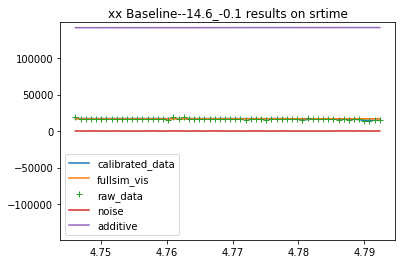

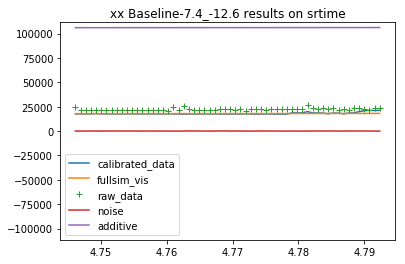

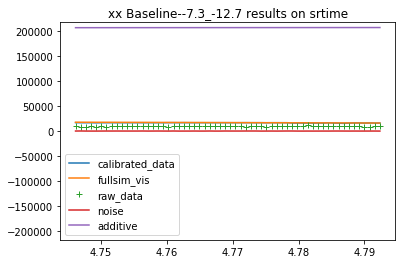

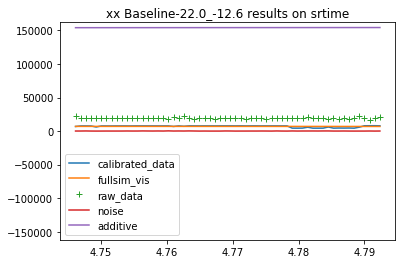

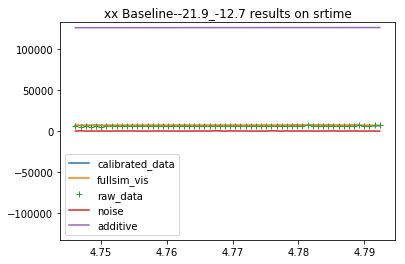

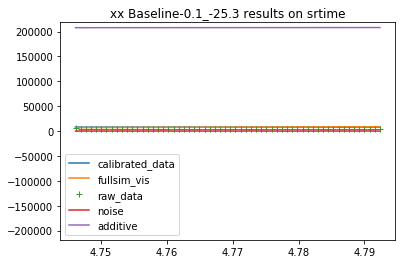

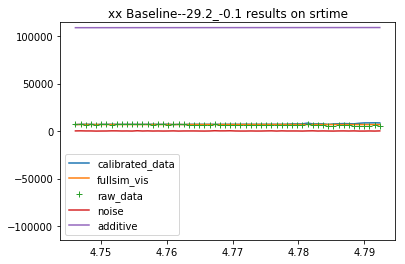

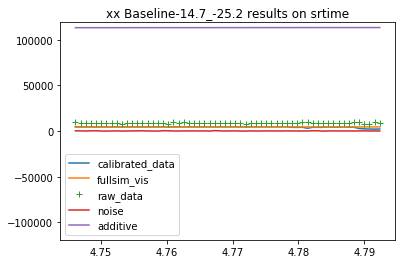

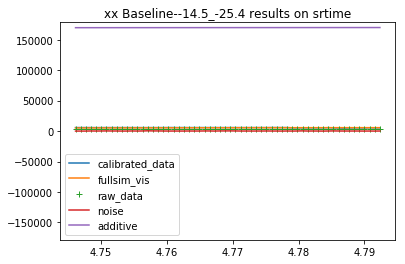

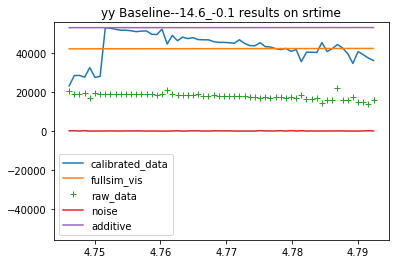

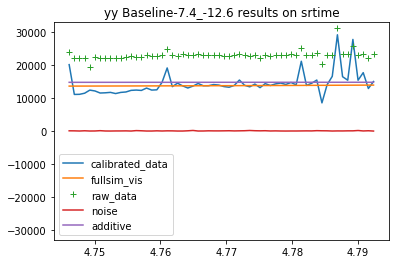

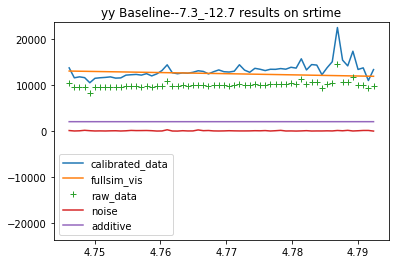

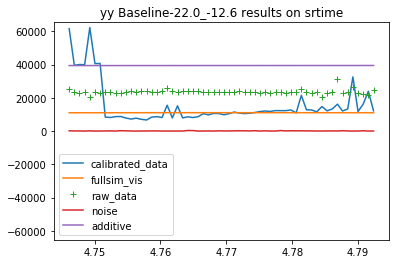

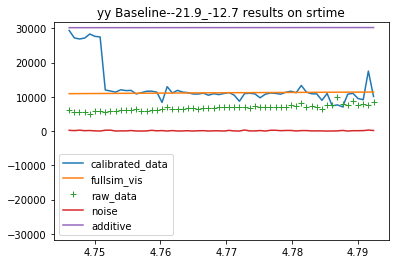

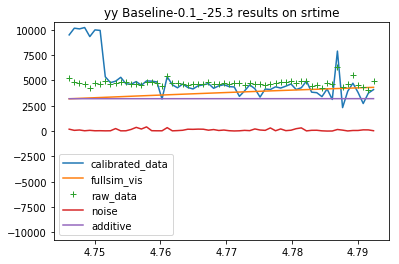

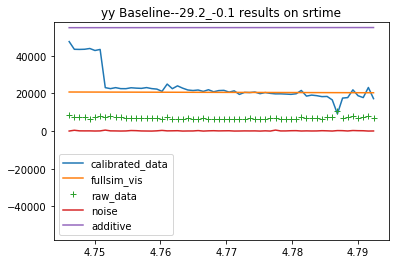

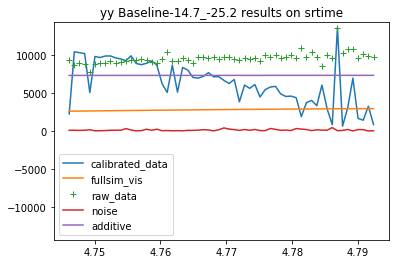

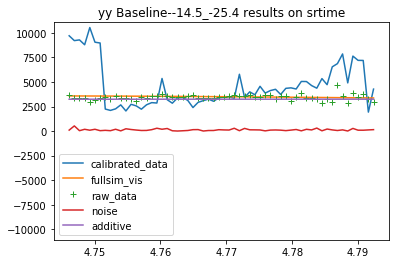

In [178]:
if plot_data_error:
	#plt.clf()
	
	cdata = get_complex_data(data)
	crdata = get_complex_data(raw_data) #/ (additive_sol[0] * (pre_ampcal) + (not pre_ampcal))
	cNi = get_complex_data(Ni)
	

	fun = np.abs
	srt = sorted((lsts - lst_offset)%24.+lst_offset)
	asrt = np.argsort((lsts - lst_offset)%24.+lst_offset)
	pncol = min(int(60. / (srt[-1] - srt[0])), 12)
	us = ubl_sort['x'][::len(ubl_sort['x'])/pncol] if len(ubl_sort['x'])/pncol >=1 else ubl_sort['x']
	figure = {}
#		plt.figure(400)
#		plt.subplots_adjust(hspace=1.2,wspace=0.7)
	for p in range(2):
#			plt.figure(400+10*p)
#			plt.subplots_adjust(hspace=1.2,wspace=0.7)
#			for nu, u in enumerate(us):
#				
#				plt.subplot(5, (len(us) + 4) / 5, nu + 1)
#				plt.plot(srt, fun(cdata[u, p][asrt]))
#				plt.plot(srt, fun(fullsim_vis[u, p][asrt]))
#				plt.plot(srt, fun(crdata[u, p][asrt]))
#				plt.plot(srt, fun(cNi[u, p][asrt])**-.5)
#				if pre_calibrate:
#					plt.plot(srt, fun(cadd[u, p][asrt]))
#				data_range = np.max([np.max(np.abs(fun(cdata[u, p]))), np.max(np.abs(fun(crdata[u, p]))), np.max(np.abs(fun(fullsim_vis[u, p]))), 5 * np.max(np.abs(fun(cNi[u, p]))), np.max(fun(cadd[u, p]))])
#				plt.title("%s Baseline-%.1f_%.1f results on srtime"%(['xx','yy'][p], used_common_ubls[u, 0], used_common_ubls[u, 1]))
#				plt.ylim([-1.05*data_range, 1.05*data_range])		
#			plt.savefig(script_dir + '/../Output/%s-dipole-precal_data_error-fullvis-%s-%.2f-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, ['xx','yy'][p], beam_freqs[ind], bnside, nside_standard))
#			plt.show(block=False)
		
		#plt.figure(500+10*p)
		#plt.subplots_adjust(hspace=1.2,wspace=0.7)
		for nu, u in enumerate(us):
			plt.figure(5000+100*p+nu)
			#plt.subplot(5, (len(us) + 4) / 5, nu + 1)
			figure[1], = plt.plot(srt, fun(cdata[u, p][asrt]), label='calibrated_data')
			figure[2], = plt.plot(srt, fun(fullsim_vis[u, p][asrt]), label='fullsim_vis')
			figure[3], = plt.plot(srt, fun(crdata[u, p][asrt]), '+', label='raw_data')
			figure[4], = plt.plot(srt, fun(cNi[u, p][asrt])**-.5, label='Ni')
			if pre_calibrate:
				figure[5], = plt.plot(srt, fun(cadd[u, p][asrt]), label='additive')
				data_range = np.max([np.max(np.abs(fun(cdata[u, p]))), np.max(np.abs(fun(crdata[u, p]))), np.max(np.abs(fun(fullsim_vis[u, p]))), np.max(fun(cadd[u, p]))]) #5 * np.max(np.abs(fun(cNi[u, p]))),
			else:
				data_range = np.max([np.max(np.abs(fun(cdata[u, p]))), np.max(np.abs(fun(crdata[u, p]))), np.max(np.abs(fun(fullsim_vis[u, p])))]) #5 * np.max(np.abs(fun(cNi[u, p])))
			plt.title("%s Baseline-%.1f_%.1f results on srtime"%(['xx','yy'][p], used_common_ubls[u, 0], used_common_ubls[u, 1]))
			plt.ylim([-1.05*data_range, 1.05*data_range])
			if pre_calibrate:
				plt.legend(handles=[figure[1], figure[2], figure[3], figure[4], figure[5]], labels=['calibrated_data', 'fullsim_vis', 'raw_data', 'noise', 'additive'], loc=0)
			else:
				plt.legend(handles=[figure[1], figure[2], figure[3], figure[4]], labels=['calibrated_data', 'fullsim_vis', 'raw_data', 'noise'], loc=0)
			plt.savefig(script_dir + '/../Output/%s-Baseline-%.1f_%.1f-dipole-precal_data_error-Full_vis-%s-%.2f-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, used_common_ubls[u, 0], used_common_ubls[u, 1], ['xx','yy'][p], freq, bnside, nside_standard))
			plt.show(block=False)
			
			
		#plt.gcf().clear()
		#plt.clf()
		#plt.close()

Del=True
if Del:
	try:
		del(crdata)
		del(cNi)
		del(cdata)
		del(cadd)
	except:
		pass
	
sys.stdout.flush()


In [179]:
################
####Use N and the par file generated by pixel_parameter_search to determine dynamic pixel parameters
################
if seek_optimal_threshs:
	par_result_filename = full_sim_filename.replace('.simvis', '_par_search.npz')
	par_file = np.load(par_result_filename)
	qualified_par_mask = (par_file['err_norm'] / np.sum(1./Ni)**.5) < dynamic_precision
	index_min_pix_in_mask = np.argmin(par_file['n_pix'][qualified_par_mask])
	thresh, valid_pix_thresh = par_file['parameters'][qualified_par_mask][index_min_pix_in_mask]
print "<<<<<<<<<<<<picked std thresh %.3f, pix thresh %.1e"%(thresh, valid_pix_thresh)

sys.stdout.flush()

<<<<<<<<<<<<picked std thresh 2.000, pix thresh 1.0e-04


In [180]:
########################################################################
########################processing dynamic pixelization######################
########################################################################
gsm_beamweighted = equatorial_GSM_standard * beam_weight
if AtNiA_only:
	valid_npix = pixel_scheme_number
	pixel_scheme_file = np.load(pixel_directory + 'pixel_scheme_%i_%s.npz'%(valid_npix,freq))
	fake_solution_map = pixel_scheme_file['gsm']
	thetas = pixel_scheme_file['thetas']
	phis= pixel_scheme_file['phis']
	sizes= pixel_scheme_file['sizes']
	nside_distribution= pixel_scheme_file['nside_distribution']
	final_index= pixel_scheme_file['final_index']
	npix = pixel_scheme_file['n_fullsky_pix']
	valid_pix_mask= pixel_scheme_file['valid_pix_mask']
	thresh= pixel_scheme_file['thresh']
else:
	nside_distribution = np.zeros(12 * nside_standard ** 2)
	final_index = np.zeros(12 * nside_standard ** 2, dtype=int)
	thetas, phis, sizes = [], [], []
	abs_thresh = np.mean(gsm_beamweighted) * thresh
	pixelize(gsm_beamweighted, nside_distribution, nside_standard, nside_start, abs_thresh,
			 final_index, thetas, phis, sizes)
	npix = len(thetas)
	valid_pix_mask = hpf.get_interp_val(gsm_beamweighted, thetas, phis, nest=True) > valid_pix_thresh * max(gsm_beamweighted)
	valid_npix = np.sum(valid_pix_mask)
	print '>>>>>>VALID NPIX =', valid_npix

	fake_solution_map = np.zeros_like(thetas)      
	for i in range(len(fake_solution_map)):
		fake_solution_map[i] = np.sum(equatorial_GSM_standard[final_index == i])
	fake_solution_map = fake_solution_map[valid_pix_mask]
	sizes = np.array(sizes)[valid_pix_mask]
	thetas = np.array(thetas)[valid_pix_mask]
	phis = np.array(phis)[valid_pix_mask]
	np.savez(pixel_directory + 'pixel_scheme_%i_%s.npz'%(valid_npix,freq), gsm=fake_solution_map, thetas=thetas, phis=phis, sizes=sizes, nside_distribution=nside_distribution, final_index=final_index, n_fullsky_pix=npix, valid_pix_mask=valid_pix_mask, thresh=thresh)#thresh is in there for idiotic reason  due to unneccessary inclusion of thresh in A filename

if not fit_for_additive:
	fake_solution = np.copy(fake_solution_map)
else:
	fake_solution = np.concatenate((fake_solution_map, np.zeros(4 * nUBL_used)))

def sol2map(sol):
	solx = sol[:valid_npix]
	full_sol = np.zeros(npix)
	full_sol[valid_pix_mask] = solx / sizes
	return full_sol[final_index]

def sol2additive(sol):
	return np.transpose(sol[valid_npix:].reshape(nUBL_used, 2, 2), (1, 0, 2))#ubl by pol by re/im before transpose


>>>>>>VALID NPIX = 10420


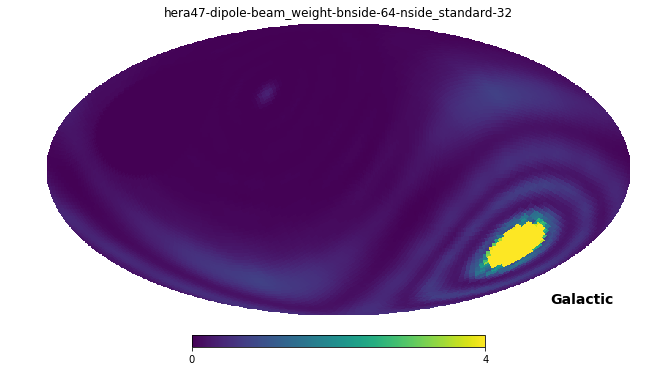

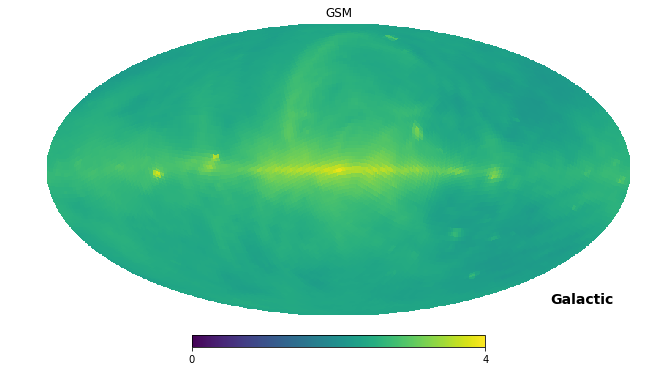

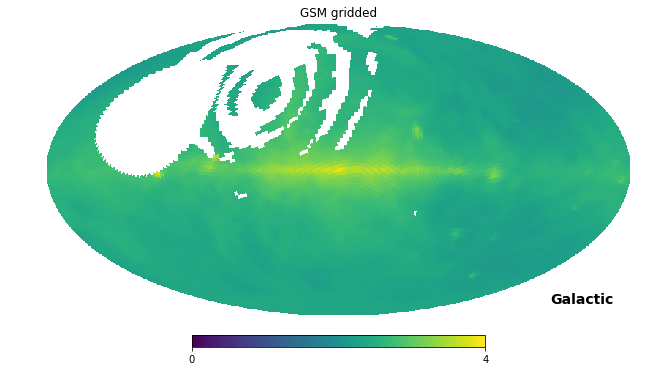

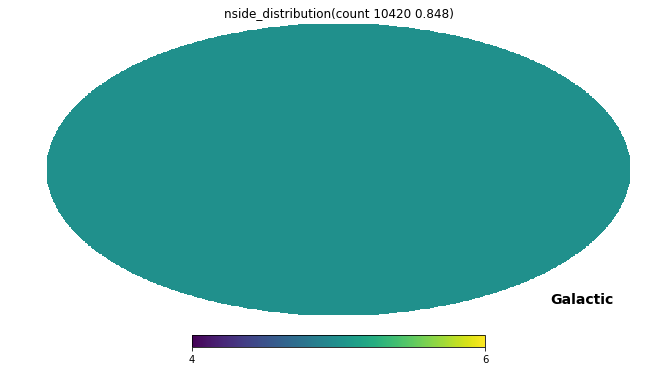

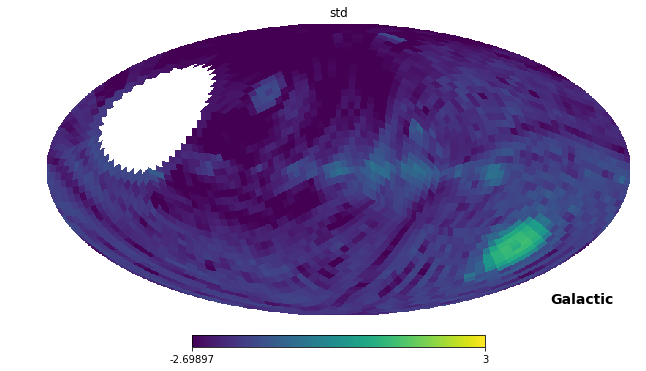

In [181]:
# final_index_filename = datadir + tag + '_%i.dyind%i_%.3f'%(nside_standard, npix, thresh)
# final_index.astype('float32').tofile(final_index_filename)
# sizes_filename = final_index_filename.replace('dyind', "dysiz")
# np.array(sizes).astype('float32').tofile(sizes_filename)
if plot_pixelization:
	##################################################################
	####################################sanity check########################
	###############################################################
	# npix = 0
	# for i in nside_distribution:
	# npix += i**2/nside_standard**2
	# print npix, len(thetas)
	stds = np.std((equatorial_GSM_standard * beam_weight).reshape(12 * nside_standard ** 2 / 4, 4), axis=1)
	plotcoord = 'CG'
    
	##################################################################
	####################################plotting########################
	###############################################################
	with warnings.catch_warnings():
		warnings.filterwarnings("ignore", category=RuntimeWarning)
		#plt.clf()
		plt.figure(50)
		hpv.mollview(beam_weight, min=0, max=4, coord=plotcoord, title='%s-dipole-beam_weight-bnside-%s-nside_standard-%s'%(INSTRUMENT, bnside, nside_standard), nest=True)
		plt.savefig(script_dir + '/../Output/%s-%s-dipole-beam_weight-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, freq, bnside, nside_standard))
		hpv.mollview(np.log10(equatorial_GSM_standard), min=0, max=4, coord=plotcoord, title='GSM', nest=True)
		plt.savefig(script_dir + '/../Output/GSM-3C-for-%s-%s-bnside-%s.pdf'%(INSTRUMENT, freq, bnside))
		hpv.mollview(np.log10(sol2map(fake_solution)[:len(equatorial_GSM_standard)]), min=0, max=4, coord=plotcoord,
					 title='GSM gridded', nest=True)
		plt.savefig(script_dir + '/../Output/maskedfsol_GSM-3C-%s-%s-dipole-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, freq, bnside, nside_standard))
		hpv.mollview(np.log2(nside_distribution), min=np.log2(nside_start), max=np.log2(nside_standard),
					 coord=plotcoord,
					 title='nside_distribution(count %i %.3f)' % (len(thetas), float(len(thetas)) / (12 * nside_standard ** 2)), nest=True)
		plt.savefig(script_dir + '/../Output/nside_distribution-%s-%s-dipole-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, freq, bnside, nside_standard))
		hpv.mollview(np.log10(stds / abs_thresh), min=np.log10(thresh) - 3, max=3, coord=plotcoord, title='std',
					 nest=True)
		plt.savefig(script_dir + '/../Output/stds-beam_weight_GSM-%s-%s-dipole-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, freq, bnside, nside_standard))
		plt.show(block=False)
		#plt.gcf().clear()

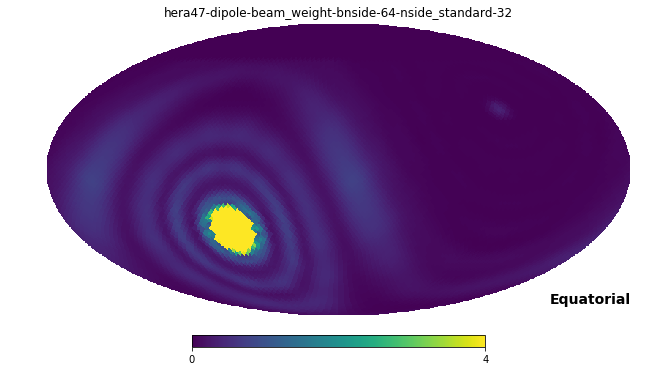

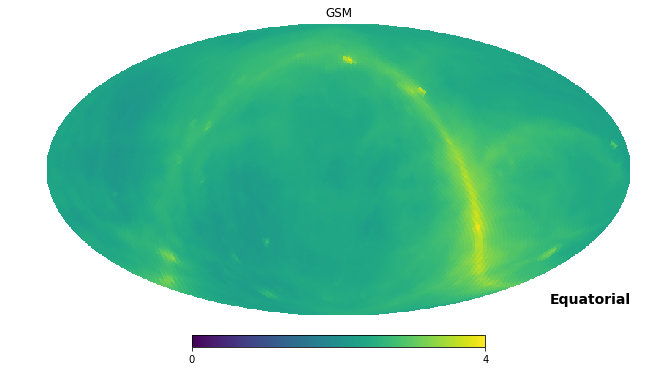

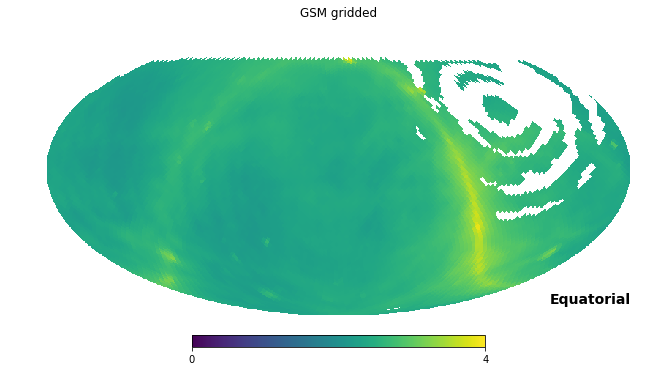

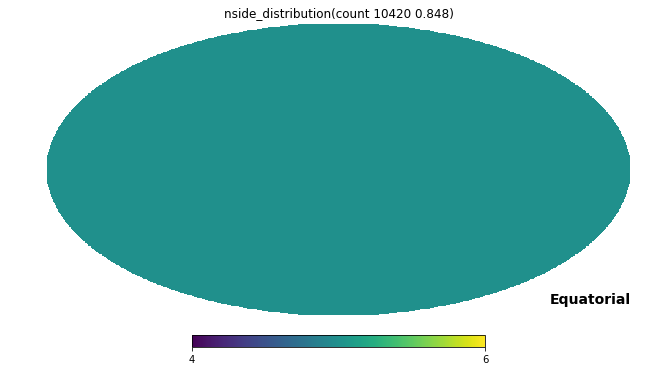

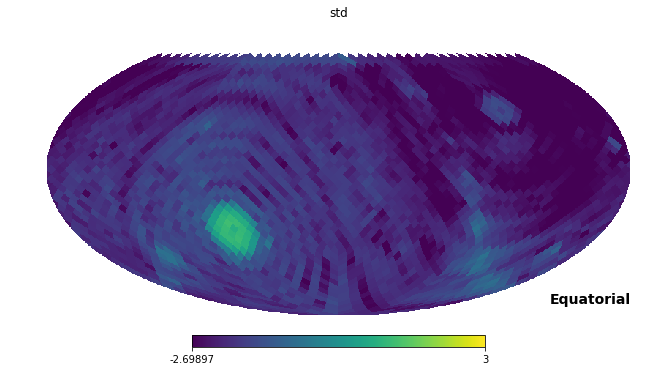

In [182]:
if plot_pixelization:
	##################################################################
	####################################sanity check########################
	###############################################################
	# npix = 0
	# for i in nside_distribution:
	# npix += i**2/nside_standard**2
	# print npix, len(thetas)

	stds = np.std((equatorial_GSM_standard * beam_weight).reshape(12 * nside_standard ** 2 / 4, 4), axis=1)
	plotcoord = 'C'
	##################################################################
	####################################plotting########################
	###############################################################
	with warnings.catch_warnings():
		warnings.filterwarnings("ignore", category=RuntimeWarning)
		#plt.clf()
		plt.figure(50)
		hpv.mollview(beam_weight, min=0, max=4, coord=plotcoord, title='%s-dipole-beam_weight-bnside-%s-nside_standard-%s'%(INSTRUMENT, bnside, nside_standard), nest=True)
		plt.savefig(script_dir + '/../Output/%s-%s-dipole-beam_weight-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, freq, bnside, nside_standard))
		hpv.mollview(np.log10(equatorial_GSM_standard), min=0, max=4, coord=plotcoord, title='GSM', nest=True)
		plt.savefig(script_dir + '/../Output/GSM-3C-for-%s-%s-bnside-%s.pdf'%(INSTRUMENT, freq, bnside))
		hpv.mollview(np.log10(sol2map(fake_solution)[:len(equatorial_GSM_standard)]), min=0, max=4, coord=plotcoord,
					 title='GSM gridded', nest=True)
		plt.savefig(script_dir + '/../Output/maskedfsol_GSM-3C-%s-%s-dipole-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, freq, bnside, nside_standard))
		hpv.mollview(np.log2(nside_distribution), min=np.log2(nside_start), max=np.log2(nside_standard),
					 coord=plotcoord,
					 title='nside_distribution(count %i %.3f)' % (len(thetas), float(len(thetas)) / (12 * nside_standard ** 2)), nest=True)
		plt.savefig(script_dir + '/../Output/nside_distribution-%s-%s-dipole-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, freq, bnside, nside_standard))
		hpv.mollview(np.log10(stds / abs_thresh), min=np.log10(thresh) - 3, max=3, coord=plotcoord, title='std',
					 nest=True)
		plt.savefig(script_dir + '/../Output/stds-beam_weight_GSM-%s-%s-dipole-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, freq, bnside, nside_standard))
		plt.show(block=False)
		#plt.gcf().clear()

In [183]:
##################################################################
####################compute dynamic A matrix########################
###############################################################
A_tag = 'A_dI'
A_filename = A_tag + '_u%i_t%i_p%i_n%i_%i_b%i_%.3f_v%.1f' % (nUBL_used, nt_used, valid_npix, nside_start, nside_standard, bnside, thresh, A_version)
A_path = datadir + tag + A_filename
AtNiA_tag = 'AtNiA_N%s'%vartag
if not fit_for_additive:
	AtNiA_tag += "_noadd"
elif crosstalk_type == 'autocorr':
	AtNiA_tag += "_autocorr"
if pre_ampcal:
	AtNiA_tag += "_ampcal"
AtNiA_filename = AtNiA_tag + A_filename
AtNiA_path = datadir + tag + AtNiA_filename
if os.path.isfile(AtNiA_path) and AtNiA_only and not force_recompute:
	sys.exit(0)


def get_A(additive_A=None):
	if os.path.isfile(A_path) and not force_recompute:
		print "Reading A matrix from %s" % A_path
		sys.stdout.flush()
		A = np.fromfile(A_path, dtype='complex128').reshape((nUBL_used, 2, nt_used, valid_npix + 4 * nUBL_used))
	else:

		print "Computing A matrix..."
		sys.stdout.flush()
		A = np.empty((nUBL_used, 2, nt_used, valid_npix + 4 * nUBL_used), dtype='complex128')
		timer = time.time()
		for n in range(valid_npix):
			ra = phis[n]
			dec = PI / 2 - thetas[n]
			print "\r%.1f%% completed, %f minutes left" % (
			100. * float(n) / (valid_npix), float(valid_npix - n) / (n + 1) * (float(time.time() - timer) / 60.)),
			sys.stdout.flush()

			A[:, 0, :, n] = vs.calculate_pointsource_visibility(ra, dec, used_common_ubls, freq, beam_heal_equ=beam_heal_equ_x, tlist=lsts) / 2 #xx and yy are each half of I
			A[:, -1, :, n] = vs.calculate_pointsource_visibility(ra, dec, used_common_ubls, freq, beam_heal_equ=beam_heal_equ_y, tlist=lsts) / 2



		print "%f minutes used" % (float(time.time() - timer) / 60.)
		sys.stdout.flush()
		A.tofile(A_path)

	# #put in autocorr regardless of whats saved on disk
	# for i in range(nUBL_used):
	#     for p in range(2):
	#         A[i, p, :, valid_npix + 4 * i + 2 * p] = 1. * autocorr_vis_normalized[p]
	#         A[i, p, :, valid_npix + 4 * i + 2 * p + 1] = 1.j * autocorr_vis_normalized[p]

	A.shape = (nUBL_used * 2 * nt_used, A.shape[-1])
	if not fit_for_additive:
		A = A[:, :valid_npix]
	else:
		A[:, valid_npix:] = additive_A[:, 1:]
	# Merge A
	try:
		return np.concatenate((np.real(A), np.imag(A))).astype('complex128')
	except MemoryError:
		print "Not enough memory, concatenating A on disk ", A_path + 'tmpre', A_path + 'tmpim',
		sys.stdout.flush()
		Ashape = list(A.shape)
		Ashape[0] = Ashape[0] * 2
		np.real(A).tofile(A_path + 'tmpre')
		np.imag(A).tofile(A_path + 'tmpim')
		del (A)
		os.system("cat %s >> %s" % (A_path + 'tmpim', A_path + 'tmpre'))

		os.system("rm %s" % (A_path + 'tmpim'))
		A = np.fromfile(A_path + 'tmpre', dtype='complex128').reshape(Ashape)
		os.system("rm %s" % (A_path + 'tmpre'))
		print "done."
		sys.stdout.flush()
		return A.astype('complex128')

if not fit_for_additive:
	A = get_A()
else:
	A = get_A(additive_A)
	
Ashape0, Ashape1 = A.shape

# for ipix in hpf.ang2pix(nside_standard, thetas, phis, nest=True):
#     if

print "Memory usage: %.3fMB" % (resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1000)
sys.stdout.flush()

print "Memory usage: %.3fMB" % (resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1000)
sys.stdout.flush()

sys.stdout.flush()


def get_vis_normalization(data, clean_sim_data):
	a = np.linalg.norm(data.reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1]), axis=0).flatten()
	b = np.linalg.norm(clean_sim_data.reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1]), axis=0).flatten()
	return a.dot(b) / b.dot(b)


Computing A matrix...


78.1% completed, 0.301263 minutes left

100.0% completed, 0.000132 minutes left                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [184]:
tlist

array([15.01222222, 15.01527778, 15.01833333, 15.02138889, 15.02416667,
       15.02722222, 15.03027778, 15.03333333, 15.03611111, 15.03916667,
       15.04222222, 15.045     , 15.04805556, 15.05111111, 15.05416667,
       15.05694444, 15.06      , 15.06305556, 15.06611111, 15.06888889,
       15.07194444, 15.075     , 15.07805556, 15.08083333, 15.08388889,
       15.08694444, 15.09      , 15.09277778, 15.09583333, 15.09888889,
       15.10166667, 15.10472222, 15.10777778, 15.11083333, 15.11361111,
       15.11666667, 15.11972222, 15.12277778, 15.12555556, 15.12861111,
       15.13166667, 15.13472222, 15.1375    , 15.14055556, 15.14361111,
       15.14666667, 15.14944444, 15.1525    , 15.15555556, 15.15833333,
       15.16138889, 15.16444444, 15.1675    , 15.17027778, 15.17333333,
       15.17638889, 15.17944444, 15.18222222, 15.18527778, 15.18833333])

In [185]:
Integration_Time
np.sum(Ni**-1)**.5

(7259.302183846295+0j)

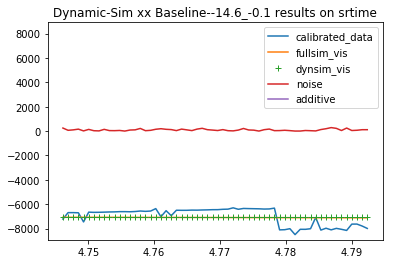

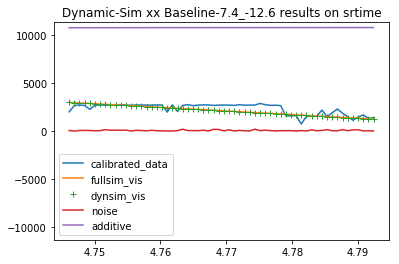

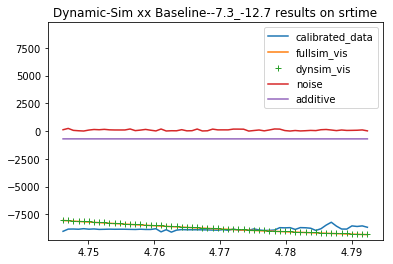

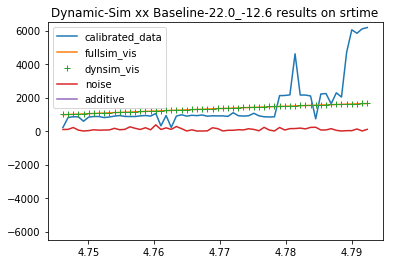

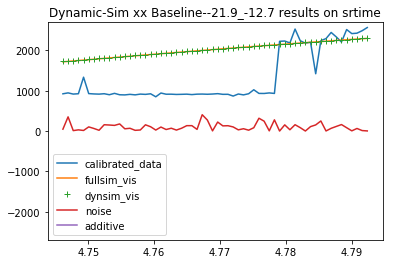

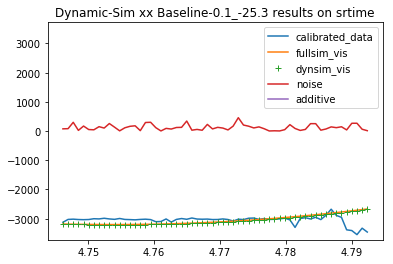

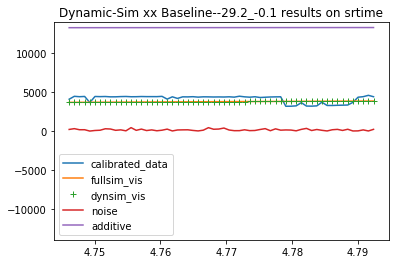

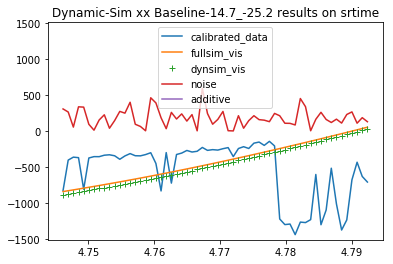

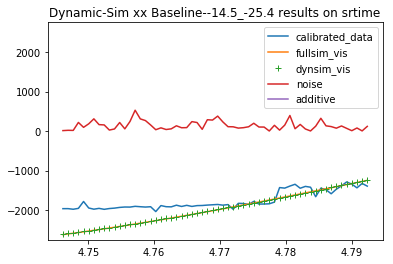

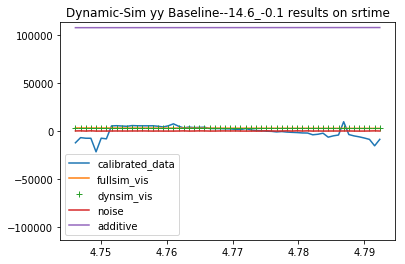

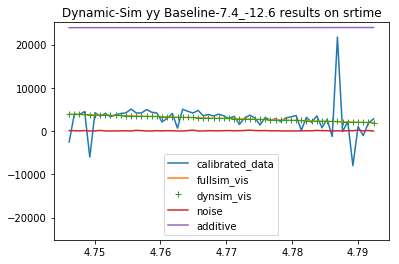

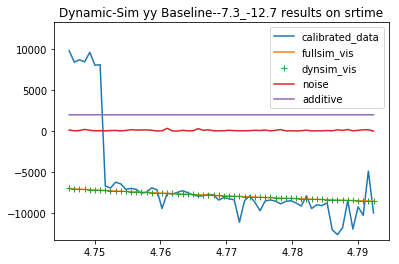

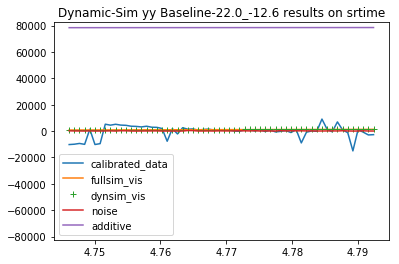

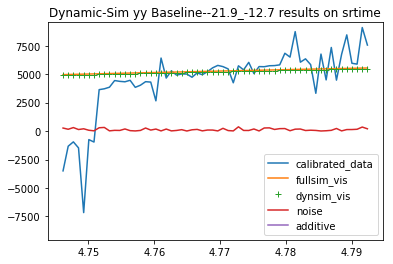

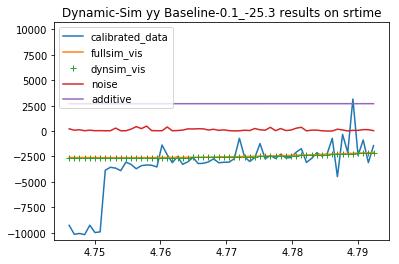

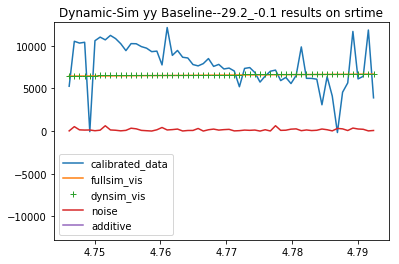

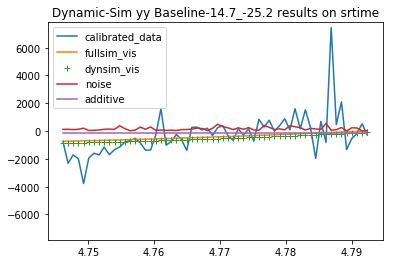

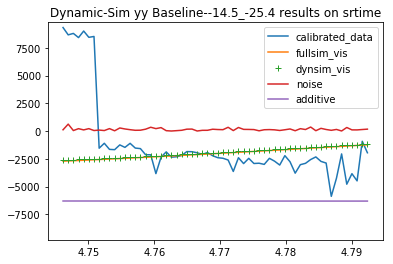

total deviation between dynamic and full sim compared to sim:  0.004945533540446285
total deviation between dynamic and full sim compared to data noise:  (0.33383054725348443+0j)


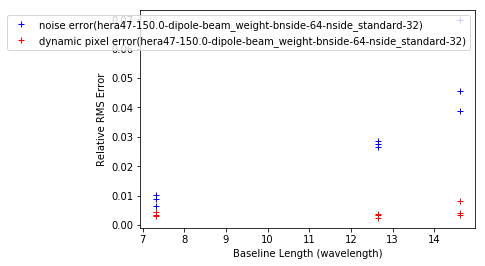

Normalization from visibilities 1.049237269348794


In [186]:
##############
# simulate visibilities according to the pixelized A matrix
##############
clean_sim_data = A.dot(fake_solution.astype(A.dtype))

if plot_data_error:
	cdata = get_complex_data(data)
	cdynamicmodel = get_complex_data(clean_sim_data)
	cNi = get_complex_data(Ni)
	if pre_calibrate:
		cadd = get_complex_data(additive_term)

	fun = np.imag
	srt = sorted((lsts - lst_offset)%24.+lst_offset)
	asrt = np.argsort((lsts - lst_offset)%24.+lst_offset)
	pncol = min(int(60. / (srt[-1] - srt[0])), 12)
	us = ubl_sort['x'][::len(ubl_sort['x'])/pncol] if len(ubl_sort['x'])/pncol >=1 else ubl_sort['x']
	#plt.clf()
#	plt.figure(60)
#	for p in range(2):
#		for nu, u in enumerate(us):
#
#			plt.subplot(2, len(us), len(us) * p + nu + 1)
#			plt.plot(srt, fun(cdata[u, p][asrt]))
#			plt.plot(srt, fun(fullsim_vis[u, p][asrt]))
#			plt.plot(srt, fun(cdynamicmodel[u, p][asrt]))
#			plt.plot(srt, fun(cNi[u, p][asrt])**-.5)
#			if pre_calibrate:
#				plt.plot(srt, fun(cadd[u, p][asrt]))
#			data_range = np.max([np.max(np.abs(fun(cdata[u, p]))), np.max(np.abs(fun(fullsim_vis[u, p]))), 5 * np.max(np.abs(fun(cNi[u, p])))])
#			plt.title("%.1f,%.1f"%(used_common_ubls[u, 0], used_common_ubls[u, 1]))
#			plt.ylim([-1.05*data_range, 1.05*data_range])
#
#	print "total deviation between dynamic and full sim compared to sim", la.norm(fullsim_vis - cdynamicmodel) / la.norm(fullsim_vis)
#	print "total deviation between dynamic and full sim compared to data noise", la.norm(fullsim_vis - cdynamicmodel) / np.sum(Ni**-1)**.5
#	plt.savefig(script_dir + '/../Output/data_error_dynamic-%s-dipole-bnside-%s-nside_standard-%s.png'%(INSTRUMENT, bnside, nside_standard))
#	plt.show(block=False)
	
	figure_D={}
	for p in range(2):
		for nu, u in enumerate(us):
			plt.figure(6000+100*p+nu)
			#plt.subplot(2, len(us), len(us) * p + nu + 1)
			figure_D[1], = plt.plot(srt, fun(cdata[u, p][asrt]), label='calibrated_data')
			figure_D[2], = plt.plot(srt, fun(fullsim_vis[u, p][asrt]), label='fullsim_vis')
			figure_D[3], = plt.plot(srt, fun(cdynamicmodel[u, p][asrt]), '+', label='dynsim_vis')
			figure_D[4], = plt.plot(srt, fun(cNi[u, p][asrt])**-.5, label='Ni')
			if pre_calibrate:
				figure_D[5], = plt.plot(srt, fun(cadd[u, p][asrt]), label='additive')
				data_range = np.max([np.max(np.abs(fun(cdata[u, p]))), np.max(np.abs(fun(fullsim_vis[u, p]))), np.max(np.abs(fun(cdynamicmodel[u, p]))), np.max(fun(cadd[u, p]))]) # 5 * np.max(np.abs(fun(cNi[u, p])))
			else:	
				data_range = np.max([np.max(np.abs(fun(cdata[u, p]))), np.max(np.abs(fun(fullsim_vis[u, p]))), np.max(np.abs(fun(cdynamicmodel[u, p])))]) # 5 * np.max(np.abs(fun(cNi[u, p])))
			plt.title("Dynamic-Sim %s Baseline-%.1f_%.1f results on srtime"%(['xx','yy'][p], used_common_ubls[u, 0], used_common_ubls[u, 1]))
			plt.ylim([-1.05*data_range, 1.05*data_range])
			if pre_calibrate:
				plt.legend(handles=[figure_D[1], figure_D[2], figure_D[3], figure_D[4], figure_D[5]], labels=['calibrated_data', 'fullsim_vis', 'dynsim_vis', 'noise', 'additive'], loc=0)
			else:
				plt.legend(handles=[figure_D[1], figure_D[2], figure_D[3], figure_D[4]], labels=['calibrated_data', 'fullsim_vis', 'dynsim_vis', 'noise'], loc=0)
			plt.savefig(script_dir + '/../Output/%s-Baseline-%.1f_%.1f-dipole-precal_data_error-Dynamic_Vis-%s-%.2f-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, used_common_ubls[u, 0], used_common_ubls[u, 1], ['xx','yy'][p], freq, bnside, nside_standard))
			plt.show(block=False)
			#plt.clf()
			#plt.gcf().clear()
	print "total deviation between dynamic and full sim compared to sim: ", la.norm(fullsim_vis - cdynamicmodel) / la.norm(fullsim_vis)
	print "total deviation between dynamic and full sim compared to data noise: ", la.norm(fullsim_vis - cdynamicmodel) / np.sum(Ni**-1)**.5
	
	plt.figure(70)
	try:
		fullsim_vis2 = 4 * np.fromfile(datadir + tag + '_p2_u%i_t%i_nside%i_bnside%i.simvis'%(nUBL_used+1, nt_used, nside_standard / 2, bnside), dtype='complex128').reshape((2, nUBL_used+1, nt_used))[:, :-1].transpose((1, 0 ,2))
		plt.plot(la.norm(used_common_ubls, axis=-1)*freq/C, la.norm(fullsim_vis - fullsim_vis2, axis=-1)[:, 0] / la.norm(fullsim_vis, axis=-1)[:, 0], 'g+', label='nside error(%s-dipole-beam_weight-bnside-%s-nside_standard-%s)'%(INSTRUMENT, bnside, nside_standard))
		plt.savefig(script_dir + '/../Output/nside_error-%s-dipole-beam_weight-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, bnside, nside_standard))
	except:
		try:
			fullsim_vis2 = .25 * np.fromfile(datadir + tag + '_p2_u%i_t%i_nside%i_bnside%i.simvis'%(nUBL_used+1, nt_used, nside_standard * 2, bnside), dtype='complex128').reshape((2, nUBL_used+1, nt_used))[:, :-1].transpose((1, 0 ,2))
			plt.plot(la.norm(used_common_ubls, axis=-1)*freq/C, la.norm(fullsim_vis - fullsim_vis2, axis=-1)[:, 0] / la.norm(fullsim_vis, axis=-1)[:, 0], 'g+', label='nside error(%s-dipole-beam_weight-bnside-%s-nside_standard-%s)'%(INSTRUMENT, bnside, nside_standard))
			plt.savefig(script_dir + '/../Output/nside_error-%s-dipole-beam_weight-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, bnside, nside_standard))
		except:
			pass
	#plt.clf()
	plt.plot(la.norm(used_common_ubls, axis=-1)*freq/C, np.sum(2. / np.real(get_complex_data(Ni)), axis=-1)[:, 0]**.5 / la.norm(fullsim_vis, axis=-1)[:, 0], 'b+', label='noise error(%s-%s-dipole-beam_weight-bnside-%s-nside_standard-%s)'%(INSTRUMENT, freq, bnside, nside_standard))
#	plt.legend()
#	plt.xlabel('Baseline Length (wavelength)')
#	plt.ylabel('Relative RMS Error')
	plt.savefig(script_dir + '/../Output/noise_error-%s-dipole-beam_weight-bnside-%s-nside_standard-%s.png'%(INSTRUMENT, bnside, nside_standard))
#	plt.show(block=False)
#	plt.gcf().clear()
	#plt.clf()
	plt.plot(la.norm(used_common_ubls, axis=-1)*freq/C, la.norm(fullsim_vis - cdynamicmodel, axis=-1)[:, 0] / la.norm(fullsim_vis, axis=-1)[:, 0], 'r+', label='dynamic pixel error(%s-%s-dipole-beam_weight-bnside-%s-nside_standard-%s)'%(INSTRUMENT, freq, bnside, nside_standard))
	plt.legend(loc=0)
	plt.xlabel('Baseline Length (wavelength)')
	plt.ylabel('Relative RMS Error')
	plt.savefig(script_dir + '/../Output/dynamic_pixel_error-%s-dipole-beam_weight-bnside-%s-nside_standard-%s.png'%(INSTRUMENT, bnside, nside_standard))
	plt.show(block=False)
	#plt.gcf().clear()


vis_normalization = get_vis_normalization(data, stitch_complex_data(fullsim_vis))
print "Normalization from visibilities", vis_normalization

Del=True
if Del:
	try:
		del(cdata)
		del(cNi)
		del(cdynamicmodel)
	except:
		pass

sys.stdout.flush()



In [187]:
##renormalize the model
fake_solution *= vis_normalization # GSM Masked and being Normalized (abs calibration), Clean
clean_sim_data *= vis_normalization # Dynamic Simulated, Clean, being Normalized (abs calibration)
fullsim_vis *= vis_normalization # Full Simulated, Clean, being Normalized (abs calibration)
sim_data = stitch_complex_data(fullsim_vis) + np.random.randn(len(data)) / Ni ** .5 # Full Simulated, being Normalized (abs calibration), Noise
# "data" is Calibrated Full Simulated Visibilities

#add additive term
if fit_for_additive:
	sim_data.shape = (2, nUBL_used, 2, nt_used)
	sim_additive = np.random.randn(2, nUBL_used, 2) * np.median(np.abs(data)) / 2.
	sim_data = sim_data + np.array([np.outer(sim_additive[..., p], autocorr_vis_normalized[p]).reshape((2, nUBL_used, nt_used)) for p in range(2)]).transpose((1, 2, 0, 3))#sim_additive[..., None]
	sim_data = sim_data.flatten()


In [188]:
# compute AtNi.y
AtNi_data = np.transpose(A).dot((data * Ni).astype(A.dtype))
AtNi_sim_data = np.transpose(A).dot((sim_data * Ni).astype(A.dtype))
AtNi_clean_sim_data = np.transpose(A).dot((clean_sim_data * Ni).astype(A.dtype))


In [189]:
# compute S
print "computing S...",
sys.stdout.flush()
timer = time.time()

#diagonal of S consists of S_diag_I and S-diag_add
if S_type == 'none':
	S_diag = np.ones(Ashape1) * np.max(equatorial_GSM_standard)**2 * 1.e12
else:
	if 'lowI' in S_type:
		I_supress = 25.
	elif 'minI' in S_type:
		I_supress = 250.
	elif 'min2I' in S_type:
		I_supress = 2500
	elif 'min3I' in S_type:
		I_supress = 2.5*1.e4
	elif 'min4I' in S_type:
		I_supress = 2.5*1.e5
	elif 'min5I' in S_type:
		I_supress = 2.5*1.e6
	elif 'min6I' in S_type:
		I_supress = 2.5*1.e7
	elif 'min7I' in S_type:
		I_supress = 2.5*1.e8
	elif 'min8I' in S_type:
		I_supress = 2.5*1.e9
	elif 'min9I' in S_type:
		I_supress = 2.5*1.e10
	elif 'min10I' in S_type:
		I_supress = 2.5*1.e11
	elif 'maxI' in S_type:
		I_supress = 2.5*1.e-1
	elif 'ma2I' in S_type:
		I_supress = 2.5*1.e-2
	elif 'max3I' in S_type:
		I_supress = 2.5*1.e-3
	elif 'max4I' in S_type:
		I_supress = 2.5*1.e-4
	elif 'max5I' in S_type:
		I_supress = 2.5*1.e-5
	elif 'max6I' in S_type:
		I_supress = 2.5*1.e-6
	elif 'max7I' in S_type:
		I_supress = 2.5*1.e-7
	elif 'max8I' in S_type:
		I_supress = 2.5*1.e-8
	elif 'max9I' in S_type:
		I_supress = 2.5*1.e-9
	else:
		I_supress = 1.
		
	if 'Iuniform' in S_type:
		S_diag_I = (np.median(equatorial_GSM_standard) * sizes)**2 / I_supress
	else:
		S_diag_I = fake_solution_map ** 2 / I_supress  # np.array([[1+pol_frac,0,0,1-pol_frac],[0,pol_frac,pol_frac,0],[0,pol_frac,pol_frac,0],[1-pol_frac,0,0,1+pol_frac]]) / 4 * (2*sim_x_clean[i])**2

	data_max = np.transpose(np.percentile(np.abs(data.reshape((2, nUBL_used, 2, nt_used))), 95, axis=-1), (1, 2, 0)).flatten()
	if 'min2add' in S_type:
		add_supress = 1000000.
	elif 'minadd' in S_type:
		add_supress = 10000.
	elif 'lowadd' in S_type:
		add_supress = 100.
	else:
		add_supress = 1

	if 'adduniform' in S_type:
		S_diag_add = np.ones(nUBL_used * 4) * np.median(data_max)**2 / add_supress
	else:
		S_diag_add = data_max**2 / add_supress

	if not fit_for_additive:
		S_diag = S_diag_I.astype('complex128')
	else:
		S_diag = np.concatenate((S_diag_I, S_diag_add)).astype('complex128')
	print "Done."
	print "%f minutes used" % (float(time.time() - timer) / 60.)
	sys.stdout.flush()


computing S... Done.
0.000076 minutes used


In [190]:
# compute (AtNiA+Si)i
precision = 'complex128'
AtNiAi_tag = 'AtNiASii'
if not fit_for_additive:
	AtNiAi_version = 0.3
elif crosstalk_type == 'autocorr':
	AtNiAi_version = 0.2
else:
	AtNiAi_version = 0.1
if pre_ampcal:
	AtNiAi_version += 1.
rcond_list = 10.**np.arange(-9., -2., 1.)

AtNiAi_candidate_files = glob.glob(datadir + tag + AtNiAi_tag + '_S%s_RE*_N%s_v%.1f'%(S_type, vartag, AtNiAi_version) + A_filename)
if len(AtNiAi_candidate_files) > 0 and not force_recompute_AtNiAi and not force_recompute and not force_recompute_S and not AtNiA_only:
	rcond = 10**min([float(fn.split('_RE')[1].split('_N')[0]) for fn in AtNiAi_candidate_files])

	AtNiAi_filename = AtNiAi_tag + '_S%s_RE%.1f_N%s_v%.1f'%(S_type, np.log10(rcond), vartag, AtNiAi_version) + A_filename
	AtNiAi_path = datadir + tag + AtNiAi_filename

	print "Reading Regularized AtNiAi...",
	sys.stdout.flush()
	AtNiAi = sv.InverseCholeskyMatrix.fromfile(AtNiAi_path, len(S_diag), precision)
else:
	if os.path.isfile(AtNiA_path) and not force_recompute:
		print "Reading AtNiA...",
		sys.stdout.flush()
		AtNiA = np.fromfile(AtNiA_path, dtype=precision).reshape((Ashape1, Ashape1))
	else:
		print "Allocating AtNiA..."
		sys.stdout.flush()
		timer = time.time()
		AtNiA = np.zeros((A.shape[1], A.shape[1]), dtype=precision)
		print "Computing AtNiA...", datetime.datetime.now()
		sys.stdout.flush()
		ATNIA(A, Ni, AtNiA)
		print "%f minutes used" % (float(time.time() - timer) / 60.)
		sys.stdout.flush()
		AtNiA.tofile(AtNiA_path)
	if AtNiA_only:
		sys.exit(0)
	del (A)
	AtNiA_diag = np.diagonal(AtNiA)
	print "Computing Regularized AtNiAi, %s, expected time %.1f min"%(datetime.datetime.now(), 88. * (len(S_diag) / 4.6e4)**3.),
	sys.stdout.flush()
	timer = time.time()
	# if la.norm(S) != la.norm(np.diagonal(S)):
	#     raise Exception("Non-diagonal S not supported yet")

	for rcond in rcond_list:
		#add Si on top of AtNiA without renaming AtNiA to save memory
		maxAtNiA = np.max(AtNiA)
		AtNiA.shape = (len(AtNiA) ** 2)
		if Add_S_diag:
			AtNiA[::len(S_diag) + 1] += 1./S_diag

		print 'trying', rcond,
		sys.stdout.flush()
		try:
			AtNiAi_filename = AtNiAi_tag + '_S%s_RE%.1f_N%s_v%.1f'%(S_type, np.log10(rcond), vartag, AtNiAi_version) + A_filename
			AtNiAi_path = datadir + tag + AtNiAi_filename
			if Add_Rcond:
				AtNiA[::len(S_diag) + 1] += maxAtNiA * rcond
			AtNiA.shape = (Ashape1, Ashape1)
			AtNiAi = sv.InverseCholeskyMatrix(AtNiA).astype(precision)
			del(AtNiA)
			AtNiAi.tofile(AtNiAi_path, overwrite=True)
			print "%f minutes used" % (float(time.time() - timer) / 60.)
			print "regularization stength", (maxAtNiA * rcond)**-.5, "median GSM ranges between", np.median(equatorial_GSM_standard) * min(sizes), np.median(equatorial_GSM_standard) * max(sizes)
			break
		except:
			AtNiA[::len(S_diag) + 1] -= maxAtNiA * rcond
			continue

sys.stdout.flush()


Allocating AtNiA...
Computing AtNiA... 2018-03-07 17:53:17.072124
Estimated time for A 2160 by 10456 3.06992844288 minutes 0/20: 0.0mins 1/20: 0.1mins 2/20: 0.0mins 3/20: 0.0mins 4/20: 0.0mins 5/20: 0.0mins 6/20: 0.0mins 7/20: 0.0mins 8/20: 0.0mins 9/20: 0.0mins 10/20: 0.0mins 11/20: 0.0mins 12/20: 0.0mins 13/20: 0.0mins 14/20: 0.0mins 15/20: 0.0mins 16/20: 0.0mins 17/20: 0.0mins 18/20: 0.0mins 19/20: 0.1mins 0.939411 minutes used
Computing Regularized AtNiAi, 2018-03-07 17:54:16.363856, expected time 1.0 min trying 1e-09 1.322406 minutes used
regularization stength (46.54101364396031+0j) median GSM ranges between 284.4070430340813 284.4070430340813


In [191]:
S_type
I_supress

0.25

Applying Regularized AtNiAi... Memory usage: 8581713.000MB
Reading A matrix from /Users/JianshuLi/anaconda3/envs/Cosmology-Python27/lib/python2.7/site-packages/hera_cal-1.0-py2.7.egg/hera_cal/data/../../../simulate_visibilities/scripts/../Output/hera47-150.000000-ampcal-A_dI_u9_t60_p10420_n32_32_b64_2.000_v1.0


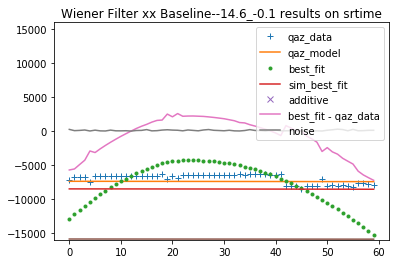

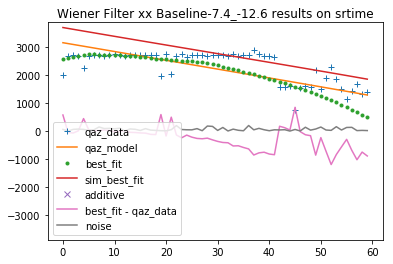

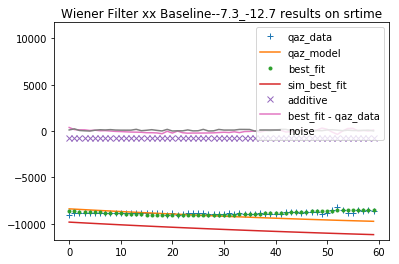

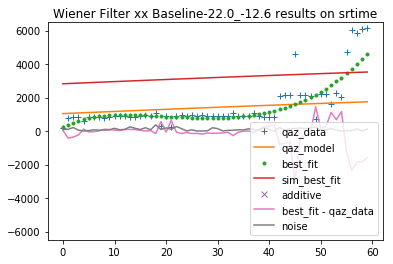

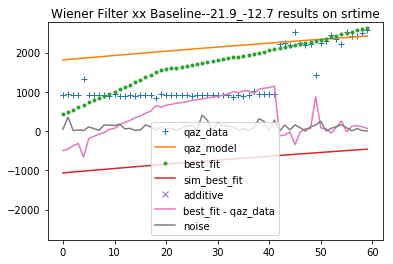

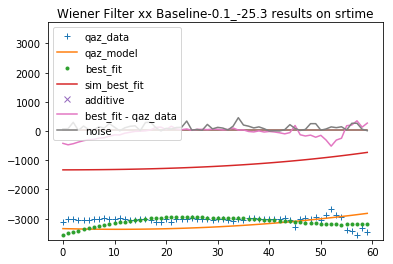

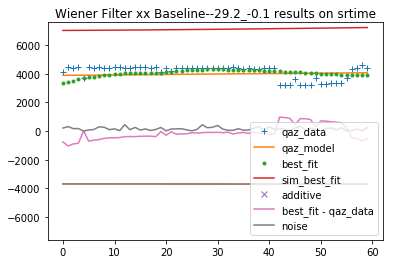

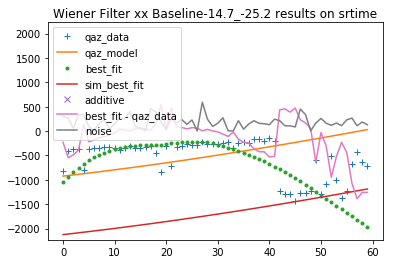

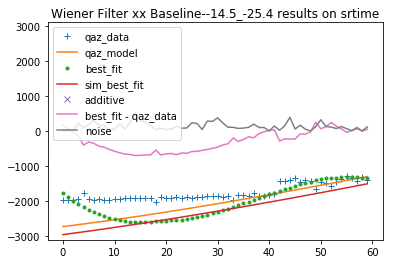

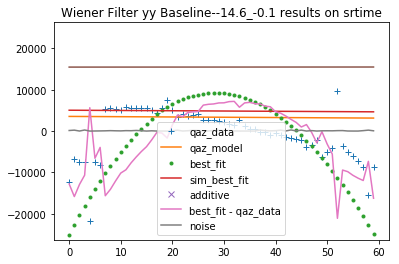

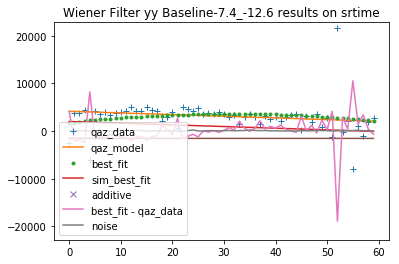

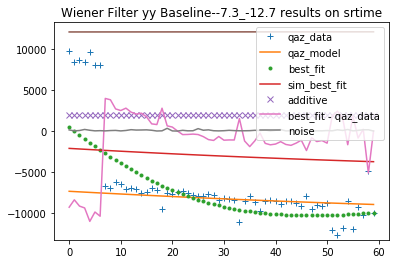

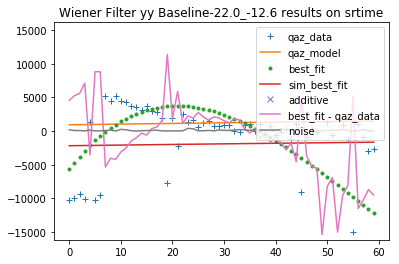

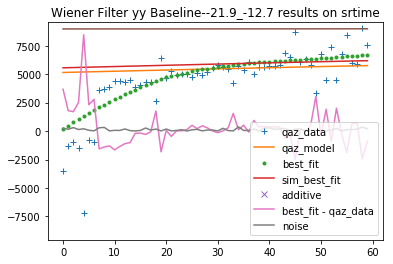

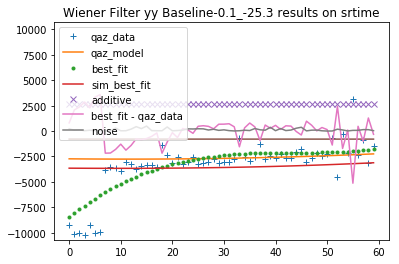

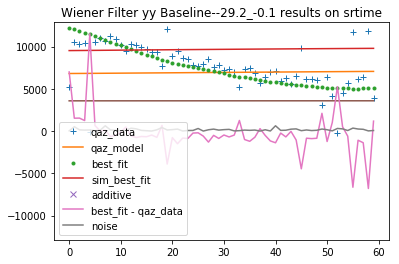

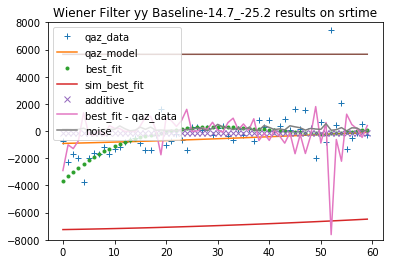

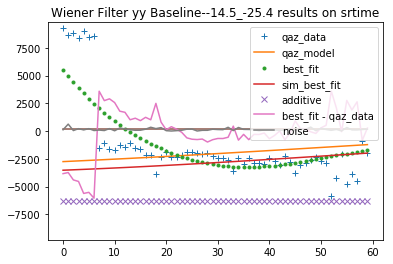

In [192]:
#####apply wiener filter##############
print "Applying Regularized AtNiAi...",
sys.stdout.flush()
w_solution = AtNiAi.dotv(AtNi_data)
w_GSM = AtNiAi.dotv(AtNi_clean_sim_data)
w_sim_sol = AtNiAi.dotv(AtNi_sim_data)
print "Memory usage: %.3fMB" % (resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1000)
sys.stdout.flush()

del (AtNiAi)

if not fit_for_additive:
	A = get_A()
else:
	A = get_A(additive_A)
	
best_fit = A.dot(w_solution.astype(A.dtype)) # Reversely-Calculated-masked-GSM Dynamically simulated Visibilities.
best_fit_no_additive = A[..., :valid_npix].dot(w_solution[:valid_npix].astype(A.dtype))

sim_best_fit = A.dot(w_sim_sol.astype(A.dtype))
sim_best_fit_no_additive = A[..., :valid_npix].dot(w_sim_sol[:valid_npix].astype(A.dtype))

if plot_data_error:
	qaz_model = (clean_sim_data).reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1]) # Dynamic Simulated, Clean, being Normalized    # * vis_normalization
	qaz_data = np.copy(data).reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1]) # Full Simulated, Calibrated, reference for normalization
	if pre_calibrate:
		qaz_add = np.copy(additive_term).reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1])
	pncol = min(int(60. / (srt[-1] - srt[0])), 12)
	us = ubl_sort['x'][::len(ubl_sort['x'])/pncol] if len(ubl_sort['x'])/pncol >=1 else ubl_sort['x'] #[::max(1, len(ubl_sort['x'])/70)]
	best_fit.shape = (2, data_shape['xx'][0], 2, data_shape['xx'][1])
	best_fit_no_additive.shape = (2, data_shape['xx'][0], 2, data_shape['xx'][1])
	sim_best_fit.shape = (2, data_shape['xx'][0], 2, data_shape['xx'][1])
	ri = 1
	#plt.clf()

	figure_W = {}
	for p in range(2):
		
		for nu, u in enumerate(us):
			plt.figure(8000 + 10*p + nu)
			#plt.subplot(6, (len(us) + 5) / 6, nu + 1)
			# plt.errorbar(range(nt_used), qaz_data[ri, u, p], yerr=Ni.reshape((2, nUBL_used, 2, nt_used))[ri, u, p]**-.5)
			figure_W[1], = plt.plot(qaz_data[ri, u, p],'+')
			figure_W[2], = plt.plot(qaz_model[ri, u, p],'-')
			figure_W[3], = plt.plot(best_fit[ri, u, p],'.')
			figure_W[4], = plt.plot(sim_best_fit[ri, u, p])
			if pre_calibrate:
				figure_W[5], = plt.plot(qaz_add[ri, u, p],'x')
			if fit_for_additive:
				figure_W[6], = plt.plot(autocorr_vis_normalized[p] * sol2additive(w_solution)[p, u, ri])
			figure_W[7], = plt.plot(best_fit[ri, u, p] - qaz_data[ri, u, p])
			figure_W[8], = plt.plot(Ni.reshape((2, nUBL_used, 2, nt_used))[ri, u, p]**-.5)
			if pre_calibrate:
				data_range = np.max([np.max(np.abs(qaz_data[ri, u, p])), np.max(np.abs(qaz_model[ri, u, p])), np.max(np.abs(best_fit[ri, u, p])), np.max(np.abs(sim_best_fit[ri, u, p])), np.max(np.abs((best_fit[ri, u, p] - qaz_data[ri, u, p])))]) # np.max(np.abs(qaz_add[ri, u, p])), #, 5 * np.max(np.abs(fun(cNi[u, p])))
				plt.legend(handles=[figure_W[1], figure_W[2], figure_W[3], figure_W[4], figure_W[5], figure_W[7], figure_W[8]], labels=['qaz_data', 'qaz_model', 'best_fit', 'sim_best_fit', 'additive', 'best_fit - qaz_data', 'noise'], loc=0)
			else:
				data_range = np.max([np.max(np.abs(qaz_data[ri, u, p])), np.max(np.abs(qaz_model[ri, u, p])), np.max(np.abs(best_fit[ri, u, p])), np.max(np.abs(sim_best_fit[ri, u, p])), np.max(np.abs((best_fit[ri, u, p] - qaz_data[ri, u, p])))]) #, 5 * np.max(np.abs(fun(cNi[u, p])))
				plt.legend(handles=[figure_W[1], figure_W[2], figure_W[3], figure_W[4], figure_W[7], figure_W[8]], labels=['qaz_data', 'qaz_model', 'best_fit', 'sim_best_fit', 'best_fit - qaz_data', 'noise'], loc=0)
			plt.ylim([-1.05*data_range, 1.05*data_range])
			#plt.title("%.1f,%.1f,%.1e"%(used_common_ubls[u, 0], used_common_ubls[u, 1], la.norm(best_fit[ri, u, p] - qaz_data[ri, u, p])))
			plt.title("Wiener Filter %s Baseline-%.1f_%.1f results on srtime"%(['xx','yy'][p], used_common_ubls[u, 0], used_common_ubls[u, 1]))
			plt.savefig(script_dir + '/../Output/%s-Baseline-%.1f_%.1f-dipole-precal_data_error-WienerFilter_Vis-%s-%.2f-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, used_common_ubls[u, 0], used_common_ubls[u, 1], ['xx','yy'][p], freq, bnside, nside_standard))
			plt.show(block=False)
			#plt.gcf().clear()
			#plt.close()

# Del=True
# if Del:
# 	try:
# 		#del(additive_A)
# 		#del(real_additive_A)
# 	except:
# 		pass

sys.stdout.flush()

In [193]:
def plot_IQU(solution, title, col, shape=(2,3), coord='C'):
	# Es=solution[np.array(final_index).tolist()].reshape((4, len(final_index)/4))
	# I = Es[0] + Es[3]
	# Q = Es[0] - Es[3]
	# U = Es[1] + Es[2]
	I = sol2map(solution)
	plotcoordtmp = coord
	hpv.mollview(np.log10(I), min=0, max=4, coord=plotcoordtmp, title=title, nest=True, sub=(shape[0], shape[1], col))
	#if col == shape[0] * shape[1]:
		#plt.show(block=False)

def plot_IQU_unlimit(solution, title, col, shape=(2,3), coord='C'):
	# Es=solution[np.array(final_index).tolist()].reshape((4, len(final_index)/4))
	# I = Es[0] + Es[3]
	# Q = Es[0] - Es[3]
	# U = Es[1] + Es[2]
	I = sol2map(solution)
	plotcoordtmp = coord
	hpv.mollview(np.log10(I), coord=plotcoordtmp, title=title, nest=True, sub=(shape[0], shape[1], col))
	#if col == shape[0] * shape[1]:
		#plt.show(block=False)


In [194]:
rescale_factor = np.max(np.abs(fake_solution))/ np.max(np.abs(w_solution))

In [195]:
%matplotlib inline

In [196]:
print('Number of Positive w_solution Pixels: %s'%len(w_solution[w_solution>=0]))
print('Number of Positive w_GSM Pixels: %s'%len(w_GSM[w_GSM>=0]))
print('Number of Positive w_sim Pixels: %s'%len(w_sim_sol[w_sim_sol>=0]))
print('Number of Positive GSM Pixels: %s'%len(fake_solution[fake_solution>=0]))

Number of Positive w_solution Pixels: 5104
Number of Positive w_GSM Pixels: 6118
Number of Positive w_sim Pixels: 5762
Number of Positive GSM Pixels: 10456


divide by zero encountered in log10


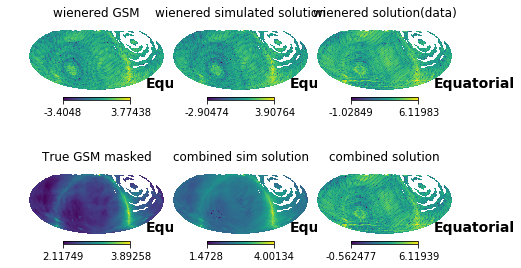

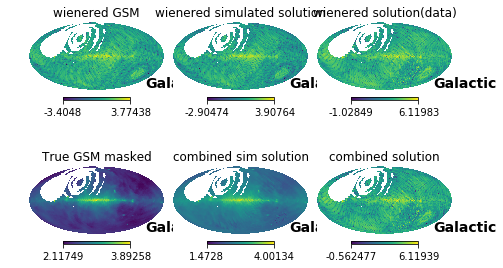

In [197]:
crd = 0
for coord in ['C', 'CG']:
	#plt.clf()
	plt.figure(900 + crd)
	crd += 10
	plot_IQU_unlimit(np.abs(w_GSM), 'wienered GSM', 1, coord=coord) # (clean dynamic_data)
	plot_IQU_unlimit(np.abs(w_sim_sol), 'wienered simulated solution', 2, coord=coord) # (~noise+data)
	plot_IQU_unlimit(np.abs(w_solution), 'wienered solution(data)', 3, coord=coord)
	plot_IQU_unlimit(np.abs(fake_solution), 'True GSM masked', 4, coord=coord)
	plot_IQU_unlimit(np.abs(w_sim_sol - w_GSM + fake_solution), 'combined sim solution', 5, coord=coord)
	plot_IQU_unlimit(np.abs(w_solution - w_GSM + fake_solution), 'combined solution', 6, coord=coord)
	plt.savefig(script_dir + '/../Output/results_wiener-%s-%s-%sMHz-dipole-bnside-%s-nside_standard-%s-rescale-none-unlimit-S-%s-recond-%s.png'%(coord, INSTRUMENT, freq, bnside, nside_standard, S_type, rcond if Add_Rcond else 'none'))
	#plt.show(block=False)
	#plt.gcf().clear()
	


divide by zero encountered in log10


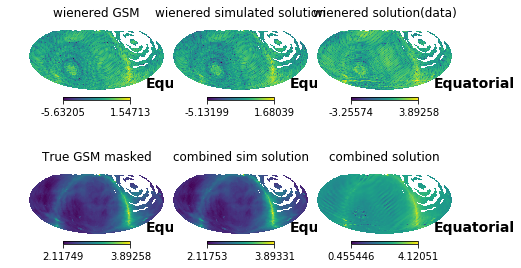

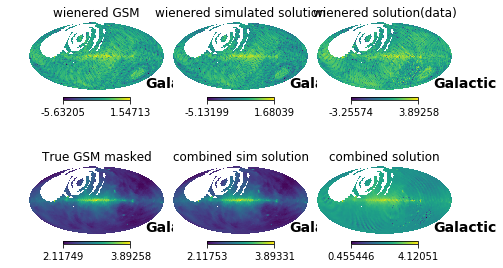

In [198]:
crd = 0
for coord in ['C', 'CG']:
	#plt.clf()
	plt.figure(9000000 + crd)
	crd += 10
	plot_IQU_unlimit(np.abs(w_GSM) * rescale_factor, 'wienered GSM', 1, coord=coord) # (clean dynamic_data)
	plot_IQU_unlimit(np.abs(w_sim_sol) * rescale_factor, 'wienered simulated solution', 2, coord=coord) # (~noise+data)
	plot_IQU_unlimit(np.abs(w_solution) * rescale_factor, 'wienered solution(data)', 3, coord=coord)
	plot_IQU_unlimit(np.abs(fake_solution), 'True GSM masked', 4, coord=coord)
	plot_IQU_unlimit(np.abs((w_sim_sol - w_GSM) * rescale_factor + fake_solution), 'combined sim solution', 5, coord=coord)
	plot_IQU_unlimit(np.abs((w_solution - w_GSM) * rescale_factor + fake_solution), 'combined solution', 6, coord=coord)
	plt.savefig(script_dir + '/../Output/results_wiener-%s-%s-%sMHz-dipole-bnside-%s-nside_standard-%s-rescale-%s-unlimit-S-%s-recond-%s.png'%(coord, INSTRUMENT, freq, bnside, nside_standard, rescale_factor, S_type, rcond if Add_Rcond else 'none'))
	plt.show(block=False)
	#plt.gcf().clear()
	

divide by zero encountered in log10


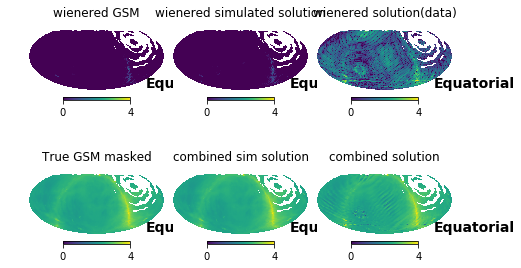

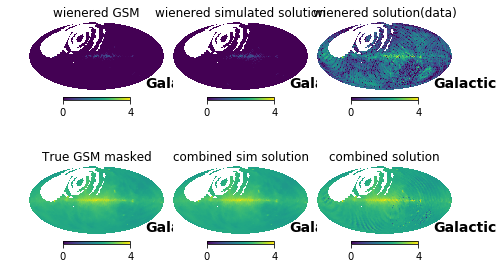

In [199]:
crd = 0
for coord in ['C', 'CG']:
	#plt.clf()
	plt.figure(9500000 + crd)
	crd += 10
	plot_IQU(np.abs(w_GSM) * rescale_factor, 'wienered GSM', 1, coord=coord) # (clean dynamic_data)
	plot_IQU(np.abs(w_sim_sol) * rescale_factor, 'wienered simulated solution', 2, coord=coord) # (~noise+data)
	plot_IQU(np.abs(w_solution) * rescale_factor, 'wienered solution(data)', 3, coord=coord)
	plot_IQU(np.abs(fake_solution), 'True GSM masked', 4, coord=coord)
	plot_IQU(np.abs((w_sim_sol - w_GSM) * rescale_factor + fake_solution), 'combined sim solution', 5, coord=coord)
	plot_IQU(np.abs((w_solution - w_GSM) * rescale_factor + fake_solution), 'combined solution', 6, coord=coord)
	plt.savefig(script_dir + '/../Output/results_wiener-%s-%s-%sMHz-dipole-bnside-%s-nside_standard-%s-rescale-%s-limit-S-%s-recond-%s.png'%(coord, INSTRUMENT, freq, bnside, nside_standard, rescale_factor, S_type, rcond if Add_Rcond else 'none'))
	plt.show(block=False)
	#plt.gcf().clear()

Casting complex values to real discards the imaginary part
divide by zero encountered in log10


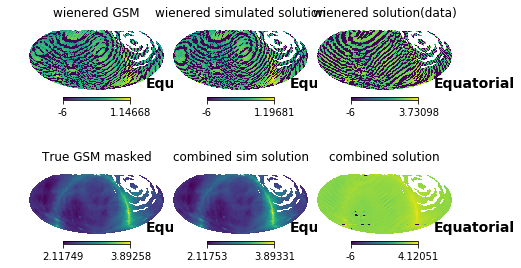

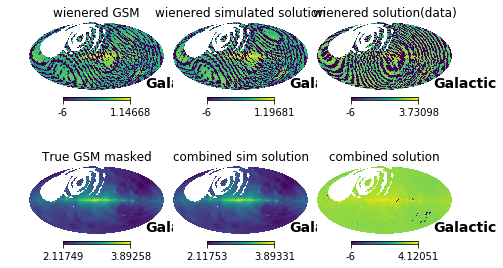

In [200]:
crd = 0
for coord in ['C', 'CG']:
	#plt.clf()
	plt.figure(950 + crd)
	crd += 10
	plot_IQU_unlimit((w_GSM + np.abs(w_GSM))*0.5 * rescale_factor + 1.e-6, 'wienered GSM', 1, coord=coord) # (clean dynamic_data)
	plot_IQU_unlimit((w_sim_sol + np.abs(w_sim_sol))*0.5 * rescale_factor + 1.e-6, 'wienered simulated solution', 2, coord=coord) # (~noise+data)
	plot_IQU_unlimit((w_solution + np.abs(w_solution))*0.5 * rescale_factor + 1.e-6, 'wienered solution(data)', 3, coord=coord)
	plot_IQU_unlimit((fake_solution + np.abs(fake_solution))*0.5 + 1.e-6, 'True GSM masked', 4, coord=coord)
	plot_IQU_unlimit((((w_sim_sol - w_GSM) * rescale_factor + fake_solution) + np.abs((w_sim_sol - w_GSM) * rescale_factor + fake_solution))*0.5 + 1.e-6, 'combined sim solution', 5, coord=coord)
	plot_IQU_unlimit((((w_solution - w_GSM) * rescale_factor + fake_solution) + np.abs((w_solution - w_GSM) * rescale_factor + fake_solution))*0.5 + 1.e-6, 'combined solution', 6, coord=coord)
	plt.savefig(script_dir + '/../Output/results_wiener-%s-%s-%sMHz-dipole-bnside-%s-nside_standard-%s-rescale-%s-denegative-unlimit-S-%s-recond-%s.png'%(coord, INSTRUMENT, freq, bnside, nside_standard, rescale_factor, S_type, rcond if Add_Rcond else 'none'))
	plt.show(block=False)
	#plt.gcf().clear()

divide by zero encountered in log10


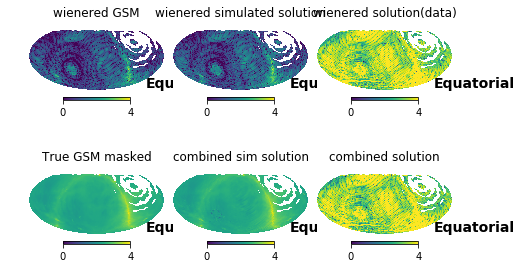

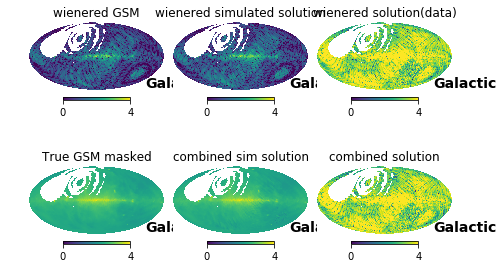

In [201]:
crd = 0
for coord in ['C', 'CG']:
	#plt.clf()
	plt.figure(90000 + crd)
	crd += 10
	plot_IQU(np.abs(w_GSM), 'wienered GSM', 1, coord=coord) # (clean dynamic_data)
	plot_IQU(np.abs(w_sim_sol), 'wienered simulated solution', 2, coord=coord) # (~noise+data)
	plot_IQU(np.abs(w_solution), 'wienered solution(data)', 3, coord=coord)
	plot_IQU(np.abs(fake_solution), 'True GSM masked', 4, coord=coord)
	plot_IQU(np.abs(w_sim_sol - w_GSM + fake_solution), 'combined sim solution', 5, coord=coord)
	plot_IQU(np.abs(w_solution - w_GSM + fake_solution), 'combined solution', 6, coord=coord)
	plt.savefig(script_dir + '/../Output/results_wiener-%s-%s-%sMHz-dipole-bnside-%s-nside_standard-%s-rescale-none-limit-S-%s-recond-%s.png'%(coord, INSTRUMENT, freq, bnside, nside_standard, S_type, rcond if Add_Rcond else 'none'))
	plt.show(block=False)
	#plt.gcf().clear()
	

divide by zero encountered in log10


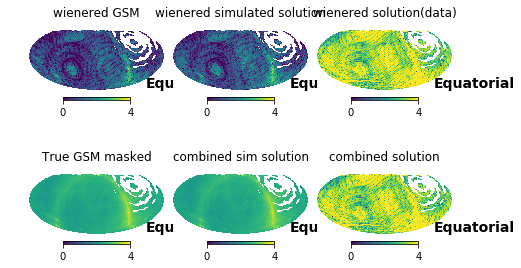

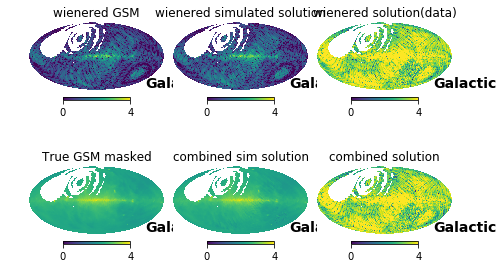

In [202]:
crd = 0
for coord in ['C', 'CG']:
	#plt.clf()
	plt.figure(9000 + crd)
	crd += 10
	plot_IQU(np.abs(w_GSM/vis_normalization), 'wienered GSM', 1, coord=coord) # (clean dynamic_data)
	plot_IQU(np.abs(w_sim_sol/vis_normalization), 'wienered simulated solution', 2, coord=coord) # (~noise+data)
	plot_IQU(np.abs(w_solution), 'wienered solution(data)', 3, coord=coord)
	plot_IQU(np.abs(fake_solution/vis_normalization), 'True GSM masked', 4, coord=coord)
	plot_IQU(np.abs((w_sim_sol - w_GSM + fake_solution)/vis_normalization), 'combined sim solution', 5, coord=coord)
	plot_IQU(np.abs((w_solution - w_GSM + fake_solution)/vis_normalization), 'combined solution', 6, coord=coord)
	plt.savefig(script_dir + '/../Output/results_wiener_renormalized-%s-%s-%sMHz-dipole-bnside-%s-nside_standard-%s-rescale-none-limit-S-%s-recond-%s.png'%(coord, INSTRUMENT, freq, bnside, nside_standard, S_type, rcond if Add_Rcond else 'none'))
	plt.show(block=False)
	#plt.gcf().clear()

chi^2 = 4.194e+07, data points 2160, pixels 10420
re/im chi2 1.493e+07, 2.701e+07
xx/yy chi2 1.081e+06, 4.086e+07


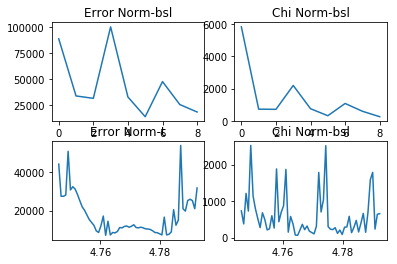

Additive_sol: [6.67903121+0.j 0.48943495+0.j]
('regularization stength', (46.54101364396031+0j), 'median GSM ranges between', 284.4070430340813, 284.4070430340813)
Rescale_factor: 0.005925846982362019


In [203]:
error = data.reshape((2, data_shape['xx'][0], 2, data_shape['xx'][1])) - best_fit
chi = error * (Ni.reshape((2, data_shape['xx'][0], 2, data_shape['xx'][1])))**.5
print "chi^2 = %.3e, data points %i, pixels %i"%(la.norm(chi)**2, len(data), valid_npix)
print "re/im chi2 %.3e, %.3e"%(la.norm(chi[0])**2, la.norm(chi[1])**2)
print "xx/yy chi2 %.3e, %.3e"%(la.norm(chi[:, :, 0])**2, la.norm(chi[:, :, 1])**2)
#plt.clf()
plt.figure(120)
plt.subplot(2, 2, 1)
plt.plot([la.norm(error[:, u]) for u in ubl_sort['x']])
plt.title('Error Norm-bsl')
plt.subplot(2, 2, 2)
plt.plot([la.norm(chi[:, u]) for u in ubl_sort['x']])
plt.title('Chi Norm-bsl')
plt.subplot(2, 2, 3)
plt.plot(lsts, [la.norm(error[..., t]) for t in range(error.shape[-1])])
plt.title('Error Norm-t')
plt.subplot(2, 2, 4)
plt.plot(lsts, [la.norm(chi[..., t]) for t in range(error.shape[-1])])
plt.title('Chi Norm-bsl')
plt.savefig(script_dir + '/../Output/chi-%s-%s-dipole-bnside-%s-nside_standard-%s.png'%(INSTRUMENT, freq, bnside, nside_standard))
plt.show(block=False)
#plt.gcf().clear()

try:
	print('Additive_sol: %s' %additive_sol[:2])
	print ("regularization stength", (maxAtNiA * rcond)**-.5, "median GSM ranges between", np.median(equatorial_GSM_standard) * min(sizes), np.median(equatorial_GSM_standard) * max(sizes))
	print('Rescale_factor: %s'%rescale_factor)
except:
	pass	


sys.stdout.flush()

In [204]:
#S_type = 'none'
#point spread function:
if True and S_type == 'none':
	print "Reading Regularized AtNiAi...",
	sys.stdout.flush()
	AtNiAi = sv.InverseCholeskyMatrix.fromfile(AtNiAi_path, len(S_diag), precision)

	AtNiA_tag = 'AtNiA_N%s'%vartag
	if not fit_for_additive:
		AtNiA_tag += "_noadd"
	elif crosstalk_type == 'autocorr':
		AtNiA_tag += "_autocorr"
	if pre_ampcal:
		AtNiA_tag += "_ampcal"
	AtNiA_filename = AtNiA_tag + A_filename
	AtNiA_path = datadir + tag + AtNiA_filename
	print "Reading AtNiA...",
	sys.stdout.flush()
	AtNiA = np.fromfile(AtNiA_path, dtype=precision).reshape((Ashape1, Ashape1))

	iplot = 0
	valid_thetas_phis = np.array(zip(thetas, phis))
	full_thetas, full_phis = hpf.pix2ang(nside_standard, range(hpf.nside2npix(nside_standard)), nest=True)
	#plt.clf()
	plt.figure(130)
	for theta in np.arange(0, PI*.9, PI/6.):
		for phi in np.arange(0, TPI, PI/3.):
			iplot += 1
			choose_plots = [1, 12, 24]
			if iplot in choose_plots:
				np.argmin(la.norm(valid_thetas_phis - [theta, phi], axis=-1))
				point_vec = np.zeros_like(fake_solution).astype('complex128')

				point_vec[np.argmin(la.norm(valid_thetas_phis - [theta, phi], axis=-1))] = 1
				spreaded = sol2map(AtNiAi.dotv(AtNiA.dot(point_vec)))
				spreaded /= np.max(spreaded)
				fwhm_mask = np.abs(spreaded) >= .5
				masked_max_ind = np.argmax(spreaded[fwhm_mask])
				fwhm_thetas = full_thetas[fwhm_mask]
				fwhm_phis = full_phis[fwhm_mask]
				#rotate angles to center around PI/2 0
				fwhm_thetas, fwhm_phis = hpr.Rotator(rot=[fwhm_phis[masked_max_ind], PI/2-fwhm_thetas[masked_max_ind], 0], deg=False)(fwhm_thetas, fwhm_phis)
				if np.array(fwhm_thetas).shape is (): 
					fwhm_thetas = np.array([fwhm_thetas])
					fwhm_phis = np.array([fwhm_phis])
				print fwhm_thetas[masked_max_ind], fwhm_phis[masked_max_ind]#should print 1.57079632679 0.0 if rotation is working correctly


				fwhm_theta = max(fwhm_thetas) - min(fwhm_thetas)
				phi_offset = fwhm_phis[masked_max_ind] - PI
				fwhm_phis = (fwhm_phis - phi_offset)%TPI + phi_offset
				fwhm_phi = max(fwhm_phis) - min(fwhm_phis) 
				hpv.mollview(np.log10(np.abs(spreaded)), min=-3, max=0, nest=True, coord='CG', title='FWHM = %.3f'%((fwhm_theta*fwhm_phi)**.5*180./PI), sub=(len(choose_plots), 1, choose_plots.index(iplot)+1))
	plt.savefig(script_dir + '/../Output/spreaded_function-CG-%s-%s-dipole-bnside-%s-nside_standard-%s.png'%(INSTRUMENT, freq, bnside, nside_standard))
	plt.show(block=False)
	#plt.gcf().clear()

In [205]:
print AtNiA_filename
print A_filename
print AtNiA_tag

AtNiA_N_2018__autocorr_ampcalA_dI_u9_t60_p10420_n32_32_b64_2.000_v1.0
A_dI_u9_t60_p10420_n32_32_b64_2.000_v1.0
AtNiA_N_2018__autocorr_ampcal


Reading Regularized AtNiAi... Reading AtNiA...

Casting complex values to real discards the imaginary part
divide by zero encountered in log10


 1.5707963267948966 2.9228940278547097e-33


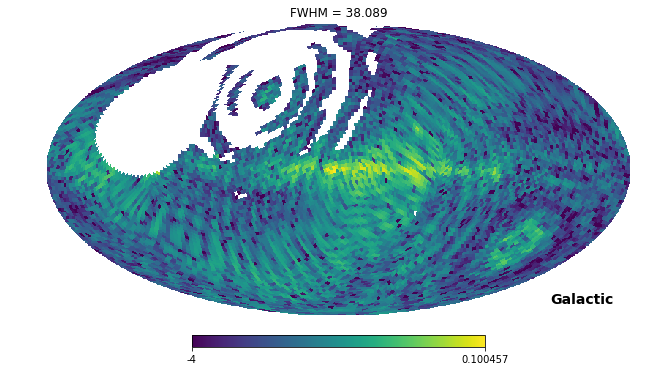

1.5707963267948966 4.2334564159933844e-19


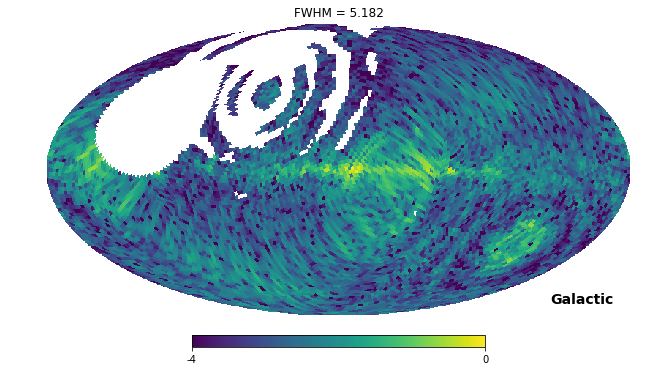

1.5707963267948966 -8.771105757010978e-19


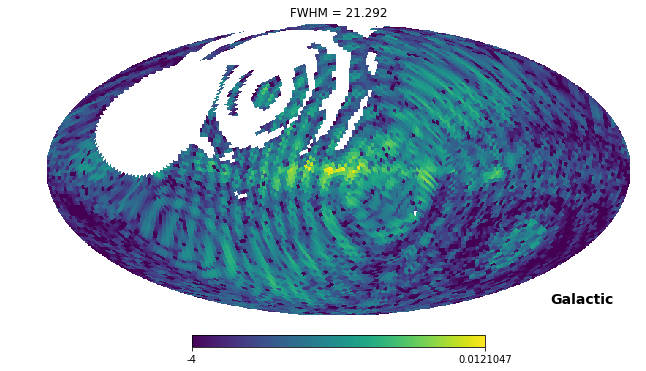

1.5707963267948966 2.9228940278547097e-33


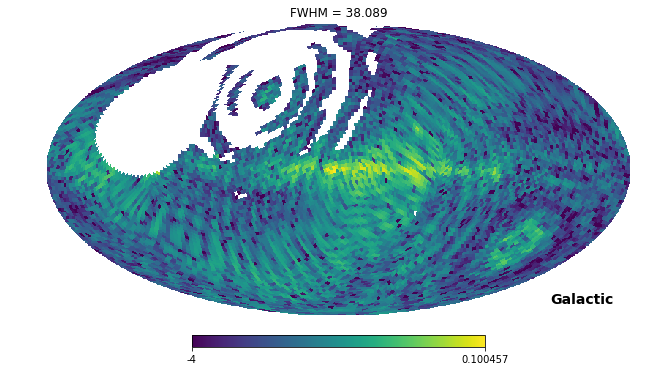

1.5707963267948966 1.0698877043520681e-17


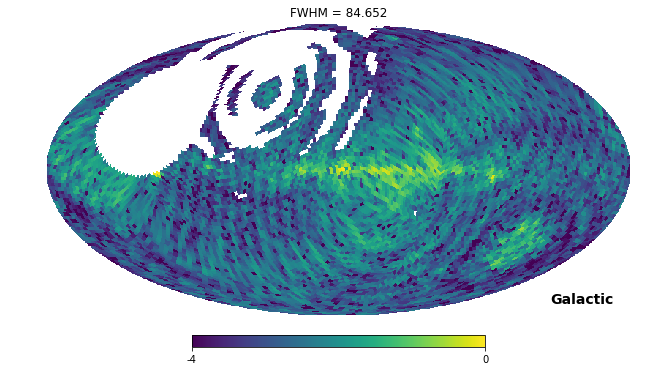

1.5707963267948966 3.885494424521741e-18


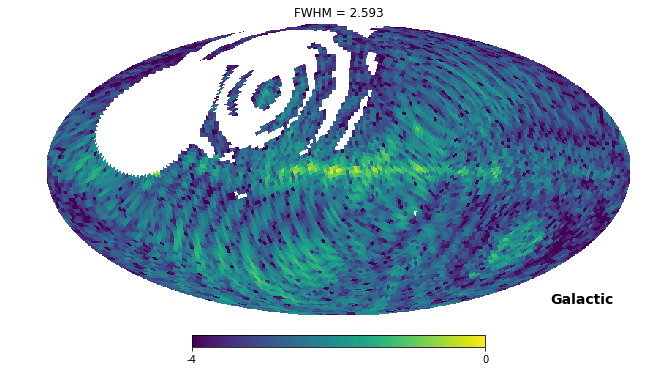

1.5707963267948966 1.5514817053803626e-17


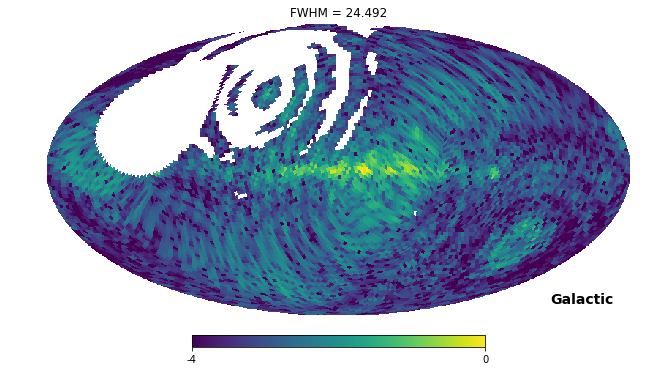

1.5707963267948966 8.746498611567823e-18


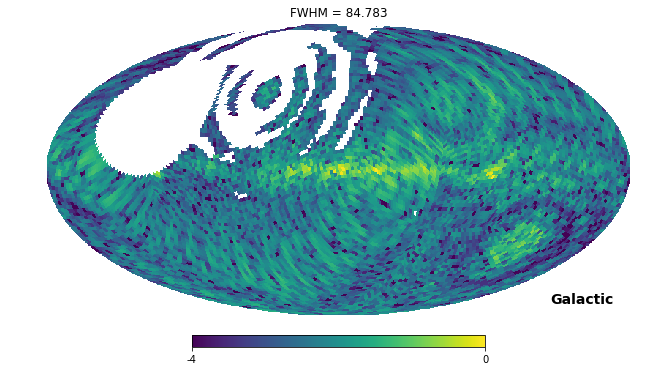

1.5707963267948966 3.885494424521741e-18


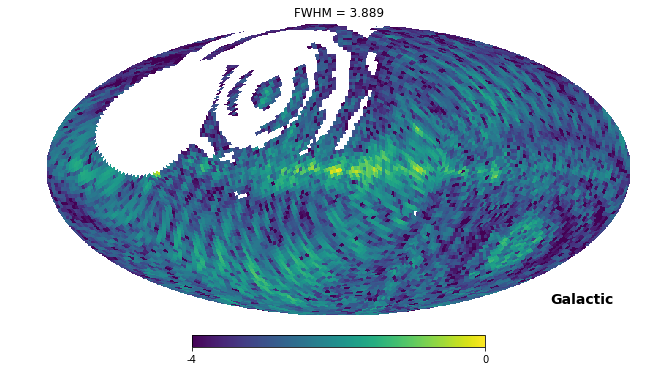

1.5707963267948966 4.106899497426809e-18


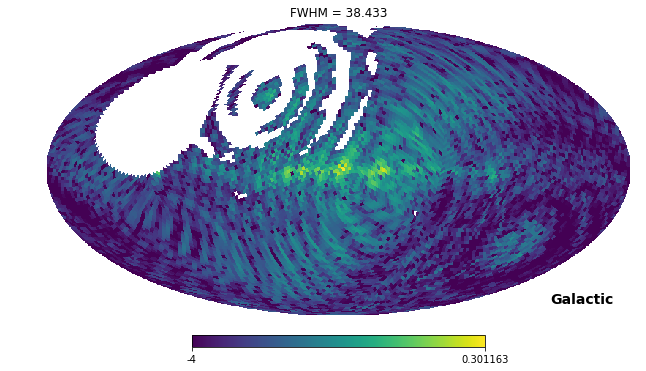

1.5707963267948966 -2.750921070550918e-17


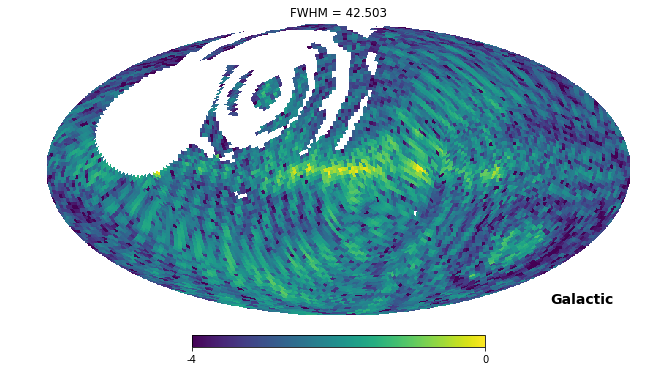

1.5707963267948966 3.885494424521741e-18


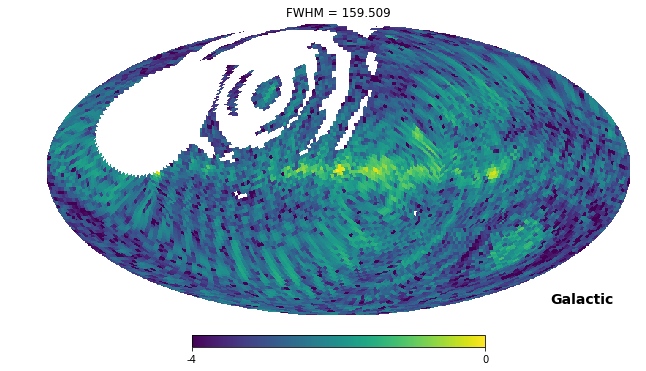

1.5707963267948966 -2.2987347103069353e-17


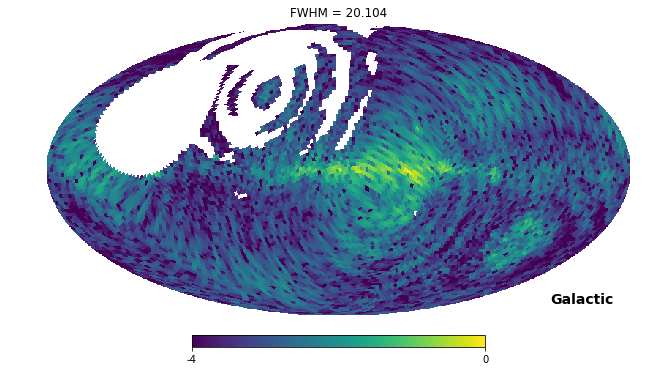

1.5707963267948966 2.9228940278547097e-33


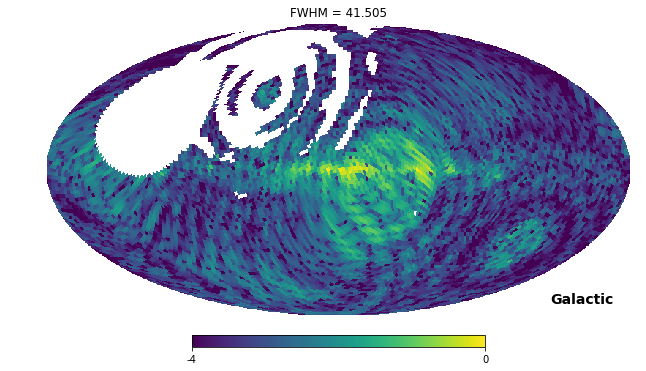

In [206]:
#S_type = 'none'
#point spread function:
if True:# and S_type == 'none':
	print "Reading Regularized AtNiAi...",
	sys.stdout.flush()
	AtNiAi = sv.InverseCholeskyMatrix.fromfile(AtNiAi_path, len(S_diag), precision)

	AtNiA_tag = 'AtNiA_N%s'%vartag
	if not fit_for_additive:
		AtNiA_tag += "_noadd"
	elif crosstalk_type == 'autocorr':
		AtNiA_tag += "_autocorr"
	if pre_ampcal:
		AtNiA_tag += "_ampcal"
	AtNiA_filename = AtNiA_tag + A_filename
	AtNiA_path = datadir + tag + AtNiA_filename
	print "Reading AtNiA...",
	sys.stdout.flush()
	AtNiA = np.fromfile(AtNiA_path, dtype=precision).reshape((Ashape1, Ashape1))

	iplot = 0
	valid_thetas_phis = np.array(zip(thetas, phis))
	full_thetas, full_phis = hpf.pix2ang(nside_standard, range(hpf.nside2npix(nside_standard)), nest=True)
	#plt.clf()
	
	for theta in np.arange(0, PI*.9, PI/6.):
		for phi in np.arange(0, TPI, PI/3.):
			
			#choose_plots = [1, 6, 12, 18, 24, 30]
			choose_plots = [0, 1, 4, 6, 8, 12, 16, 20, 24, 28, 30, 32, 33, 35]
			
			if iplot in choose_plots:
				np.argmin(la.norm(valid_thetas_phis - [theta, phi], axis=-1))
				point_vec = np.zeros_like(fake_solution).astype('complex128')

				point_vec[np.argmin(la.norm(valid_thetas_phis - [theta, phi], axis=-1))] = 1
				spreaded = sol2map(AtNiAi.dotv(AtNiA.dot(point_vec)))
				spreaded /= np.max(spreaded)
				fwhm_mask = np.abs(spreaded) >= .5
				masked_max_ind = np.argmax(spreaded[fwhm_mask])
				fwhm_thetas = full_thetas[fwhm_mask]
				fwhm_phis = full_phis[fwhm_mask]
				#rotate angles to center around PI/2 0
				fwhm_thetas, fwhm_phis = hpr.Rotator(rot=[fwhm_phis[masked_max_ind], PI/2-fwhm_thetas[masked_max_ind], 0], deg=False)(fwhm_thetas, fwhm_phis)
				if np.array(fwhm_thetas).shape is (): 
					fwhm_thetas = np.array([fwhm_thetas])
					fwhm_phis = np.array([fwhm_phis])
				print fwhm_thetas[masked_max_ind], fwhm_phis[masked_max_ind]#should print 1.57079632679 0.0 if rotation is working correctly


				fwhm_theta = max(fwhm_thetas) - min(fwhm_thetas)
				phi_offset = fwhm_phis[masked_max_ind] - PI
				fwhm_phis = (fwhm_phis - phi_offset)%TPI + phi_offset
				fwhm_phi = max(fwhm_phis) - min(fwhm_phis)
				plt.figure(1300+iplot) 
				#hpv.mollview(np.log10(np.abs(spreaded)), min=-3, max=0, nest=True, coord='CG', title='FWHM = %.3f'%((fwhm_theta*fwhm_phi)**.5*180./PI), sub=(len(choose_plots), 1, choose_plots.index(iplot)+1))
				hpv.mollview(np.log10(np.abs(spreaded)), min=-4, nest=True, coord='CG', title='FWHM = %.3f'%((fwhm_theta*fwhm_phi)**.5*180./PI))
				plt.savefig(script_dir + '/../Output/spreaded_function-CG-%s-%s-%s-dipole-bnside-%s-nside_standard-%s.png'%(INSTRUMENT, iplot, freq, bnside, nside_standard))
				plt.show(block=False)
				#plt.gcf().clear()
			iplot += 1


sys.stdout.flush()


In [207]:
#point_vec